In [1]:
import scipy
import matplotlib
import numpy as np
import math
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import colorbar
from matplotlib.patches import Ellipse
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from astropy.table import Table, vstack, join
from astropy.io import ascii, fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from collections import Counter
from matplotlib.lines import Line2D
import lmfit
from sklearn.linear_model import LinearRegression
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
pd.options.mode.copy_on_write = True
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.optimize import fsolve
import tensorflow as tf
from scipy.optimize import fsolve
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import cross_validate, KFold
from tensorflow import keras

2025-03-18 15:37:07.118044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742326633.354781 3433474 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742326636.333632 3433474 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 15:37:38.607734: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def read_fits_and_cut_plus(input_file_name):
    df = pd.read_csv(input_file_name)
    df['id'] = df['id'].astype(str)
    df.drop(['MASK','SLIT','B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE','TEFFERR','LOGGERR','ALPHAFE', 'ALPHAFEERR','SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR'], axis=1, inplace=True)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    df = df[(-0.0 < df['MGFEERR']) & (df['MGFEERR'] < 0.5)]
    return df
    
def read_hsc(input_file_name):
    data = ascii.read(input_file_name,
        names=['id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr',
        'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n'])
    df = data.to_pandas()
    df['id'] = df['id'].astype(str)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    df['g0'] = df['gpsf'] - df['a_g']
    df['i0'] = df['ipsf'] - df['a_i']
    df['n0'] = df['npsf'] - df['a_n']
    return df

def read_hsc_members(input_file_name):
    df = pd.read_csv(input_file_name)
    df['id'] = df['id'].astype(str)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    return df

In [7]:
## Read HSC-DEIMOS files
fnx = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Fornax_HSC_DEIMOS_plus_w_age.csv')
scl = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Sculptor_HSC_DEIMOS_plus_w_age.csv')
umi = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Ursaminor_HSC_DEIMOS_plus_w_age.csv')
dra = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Draco_HSC_DEIMOS_plus_w_age.csv')
print(f'len(fnx) = {len(fnx)}') #485 -> 308
print(f'len(scl) = {len(scl)}') #405 -> 283
print(f'len(umi) = {len(umi)}') #263 -> 93
print(f'len(dra) = {len(dra)}') #168 -> 93

## Read whole HSC data
hsc_fnx = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/fornax_tpall3e_g24_radec_members_cut.csv')
hsc_scl = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/sculptor_tpall3e_g24_radec_members_cut.csv')
hsc_umi = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/ursaminor_tpall3e_g24_radec_members_cut.csv')
hsc_dra = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/draco_tpall3e_g24_radec_members_cut.csv')
print(f'len(hsc_fnx) = {len(hsc_fnx)}') #23089
print(f'len(hsc_scl) = {len(hsc_scl)}') #2137
print(f'len(hsc_umi) = {len(hsc_umi)}') #921
print(f'len(hsc_dra) = {len(hsc_dra)}') #478

# Define the distance modulus for each dataset from McConnachie (2012)
dm_values = {
    'fnx': 20.84,
    'scl': 19.67,
    'umi': 19.4,
    'dra': 19.4
}

# Define the datasets
datasets = {
    'fnx': [fnx, hsc_fnx],
    'scl': [scl, hsc_scl],
    'umi': [umi, hsc_umi],
    'dra': [dra, hsc_dra]
}

# Apply the distance modulus correction and store as G0
for key, dataset_list in datasets.items():
    dm = dm_values[key]
    for dataset in dataset_list:
        dataset['Mg0'] = dataset['g0'] - dm
        dataset['Mi0'] = dataset['i0'] - dm
        dataset['Mn0'] = dataset['n0'] - dm

xmin, xmax = 0.4, 2

Mg0_max = -0.20 ; Mn0_max = -0.30 ; Mi0_max = -1.18
fnx_mag = fnx[(xmin < fnx['Mg0']-fnx['Mi0']) & (fnx['Mg0']-fnx['Mi0'] < xmax) & (fnx['Mg0'] < Mg0_max) & (fnx['Mn0'] < Mn0_max) & (fnx['Mi0'] < Mi0_max)]
print('len(fnx_mag) =', len(fnx), '->', len(fnx_mag)) #308 -> 283
hsc_fnx_mag = hsc_fnx[(xmin < hsc_fnx['Mg0']-hsc_fnx['Mi0']) & (hsc_fnx['Mg0']-hsc_fnx['Mi0'] < xmax) & (hsc_fnx['Mg0'] < Mg0_max) & (hsc_fnx['Mn0'] < Mn0_max) & (hsc_fnx['Mi0'] < Mi0_max)]
print('len(hsc_fnx_mag) =', len(hsc_fnx), '->', len(hsc_fnx_mag)) #23089 -> 7251

Mg0_max = 0.18 ; Mn0_max = 0.08 ; Mi0_max = -0.70
scl_mag = scl[(xmin < scl['Mg0']-scl['Mi0']) & (scl['Mg0']-scl['Mi0'] < xmax) & (scl['Mg0'] < Mg0_max) & (scl['Mn0'] < Mn0_max) & (scl['Mi0'] < Mi0_max)]
print('len(scl_mag) =', len(scl), '->', len(scl_mag)) #283 -> 280
hsc_scl_mag = hsc_scl[(xmin < hsc_scl['Mg0']-hsc_scl['Mi0']) & (hsc_scl['Mg0']-hsc_scl['Mi0'] < xmax) & (hsc_scl['Mg0'] < Mg0_max) & (hsc_scl['Mn0'] < Mn0_max) & (hsc_scl['Mi0'] < Mi0_max)]
print('len(hsc_scl_mag) =', len(hsc_scl), '->', len(hsc_scl_mag)) #2137 -> 1132

Mg0_max = 1.00 ; Mn0_max = 0.85 ; Mi0_max = 0.15
umi_mag = umi[(xmin < umi['Mg0']-umi['Mi0']) & (umi['Mg0']-umi['Mi0'] < xmax) & (umi['Mg0'] < Mg0_max) & (umi['Mn0'] < Mn0_max) & (umi['Mi0'] < Mi0_max)]
print('len(umi_mag) =', len(umi), '->', len(umi_mag)) #93 -> 88
hsc_umi_mag = hsc_umi[(xmin < hsc_umi['Mg0']-hsc_umi['Mi0']) & (hsc_umi['Mg0']-hsc_umi['Mi0'] < xmax) & (hsc_umi['Mg0'] < Mg0_max) & (hsc_umi['Mn0'] < Mn0_max) & (hsc_umi['Mi0'] < Mi0_max)]
print('len(hsc_umi_mag) =', len(hsc_umi), '->', len(hsc_umi_mag)) #921 -> 593

Mg0_max = 0.65 ; Mn0_max = 0.50 ; Mi0_max = -0.20
dra_mag = dra[(xmin < dra['Mg0']-dra['Mi0']) & (dra['Mg0']-dra['Mi0'] < xmax) & (dra['Mg0'] < Mg0_max) & (dra['Mn0'] < Mn0_max) & (dra['Mi0'] < Mi0_max)]
print('len(dra_mag) =', len(dra), '->', len(dra_mag)) #93 -> 90
hsc_dra_mag = hsc_dra[(xmin < hsc_dra['Mg0']-hsc_dra['Mi0']) & (hsc_dra['Mg0']-hsc_dra['Mi0'] < xmax) & (hsc_dra['Mg0'] < Mg0_max) & (hsc_dra['Mn0'] < Mn0_max) & (hsc_dra['Mi0'] < Mi0_max)]
print('len(hsc_dra_mag) =', len(hsc_dra), '->', len(hsc_dra_mag)) #478 -> 342

umi_mag = pd.concat([umi_mag.copy()] * 3, ignore_index=True)
dra_mag = pd.concat([dra_mag.copy()] * 3, ignore_index=True)

# Combine DEIMOS
frame = [fnx_mag, scl_mag, umi_mag, dra_mag]
df_mag = pd.concat(frame, ignore_index=True)
print('len(df_mag) =', len(df_mag)) #741
print(Counter(df_mag['DSPH'])) #Counter({'for': 283, 'scl': 280, 'dra': 90, 'umi': 88})

# Combine HSC
frame = [hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag]
hsc_df_mag = pd.concat(frame, ignore_index=True)
print('len(hsc_df_mag) =', len(hsc_df_mag)) #9318
print(Counter(hsc_df_mag['name'])) #Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342})

len(fnx) = 308
len(scl) = 283
len(umi) = 93
len(dra) = 93
len(hsc_fnx) = 23089
len(hsc_scl) = 2137
len(hsc_umi) = 921
len(hsc_dra) = 478
len(fnx_mag) = 308 -> 283
len(hsc_fnx_mag) = 23089 -> 7251
len(scl_mag) = 283 -> 280
len(hsc_scl_mag) = 2137 -> 1132
len(umi_mag) = 93 -> 88
len(hsc_umi_mag) = 921 -> 593
len(dra_mag) = 93 -> 90
len(hsc_dra_mag) = 478 -> 342
len(df_mag) = 1097
Counter({'for': 283, 'scl': 280, 'dra': 270, 'umi': 264})
len(hsc_df_mag) = 9318
Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342})


# Random Forest Regressor

In [8]:
%%time

#Do one-hot incoding using pd.get_dummies
df_mag['DSPH_original'] = df_mag['DSPH']
df_mag = pd.get_dummies(df_mag, columns=['DSPH'])
df_mag['galaxy_id'] = (
    0 * df_mag['DSPH_for'] +
    1 * df_mag['DSPH_scl'] +
    2 * df_mag['DSPH_umi'] +
    3 * df_mag['DSPH_dra']
)
df_mag.rename(columns = {'DSPH_original':'DSPH'}, inplace=True)
df_mag['Mg0_Mi0'] = df_mag['Mg0'] - df_mag['Mi0']
df_mag['Mg0_Mn0'] = df_mag['Mg0'] - df_mag['Mn0']

indices = df_mag.index

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def build_model_rfr(n_estimators, min_samples_leaf, max_features):
    model = RandomForestRegressor(
        n_estimators = n_estimators, 
        min_samples_leaf = min_samples_leaf, 
        max_features = max_features, 
        oob_score = True,
        random_state = 42
    )
    return model

model_rfr = build_model_rfr(500, 3, 0.5) #3 was supposed to be 1 / 11, 3, 0.5 are also possible

train_dataset_oob_rmse_feh_list = []
train_dataset_oob_rmse_mgh_list = []

train_dataset_rmse_feh_list = []
train_dataset_rmse_mgh_list = []
train_dataset_rsq_feh_list = []
train_dataset_rsq_mgh_list = []

test_dataset_rmse_feh_list = []
test_dataset_rmse_mgh_list = []
test_dataset_rsq_feh_list = []
test_dataset_rsq_mgh_list = []

# Iterate over each fold
for train_index, test_index in kf.split(df_mag):
    # Split into training and testing set for this fold
    train_dataset = df_mag.iloc[train_index]
    test_dataset = df_mag.iloc[test_index]

    # Train the model
    model_rfr.fit(train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values,
                  train_dataset[['FEH', 'MGH']].values)

    # Predict on train and test sample
    train_dataset_pred_values = model_rfr.predict(train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values)
    train_dataset['FEH_phot_rfr'], train_dataset['MGH_phot_rfr'] = train_dataset_pred_values[:, 0], train_dataset_pred_values[:, 1]
    train_dataset['FEH_phot_rfr_uncertainty'], train_dataset['MGH_phot_rfr_uncertainty'] = train_dataset_pred_values[:, 0].std(axis=0), train_dataset_pred_values[:, 1].std(axis=0)

    test_dataset_pred_values = model_rfr.predict(test_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values)
    test_dataset['FEH_phot_rfr'], test_dataset['MGH_phot_rfr'] = test_dataset_pred_values[:, 0], test_dataset_pred_values[:, 1]
    test_dataset['FEH_phot_rfr_uncertainty'], test_dataset['MGH_phot_rfr_uncertainty'] = test_dataset_pred_values[:, 0].std(axis=0), test_dataset_pred_values[:, 1].std(axis=0)

    # # OOB RMSE
    # train_dataset_oob_pred_feh = model_rfr.oob_prediction_[:, 0]
    # train_dataset_oob_rmse_feh = math.sqrt(mean_squared_error(train_dataset['FEH'].values, train_dataset_oob_pred_feh))
    # train_dataset_oob_rmse_feh_list.append(np.mean(train_dataset_oob_rmse_feh))
    
    # train_dataset_oob_pred_mgh = model_rfr.oob_prediction_[:, 1]
    # train_dataset_oob_rmse_mgh = math.sqrt(mean_squared_error(train_dataset['MGH'].values, train_dataset_oob_pred_mgh))
    # train_dataset_oob_rmse_mgh_list.append(np.mean(train_dataset_oob_rmse_mgh))

    # # RMSE
    # train_dataset_rmse_feh = math.sqrt(mean_squared_error(train_dataset['FEH'].values, train_dataset['FEH_phot_rfr'].values))
    # train_dataset_rmse_feh_list.append(np.mean(train_dataset_rmse_feh))
    # train_dataset_rmse_mgh = math.sqrt(mean_squared_error(train_dataset['MGH'].values, train_dataset['MGH_phot_rfr'].values))
    # train_dataset_rmse_mgh_list.append(np.mean(train_dataset_rmse_mgh))
    
    # test_dataset_rmse_feh = math.sqrt(mean_squared_error(test_dataset['FEH'].values, test_dataset['FEH_phot_rfr'].values))
    # test_dataset_rmse_feh_list.append(np.mean(test_dataset_rmse_feh))
    # test_dataset_rmse_mgh = math.sqrt(mean_squared_error(test_dataset['MGH'].values, test_dataset['MGH_phot_rfr'].values))
    # test_dataset_rmse_mgh_list.append(np.mean(test_dataset_rmse_mgh))

    # # R^2 score
    # train_dataset_rsq_feh = r2_score(train_dataset['FEH'].values, train_dataset['FEH_phot_rfr'].values)
    # train_dataset_rsq_feh_list.append(train_dataset_rsq_feh)
    # train_dataset_rsq_mgh = r2_score(train_dataset['MGH'].values, train_dataset['MGH_phot_rfr'].values)
    # train_dataset_rsq_mgh_list.append(train_dataset_rsq_mgh)

    # test_dataset_rsq_feh = r2_score(test_dataset['FEH'].values, test_dataset['FEH_phot_rfr'].values)
    # test_dataset_rsq_feh_list.append(test_dataset_rsq_feh)
    # test_dataset_rsq_mgh = r2_score(test_dataset['MGH'].values, test_dataset['MGH_phot_rfr'].values)
    # test_dataset_rsq_mgh_list.append(test_dataset_rsq_mgh)

## Finally, get the prediction from the HSC data
hsc_df_mag['name_original'] = hsc_df_mag['name']
hsc_df_mag = pd.get_dummies(hsc_df_mag, columns=['name'])
hsc_df_mag['galaxy_id'] = (
    0 * hsc_df_mag['name_for'] +
    1 * hsc_df_mag['name_scl'] +
    2 * hsc_df_mag['name_umi'] +
    3 * hsc_df_mag['name_dra']
)
hsc_df_mag.rename(columns = {'name_original':'name'}, inplace=True)
hsc_df_mag['Mg0_Mi0'] = hsc_df_mag['Mg0'] - hsc_df_mag['Mi0']
hsc_df_mag['Mg0_Mn0'] = hsc_df_mag['Mg0'] - hsc_df_mag['Mn0']

hsc_dataset_pred_values = model_rfr.predict(hsc_df_mag[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values)
hsc_df_mag['FEH_phot_rfr'], hsc_df_mag['MGH_phot_rfr'] = hsc_dataset_pred_values[:, 0], hsc_dataset_pred_values[:, 1]
hsc_df_mag['FEH_phot_rfr_uncertainty'], hsc_df_mag['MGH_phot_rfr_uncertainty'] = hsc_dataset_pred_values[:, 0].std(axis=0), hsc_dataset_pred_values[:, 1].std(axis=0)


# ## Monte Carlo Simulation
# n_mc = 1000
# mc_samples = np.zeros((n_mc, len(hsc_df_mag))) #(1000 rows, len HSC_cols)
# for i in range(n_mc):
#     # Add photometric errors w/ gaussian error
#     Mg_mc = hsc_df_mag['Mg0'] + hsc_df_mag['gpsferr'] * np.random.normal(size=len(hsc_df_mag))
#     Mi_mc = hsc_df_mag['Mi0'] + hsc_df_mag['ipsferr'] * np.random.normal(size=len(hsc_df_mag))
#     Mn_mc = hsc_df_mag['Mn0'] + hsc_df_mag['npsferr'] * np.random.normal(size=len(hsc_df_mag))
#     X_mc = np.column_stack((Mg_mc, Mg_mc-Mi_mc, Mg_mc-Mn_mc, hsc_df_mag['galaxy_id'].values))
#     mc_samples[i, :] = model_rfr.predict(X_mc)

# hsc_df_mag['FEH_phot_rfr_mc'] = np.mean(mc_samples, axis=0)
# hsc_df_mag['FEH_phot_rfr_mc_uncertainty'] = np.std(mc_samples, axis=0)

# hsc_df_mag['FEH_phot_rfr_err'] = np.sqrt(hsc_df_mag['FEH_phot_rfr_mc_uncertainty']**2 + train_dataset_oob_rmse_avg**2)

# ---------------------------------------------------------------------------------------------------------------------------------

# Predict MGFE
hsc_df_mag['MGFE_phot_rfr'] = hsc_df_mag['MGH_phot_rfr'] - hsc_df_mag['FEH_phot_rfr']
hsc_df_mag['MGFE_phot_rfr_uncertainty'] = np.sqrt(np.abs(hsc_df_mag['MGH_phot_rfr_uncertainty']**2 + hsc_df_mag['FEH_phot_rfr_uncertainty']**2))
# hsc_df_mag['MGFE_phot_rfr_err'] = np.sqrt(np.abs(hsc_df_mag['MGH_phot_rfr_err']**2 + hsc_df_mag['FEH_phot_rfr_err']**2))
# hsc_df_mag['MGFE_phot_rfr_mc'] = hsc_df_mag['MGH_phot_rfr_mc'] - hsc_df_mag['FEH_phot_rfr_mc']
# hsc_df_mag['MGFE_phot_rfr_mc_uncertainty'] = np.sqrt(np.abs(hsc_df_mag['MGH_phot_rfr_mc_uncertainty']**2 + hsc_df_mag['FEH_phot_rfr_mc_uncertainty']**2))

#train_dataset = pd.DataFrame(columns=train_dataset.columns)
# train_dataset['Mg0'] = train_dataset['Mg0'] - train_dataset['Mg0']
# train_dataset['Mi0'] = train_dataset['Mi0'] - train_dataset['Mi0']
# train_dataset['Mn0'] = train_dataset['Mn0'] - train_dataset['Mn0']
# train_dataset['Mg0_Mi0'] = train_dataset['Mg0_Mi0'] - train_dataset['Mg0_Mi0']
# train_dataset['Mg0_Mn0'] = train_dataset['Mg0_Mn0'] - train_dataset['Mg0_Mn0']
train_dataset['MGFE'] = train_dataset['MGH'] - train_dataset['FEH']
train_dataset['MGFEERR'] = np.sqrt(train_dataset['MGHERR']**2 + train_dataset['FEHERR']**2)
train_dataset['MGFE_phot_rfr'] = train_dataset['MGH_phot_rfr'] - train_dataset['FEH_phot_rfr']
train_dataset['MGFE_phot_rfr_uncertainty'] = np.sqrt(train_dataset['MGH_phot_rfr_uncertainty']**2 + train_dataset['FEH_phot_rfr_uncertainty']**2)

#test_dataset = pd.DataFrame(columns=test_MGH.columns)
# test_dataset['Mg0'] = test_dataset['Mg0'] - test_dataset['Mg0']
# test_dataset['Mi0'] = test_dataset['Mi0'] - test_dataset['Mi0']
# test_dataset['Mn0'] = test_dataset['Mn0'] - test_dataset['Mn0']
# test_dataset['Mg0_Mi0'] = test_dataset['Mg0_Mi0'] - test_dataset['Mg0_Mi0']
# test_dataset['Mg0_Mn0'] = test_dataset['Mg0_Mn0'] - test_dataset['Mg0_Mn0']
test_dataset['MGFE'] = test_dataset['MGH'] - test_dataset['FEH']
test_dataset['MGFEERR'] = np.sqrt(test_dataset['MGHERR']**2 + test_dataset['FEHERR']**2)
test_dataset['MGFE_phot_rfr'] = test_dataset['MGH_phot_rfr'] - test_dataset['FEH_phot_rfr']
test_dataset['MGFE_phot_rfr_uncertainty'] = np.sqrt(test_dataset['MGH_phot_rfr_uncertainty']**2 + test_dataset['FEH_phot_rfr_uncertainty']**2)

# Wall time: 9.55 s

CPU times: user 9.6 s, sys: 23.4 ms, total: 9.63 s
Wall time: 9.56 s


In [6]:
train_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dra = train_dataset[train_dataset['galaxy_id'] == 3]

test_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dra = test_dataset[test_dataset['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

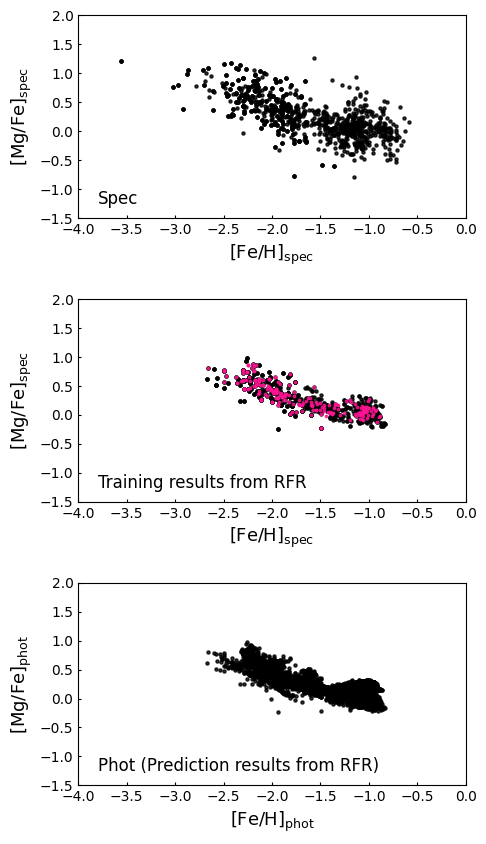

In [7]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_fnx['FEH_phot_rfr'], train_fnx['MGFE_phot_rfr'], s=s, alpha=alpha, color='black')
ax1.scatter(train_scl['FEH_phot_rfr'], train_scl['MGFE_phot_rfr'], s=s, alpha=alpha, color='black')
ax1.scatter(train_umi['FEH_phot_rfr'], train_umi['MGFE_phot_rfr'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dra['FEH_phot_rfr'], train_dra['MGFE_phot_rfr'], s=s, alpha=alpha, color='black')
ax1.scatter(test_fnx['FEH_phot_rfr'], test_fnx['MGFE_phot_rfr'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_scl['FEH_phot_rfr'], test_scl['MGFE_phot_rfr'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_umi['FEH_phot_rfr'], test_umi['MGFE_phot_rfr'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dra['FEH_phot_rfr'], test_dra['MGFE_phot_rfr'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from RFR', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_rfr'], hsc_fnx_mag['MGFE_phot_rfr'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_rfr'], hsc_scl_mag['MGFE_phot_rfr'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_rfr'], hsc_umi_mag['MGFE_phot_rfr'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_rfr'], hsc_dra_mag['MGFE_phot_rfr'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from RFR)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

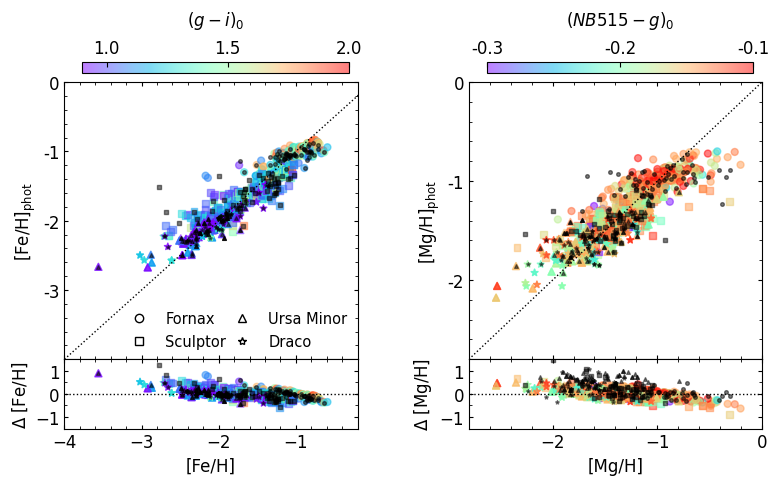

In [8]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 25 ; alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', '*']

# Training
# [Fe/H]
ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_fnx['FEH'], train_fnx['FEH_phot_rfr'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_scl['FEH'], train_scl['FEH_phot_rfr'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_umi['FEH'], train_umi['FEH_phot_rfr'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dra['FEH'], train_dra['FEH_phot_rfr'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax0.scatter(test_fnx['FEH'], test_fnx['FEH_phot_rfr'], s=7, alpha=0.5, marker=markers[0], color='black')
ax0.scatter(test_scl['FEH'], test_scl['FEH_phot_rfr'], s=7, alpha=0.5, marker=markers[1], color='black')
ax0.scatter(test_umi['FEH'], test_umi['FEH_phot_rfr'], s=7, alpha=0.5, marker=markers[2], color='black')
ax0.scatter(test_dra['FEH'], test_dra['FEH_phot_rfr'], s=7, alpha=0.5, marker=markers[3], color='black')

custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
legend = ax0.legend(handles=custom_legend, fontsize=10.5, framealpha=0, ncol=2, columnspacing=0.1)
legend.set_bbox_to_anchor((0.16, 0.12, 0.3, 0.1), transform=ax0.transAxes)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.05, 0.96, f'Training (N={len(train_FEH)}, RMSE={train_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
#ax0.text(0.05, 0.88, f'Test (N={len(test_FEH)}, RMSE={test_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(g - i)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])
#m_train, b_train = np.polyfit(train_FEH['FEH'], train_FEH['FEH_phot_rfr'], 1)
#ax0.plot(np.linspace(xmin, xmax, 100), m_train * np.linspace(xmin, xmax, 100) + b_train, color='black', linestyle='-', linewidth=1.5, label='Train Fit')
#print('m_train =', m_train)

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_fnx['FEH'], train_fnx['FEH_phot_rfr']-train_fnx['FEH'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_scl['FEH'], train_scl['FEH_phot_rfr']-train_scl['FEH'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_umi['FEH'], train_umi['FEH_phot_rfr']-train_umi['FEH'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dra['FEH'], train_dra['FEH_phot_rfr']-train_dra['FEH'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax2.scatter(test_fnx['FEH'], test_fnx['FEH_phot_rfr']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax2.scatter(test_scl['FEH'], test_scl['FEH_phot_rfr']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax2.scatter(test_umi['FEH'], test_umi['FEH_phot_rfr']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax2.scatter(test_dra['FEH'], test_dra['FEH_phot_rfr']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.5, 1.5])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)


# Test
# [Mg/H]
xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_fnx['MGH'], train_fnx['MGH_phot_rfr'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_scl['MGH'], train_scl['MGH_phot_rfr'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_umi['MGH'], train_umi['MGH_phot_rfr'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dra['MGH'], train_dra['MGH_phot_rfr'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax1.scatter(test_fnx['MGH'], test_fnx['MGH_phot_rfr'], s=7, alpha=0.5, marker=markers[0], color='black')
ax1.scatter(test_scl['MGH'], test_scl['MGH_phot_rfr'], s=7, alpha=0.5, marker=markers[1], color='black')
ax1.scatter(test_umi['MGH'], test_umi['MGH_phot_rfr'], s=7, alpha=0.5, marker=markers[2], color='black')
ax1.scatter(test_dra['MGH'], test_dra['MGH_phot_rfr'], s=7, alpha=0.5, marker=markers[3], color='black')

ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-2, -1, 0])
ax1.set_yticklabels(['-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.05, 0.96, f'Training (N={len(train_MGH)}, RMSE={train_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
#ax1.text(0.05, 0.88, f'Test (N={len(test_MGH)}, RMSE={test_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(NB515 - g)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([-0.3, -0.2, -0.1])
cbar.ax.set_xticklabels(['-0.3', '-0.2', '-0.1'])
#m_test, b_test = np.polyfit(test_FEH['FEH'], test_FEH['FEH_phot_rfr'], 1)
#ax1.plot(np.linspace(xmin, xmax, 100), m_test * np.linspace(xmin, xmax, 100) + b_test, color=color, linestyle='-', linewidth=1.5, label='Test Fit')
#print('m_test =', m_test)

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_fnx['MGH'], train_fnx['MGH_phot_rfr']-train_fnx['MGH'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_scl['MGH'], train_scl['MGH_phot_rfr']-train_scl['MGH'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_umi['MGH'], train_umi['MGH_phot_rfr']-train_umi['MGH'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dra['MGH'], train_dra['MGH_phot_rfr']-train_dra['MGH'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax3.scatter(test_fnx['MGH'], test_fnx['MGH_phot_rfr']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax3.scatter(test_scl['MGH'], test_scl['MGH_phot_rfr']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax3.scatter(test_umi['MGH'], test_umi['MGH_phot_rfr']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax3.scatter(test_dra['MGH'], test_dra['MGH_phot_rfr']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.5, 1.5])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()

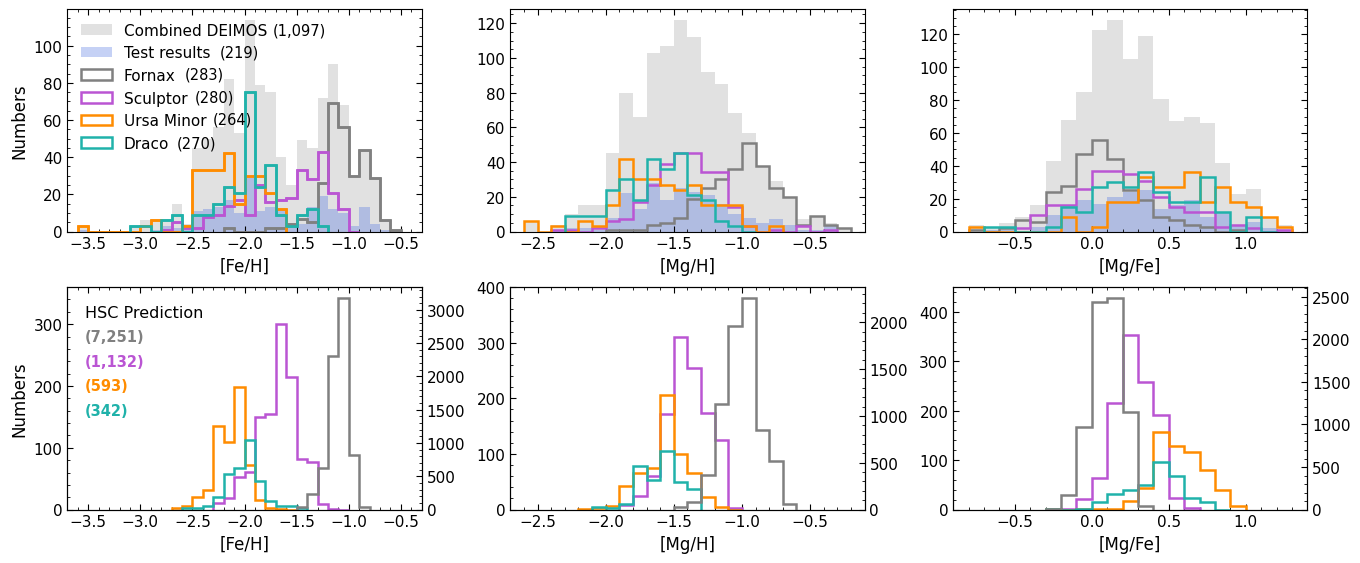

In [9]:
def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_dataset['FEH'], bins=np.arange(np.floor(np.min(test_dataset['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_dataset['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_dataset['MGH'], bins=np.arange(np.floor(np.min(test_dataset['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_dataset['MGFE'], bins=np.arange(np.floor(np.min(test_dataset['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_rfr'], [hsc_scl_mag['FEH_phot_rfr'], hsc_umi_mag['FEH_phot_rfr'], hsc_dra_mag['FEH_phot_rfr']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 360])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_rfr'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_rfr'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_rfr'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_rfr'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_rfr'], [hsc_scl_mag['MGH_phot_rfr'], hsc_umi_mag['MGH_phot_rfr'], hsc_dra_mag['MGH_phot_rfr']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_rfr'], [hsc_scl_mag['MGFE_phot_rfr'], hsc_umi_mag['MGFE_phot_rfr'], hsc_dra_mag['MGFE_phot_rfr']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.show()

In [10]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_rfr']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_rfr']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_rfr']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_rfr']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_rfr']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_rfr']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_rfr']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_rfr']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_rfr']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_rfr']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_rfr']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_rfr']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_rfr']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_rfr']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_rfr']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_rfr']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_rfr']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_rfr']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_rfr']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_rfr']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_rfr']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_rfr']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_rfr']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_rfr']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df

FEH           MGH         MGFE
fnx_mag      -1.05 ± 0.22  -0.99 ± 0.28  0.06 ± 0.25
scl_mag      -1.62 ± 0.40  -1.41 ± 0.27  0.21 ± 0.31
umi_mag      -2.16 ± 0.31  -1.59 ± 0.33  0.56 ± 0.35
dra_mag      -1.98 ± 0.33  -1.64 ± 0.27  0.34 ± 0.34
hsc_fnx_mag  -1.10 ± 0.09  -1.00 ± 0.13  0.10 ± 0.10
hsc_scl_mag  -1.68 ± 0.19  -1.40 ± 0.15  0.28 ± 0.13
hsc_umi_mag  -2.13 ± 0.15  -1.56 ± 0.16  0.57 ± 0.16
hsc_dra_mag  -2.00 ± 0.16  -1.59 ± 0.15  0.41 ± 0.17

# XGBoost

In [11]:
%%time
import xgboost as xgb

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def build_model_xgboost(n_estimators, min_child_weight, colsample_bytree):
    model = xgb.XGBRegressor(
        n_estimators = n_estimators, 
        min_child_weight = min_child_weight, 
        colsample_bytree = colsample_bytree, 
        learning_rate=0.05,
        subsample=0.8,
        random_state = 42
    )
    return model

model_xgboost = build_model_xgboost(500, 3, 0.5) #3 was supposed to be 1 / 11, 3, 0.5 are also possible

train_dataset_oob_rmse_feh_list = []
train_dataset_oob_rmse_mgh_list = []

train_dataset_rmse_feh_list = []
train_dataset_rmse_mgh_list = []
train_dataset_rsq_feh_list = []
train_dataset_rsq_mgh_list = []

test_dataset_rmse_feh_list = []
test_dataset_rmse_mgh_list = []
test_dataset_rsq_feh_list = []
test_dataset_rsq_mgh_list = []

# Iterate over each fold
for train_index, test_index in kf.split(df_mag):
    # Split into training and testing set for this fold
    train_dataset = df_mag.iloc[train_index]
    test_dataset = df_mag.iloc[test_index]

    # Train the model
#    model_xgboost.fit(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']].values,
    model_xgboost.fit(train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values,
                  train_dataset[['FEH', 'MGH']].values)

    # Predict on train and test sample
#    train_dataset_pred_values = model_xgboost.predict(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']].values)
    train_dataset_pred_values = model_xgboost.predict(train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values)
    train_dataset['FEH_phot_xgboost'], train_dataset['MGH_phot_xgboost'] = train_dataset_pred_values[:, 0], train_dataset_pred_values[:, 1]
    train_dataset['FEH_phot_xgboost_uncertainty'], train_dataset['MGH_phot_xgboost_uncertainty'] = train_dataset_pred_values[:, 0].std(axis=0), train_dataset_pred_values[:, 1].std(axis=0)

#    test_dataset_pred_values = model_xgboost.predict(test_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']].values)
    test_dataset_pred_values = model_xgboost.predict(test_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values)
    test_dataset['FEH_phot_xgboost'], test_dataset['MGH_phot_xgboost'] = test_dataset_pred_values[:, 0], test_dataset_pred_values[:, 1]
    test_dataset['FEH_phot_xgboost_uncertainty'], test_dataset['MGH_phot_xgboost_uncertainty'] = test_dataset_pred_values[:, 0].std(axis=0), test_dataset_pred_values[:, 1].std(axis=0)

    # # RMSE
    # train_dataset_rmse_feh = math.sqrt(mean_squared_error(train_dataset['FEH'].values, train_dataset['FEH_phot_xgboost'].values))
    # train_dataset_rmse_feh_list.append(np.mean(train_dataset_rmse_feh))
    # train_dataset_rmse_mgh = math.sqrt(mean_squared_error(train_dataset['MGH'].values, train_dataset['MGH_phot_xgboost'].values))
    # train_dataset_rmse_mgh_list.append(np.mean(train_dataset_rmse_mgh))
    
    # test_dataset_rmse_feh = math.sqrt(mean_squared_error(test_dataset['FEH'].values, test_dataset['FEH_phot_xgboost'].values))
    # test_dataset_rmse_feh_list.append(np.mean(test_dataset_rmse_feh))
    # test_dataset_rmse_mgh = math.sqrt(mean_squared_error(test_dataset['MGH'].values, test_dataset['MGH_phot_xgboost'].values))
    # test_dataset_rmse_mgh_list.append(np.mean(test_dataset_rmse_mgh))

    # # R^2 score
    # train_dataset_rsq_feh = r2_score(train_dataset['FEH'].values, train_dataset['FEH_phot_xgboost'].values)
    # train_dataset_rsq_feh_list.append(train_dataset_rsq_feh)
    # train_dataset_rsq_mgh = r2_score(train_dataset['MGH'].values, train_dataset['MGH_phot_xgboost'].values)
    # train_dataset_rsq_mgh_list.append(train_dataset_rsq_mgh)

    # test_dataset_rsq_feh = r2_score(test_dataset['FEH'].values, test_dataset['FEH_phot_xgboost'].values)
    # test_dataset_rsq_feh_list.append(test_dataset_rsq_feh)
    # test_dataset_rsq_mgh = r2_score(test_dataset['MGH'].values, test_dataset['MGH_phot_xgboost'].values)
    # test_dataset_rsq_mgh_list.append(test_dataset_rsq_mgh)

## Finally, get the prediction from the HSC data
#hsc_dataset_pred_values = model_xgboost.predict(hsc_df_mag[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']].values)
hsc_dataset_pred_values = model_xgboost.predict(hsc_df_mag[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values)
hsc_df_mag['FEH_phot_xgboost'], hsc_df_mag['MGH_phot_xgboost'] = hsc_dataset_pred_values[:, 0], hsc_dataset_pred_values[:, 1]
hsc_df_mag['FEH_phot_xgboost_uncertainty'], hsc_df_mag['MGH_phot_xgboost_uncertainty'] = hsc_dataset_pred_values[:, 0].std(axis=0), hsc_dataset_pred_values[:, 1].std(axis=0)

# ---------------------------------------------------------------------------------------------------------------------------------

# Predict MGFE
hsc_df_mag['MGFE_phot_xgboost'] = hsc_df_mag['MGH_phot_xgboost'] - hsc_df_mag['FEH_phot_xgboost']
hsc_df_mag['MGFE_phot_xgboost_uncertainty'] = np.sqrt(np.abs(hsc_df_mag['MGH_phot_xgboost_uncertainty']**2 + hsc_df_mag['FEH_phot_xgboost_uncertainty']**2))

# train_dataset = pd.DataFrame(columns=train_dataset.columns)
# train_dataset['Mg0'] = train_dataset['Mg0'] - train_dataset['Mg0']
# train_dataset['Mi0'] = train_dataset['Mi0'] - train_dataset['Mi0']
# train_dataset['Mn0'] = train_dataset['Mn0'] - train_dataset['Mn0']
# train_dataset['Mg0_Mi0'] = train_dataset['Mg0_Mi0'] - train_dataset['Mg0_Mi0']
# train_dataset['Mg0_Mn0'] = train_dataset['Mg0_Mn0'] - train_dataset['Mg0_Mn0']
# train_dataset['MGFE'] = train_dataset['MGH'] - train_dataset['FEH']
# train_dataset['MGFEERR'] = np.sqrt(train_dataset['MGHERR']**2 + train_dataset['FEHERR']**2)
train_dataset['MGFE_phot_xgboost'] = train_dataset['MGH_phot_xgboost'] - train_dataset['FEH_phot_xgboost']
train_dataset['MGFE_phot_xgboost_uncertainty'] = np.sqrt(train_dataset['MGH_phot_xgboost_uncertainty']**2 + train_dataset['FEH_phot_xgboost_uncertainty']**2)

# test_dataset = pd.DataFrame(columns=test_MGH.columns)
# test_dataset['Mg0'] = test_dataset['Mg0'] - test_dataset['Mg0']
# test_dataset['Mi0'] = test_dataset['Mi0'] - test_dataset['Mi0']
# test_dataset['Mn0'] = test_dataset['Mn0'] - test_dataset['Mn0']
# test_dataset['Mg0_Mi0'] = test_dataset['Mg0_Mi0'] - test_dataset['Mg0_Mi0']
# test_dataset['Mg0_Mn0'] = test_dataset['Mg0_Mn0'] - test_dataset['Mg0_Mn0']
# test_dataset['MGFE'] = test_dataset['MGH'] - test_dataset['FEH']
# test_dataset['MGFEERR'] = np.sqrt(test_dataset['MGHERR']**2 + test_dataset['FEHERR']**2)
test_dataset['MGFE_phot_xgboost'] = test_dataset['MGH_phot_xgboost'] - test_dataset['FEH_phot_xgboost']
test_dataset['MGFE_phot_xgboost_uncertainty'] = np.sqrt(test_dataset['MGH_phot_xgboost_uncertainty']**2 + test_dataset['FEH_phot_xgboost_uncertainty']**2)

#Wall time: 4.02 s

CPU times: user 3.68 s, sys: 321 ms, total: 4 s
Wall time: 6.25 s


In [12]:
train_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dra = train_dataset[train_dataset['galaxy_id'] == 3]

test_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dra = test_dataset[test_dataset['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

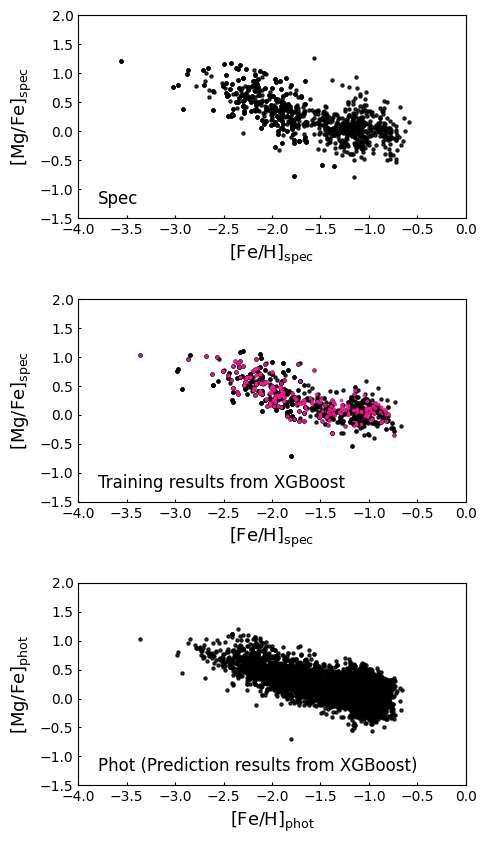

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_fnx['FEH_phot_xgboost'], train_fnx['MGFE_phot_xgboost'], s=s, alpha=alpha, color='black')
ax1.scatter(train_scl['FEH_phot_xgboost'], train_scl['MGFE_phot_xgboost'], s=s, alpha=alpha, color='black')
ax1.scatter(train_umi['FEH_phot_xgboost'], train_umi['MGFE_phot_xgboost'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dra['FEH_phot_xgboost'], train_dra['MGFE_phot_xgboost'], s=s, alpha=alpha, color='black')
ax1.scatter(test_fnx['FEH_phot_xgboost'], test_fnx['MGFE_phot_xgboost'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_scl['FEH_phot_xgboost'], test_scl['MGFE_phot_xgboost'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_umi['FEH_phot_xgboost'], test_umi['MGFE_phot_xgboost'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dra['FEH_phot_xgboost'], test_dra['MGFE_phot_xgboost'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from XGBoost', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_xgboost'], hsc_fnx_mag['MGFE_phot_xgboost'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_xgboost'], hsc_scl_mag['MGFE_phot_xgboost'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_xgboost'], hsc_umi_mag['MGFE_phot_xgboost'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_xgboost'], hsc_dra_mag['MGFE_phot_xgboost'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from XGBoost)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

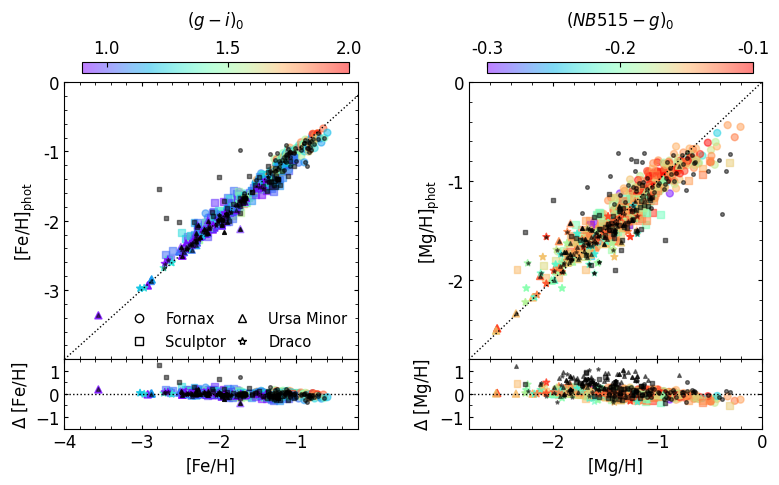

In [14]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 25 ; alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', '*']

# Training
# [Fe/H]
ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_fnx['FEH'], train_fnx['FEH_phot_xgboost'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_scl['FEH'], train_scl['FEH_phot_xgboost'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_umi['FEH'], train_umi['FEH_phot_xgboost'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dra['FEH'], train_dra['FEH_phot_xgboost'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax0.scatter(test_fnx['FEH'], test_fnx['FEH_phot_xgboost'], s=7, alpha=0.5, marker=markers[0], color='black')
ax0.scatter(test_scl['FEH'], test_scl['FEH_phot_xgboost'], s=7, alpha=0.5, marker=markers[1], color='black')
ax0.scatter(test_umi['FEH'], test_umi['FEH_phot_xgboost'], s=7, alpha=0.5, marker=markers[2], color='black')
ax0.scatter(test_dra['FEH'], test_dra['FEH_phot_xgboost'], s=7, alpha=0.5, marker=markers[3], color='black')

custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
legend = ax0.legend(handles=custom_legend, fontsize=10.5, framealpha=0, ncol=2, columnspacing=0.1)
legend.set_bbox_to_anchor((0.16, 0.12, 0.3, 0.1), transform=ax0.transAxes)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.05, 0.96, f'Training (N={len(train_FEH)}, RMSE={train_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
#ax0.text(0.05, 0.88, f'Test (N={len(test_FEH)}, RMSE={test_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(g - i)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])
#m_train, b_train = np.polyfit(train_FEH['FEH'], train_FEH['FEH_phot_xgboost'], 1)
#ax0.plot(np.linspace(xmin, xmax, 100), m_train * np.linspace(xmin, xmax, 100) + b_train, color='black', linestyle='-', linewidth=1.5, label='Train Fit')
#print('m_train =', m_train)

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_fnx['FEH'], train_fnx['FEH_phot_xgboost']-train_fnx['FEH'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_scl['FEH'], train_scl['FEH_phot_xgboost']-train_scl['FEH'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_umi['FEH'], train_umi['FEH_phot_xgboost']-train_umi['FEH'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dra['FEH'], train_dra['FEH_phot_xgboost']-train_dra['FEH'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax2.scatter(test_fnx['FEH'], test_fnx['FEH_phot_xgboost']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax2.scatter(test_scl['FEH'], test_scl['FEH_phot_xgboost']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax2.scatter(test_umi['FEH'], test_umi['FEH_phot_xgboost']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax2.scatter(test_dra['FEH'], test_dra['FEH_phot_xgboost']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.5, 1.5])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)


# Test
# [Mg/H]
xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_fnx['MGH'], train_fnx['MGH_phot_xgboost'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_scl['MGH'], train_scl['MGH_phot_xgboost'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_umi['MGH'], train_umi['MGH_phot_xgboost'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dra['MGH'], train_dra['MGH_phot_xgboost'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax1.scatter(test_fnx['MGH'], test_fnx['MGH_phot_xgboost'], s=7, alpha=0.5, marker=markers[0], color='black')
ax1.scatter(test_scl['MGH'], test_scl['MGH_phot_xgboost'], s=7, alpha=0.5, marker=markers[1], color='black')
ax1.scatter(test_umi['MGH'], test_umi['MGH_phot_xgboost'], s=7, alpha=0.5, marker=markers[2], color='black')
ax1.scatter(test_dra['MGH'], test_dra['MGH_phot_xgboost'], s=7, alpha=0.5, marker=markers[3], color='black')

ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-2, -1, 0])
ax1.set_yticklabels(['-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.05, 0.96, f'Training (N={len(train_MGH)}, RMSE={train_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
#ax1.text(0.05, 0.88, f'Test (N={len(test_MGH)}, RMSE={test_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(NB515 - g)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([-0.3, -0.2, -0.1])
cbar.ax.set_xticklabels(['-0.3', '-0.2', '-0.1'])
#m_test, b_test = np.polyfit(test_FEH['FEH'], test_FEH['FEH_phot_xgboost'], 1)
#ax1.plot(np.linspace(xmin, xmax, 100), m_test * np.linspace(xmin, xmax, 100) + b_test, color=color, linestyle='-', linewidth=1.5, label='Test Fit')
#print('m_test =', m_test)

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_fnx['MGH'], train_fnx['MGH_phot_xgboost']-train_fnx['MGH'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_scl['MGH'], train_scl['MGH_phot_xgboost']-train_scl['MGH'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_umi['MGH'], train_umi['MGH_phot_xgboost']-train_umi['MGH'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dra['MGH'], train_dra['MGH_phot_xgboost']-train_dra['MGH'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax3.scatter(test_fnx['MGH'], test_fnx['MGH_phot_xgboost']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax3.scatter(test_scl['MGH'], test_scl['MGH_phot_xgboost']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax3.scatter(test_umi['MGH'], test_umi['MGH_phot_xgboost']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax3.scatter(test_dra['MGH'], test_dra['MGH_phot_xgboost']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.5, 1.5])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()

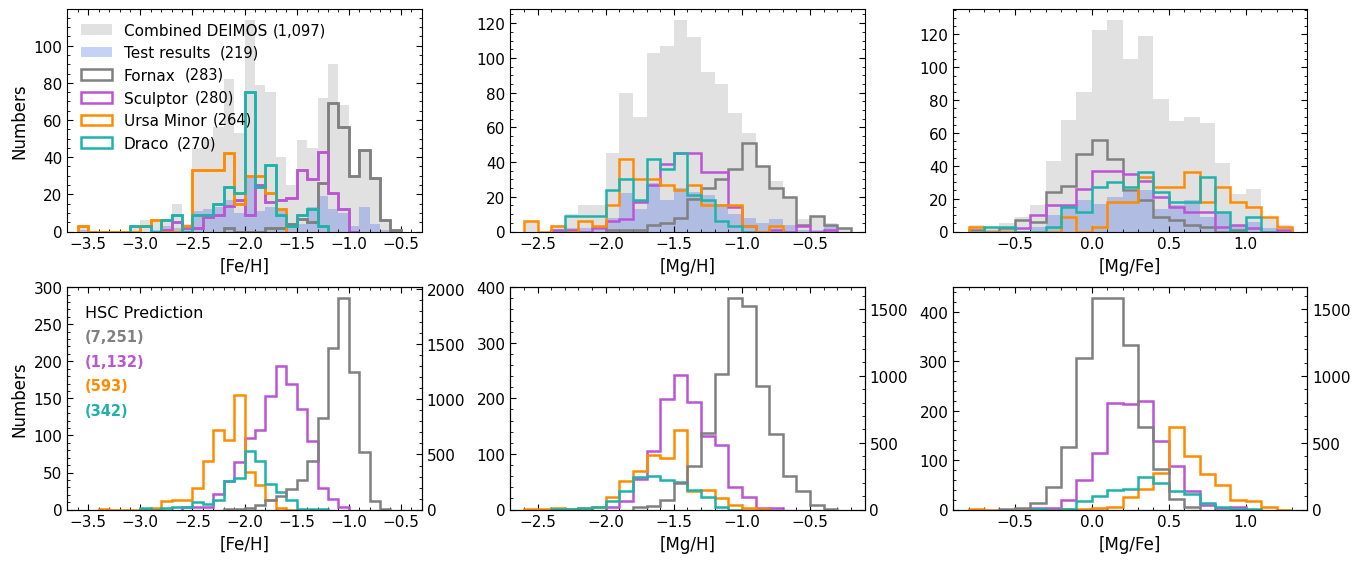

In [15]:
def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_dataset['FEH'], bins=np.arange(np.floor(np.min(test_dataset['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_dataset['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_dataset['MGH'], bins=np.arange(np.floor(np.min(test_dataset['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_dataset['MGFE'], bins=np.arange(np.floor(np.min(test_dataset['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_xgboost'], [hsc_scl_mag['FEH_phot_xgboost'], hsc_umi_mag['FEH_phot_xgboost'], hsc_dra_mag['FEH_phot_xgboost']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 300])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_xgboost'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_xgboost'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_xgboost'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_xgboost'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_xgboost'], [hsc_scl_mag['MGH_phot_xgboost'], hsc_umi_mag['MGH_phot_xgboost'], hsc_dra_mag['MGH_phot_xgboost']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_xgboost'], [hsc_scl_mag['MGFE_phot_xgboost'], hsc_umi_mag['MGFE_phot_xgboost'], hsc_dra_mag['MGFE_phot_xgboost']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.show()

In [16]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_xgboost']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_xgboost']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_xgboost']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_xgboost']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_xgboost']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_xgboost']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_xgboost']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_xgboost']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_xgboost']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_xgboost']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_xgboost']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_xgboost']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_xgboost']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_xgboost']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_xgboost']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_xgboost']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_xgboost']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_xgboost']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_xgboost']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_xgboost']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_xgboost']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_xgboost']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_xgboost']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_xgboost']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df

FEH           MGH         MGFE
fnx_mag      -1.05 ± 0.22  -0.99 ± 0.28  0.06 ± 0.25
scl_mag      -1.62 ± 0.40  -1.41 ± 0.27  0.21 ± 0.31
umi_mag      -2.16 ± 0.31  -1.59 ± 0.33  0.56 ± 0.35
dra_mag      -1.98 ± 0.33  -1.64 ± 0.27  0.34 ± 0.34
hsc_fnx_mag  -1.13 ± 0.20  -1.02 ± 0.20  0.12 ± 0.17
hsc_scl_mag  -1.69 ± 0.25  -1.41 ± 0.20  0.28 ± 0.20
hsc_umi_mag  -2.18 ± 0.21  -1.57 ± 0.22  0.60 ± 0.20
hsc_dra_mag  -1.96 ± 0.24  -1.60 ± 0.20  0.36 ± 0.23

# ANN using Tensorflow-Keras

/afs/crc.nd.edu/user/j/jhong5/.local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-17 12:22:52.388725: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,255,170 (20.05 MB)

 Trainable params: 5,255,170 (20.05 MB)

 Non-trainable params: 0 (0.00 B)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
          loss       mae       mse  val_loss   val_mae   val_mse  epoch
495  0.061037  0.187263  0.061037  0.062841  0.187682  0.062841    495
496  0.063059  0.188205  0.063059  0.060530  0.186118  0.060530    496
497  0.059467  0.183919  0.059467  0.053733  0.174333  0.053733    497
498  0.059904  0.185920  0.059904  0.055883  0.178216  0.055883    498
499  0.062043  0.187499  0.062043  0.056603  0.177398  0.056603    499


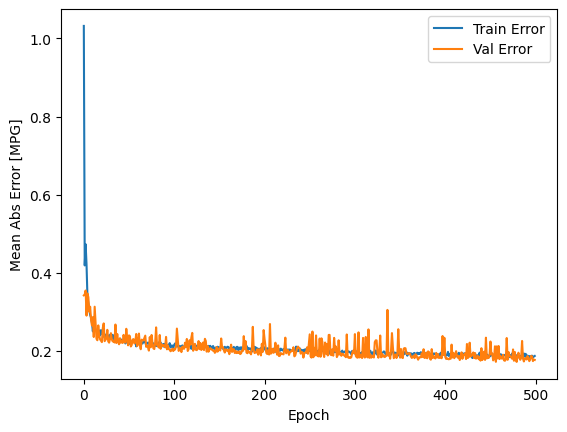

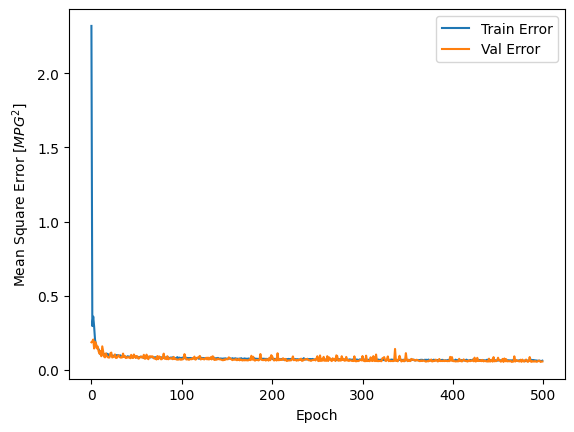

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Test R² FEH: 0.8082791445243417
Test R² MGH: 0.5594835018784534
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Training R² FEH: 0.8296961238652864
Training R² MGH: 0.5872165649916286
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
CPU times: user 4h 47min 59s, sys: 2h 1min 6s, total: 6h 49min 6s
Wall time: 18min 54s


In [30]:
%%time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)

# Try using raw mags as input params
# Try using pooling data 

def build_model_ann():
    model = keras.Sequential([
        keras.layers.Dense(1024, activation='relu', input_shape=(4,)),
        keras.layers.Dense(1024, activation='relu'),
        Dropout(0.2), #prevent overfitting
        keras.layers.Dense(1024, activation='relu'),
        Dropout(0.2),
        keras.layers.Dense(1024, activation='relu'),
        Dropout(0.2),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(2)  #FEH and MGH 
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

model_ann = build_model_ann()
model_ann.summary()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 500 #5000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)

history = model_ann.fit(train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']],
                    train_dataset[['FEH', 'MGH']],
                    epochs=EPOCHS, validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
#model_ann.save("model_ann.h5")

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n', hist.tail())

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)

# Perform Predictions
test_predictions = model_ann.predict(test_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']])
test_dataset['FEH_phot_ann'], test_dataset['MGH_phot_ann'] = test_predictions[:, 0], test_predictions[:, 1]
test_dataset['MGFE_phot_ann'] = test_dataset['MGH_phot_ann'] - test_dataset['FEH_phot_ann']
test_r2_feh = r2_score(test_dataset['FEH'], test_dataset['FEH_phot_ann'])
test_r2_mgh = r2_score(test_dataset['MGH'], test_dataset['MGH_phot_ann'])
print("Test R² FEH:", test_r2_feh) #0.806616432788651
print("Test R² MGH:", test_r2_mgh) #0.529107935326188

train_predictions = model_ann.predict(train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']])
train_dataset['FEH_phot_ann'], train_dataset['MGH_phot_ann'] = train_predictions[:, 0], train_predictions[:, 1]
train_dataset['MGFE_phot_ann'] = train_dataset['MGH_phot_ann'] - train_dataset['FEH_phot_ann']
train_r2_feh = r2_score(train_dataset['FEH'], train_dataset['FEH_phot_ann'])
train_r2_mgh = r2_score(train_dataset['MGH'], train_dataset['MGH_phot_ann'])
print("Training R² FEH:", train_r2_feh) #0.8150699771637381
print("Training R² MGH:", train_r2_mgh) #5564508616053905

hsc_predictions = model_ann.predict(hsc_df_mag[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']])
hsc_df_mag['FEH_phot_ann'], hsc_df_mag['MGH_phot_ann'] = hsc_predictions[:, 0], hsc_predictions[:, 1]
hsc_df_mag['MGFE_phot_ann'] = hsc_df_mag['MGH_phot_ann'] - hsc_df_mag['FEH_phot_ann']

#Wall time: 19min 7s

In [31]:
train_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dra = train_dataset[train_dataset['galaxy_id'] == 3]

test_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dra = test_dataset[test_dataset['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

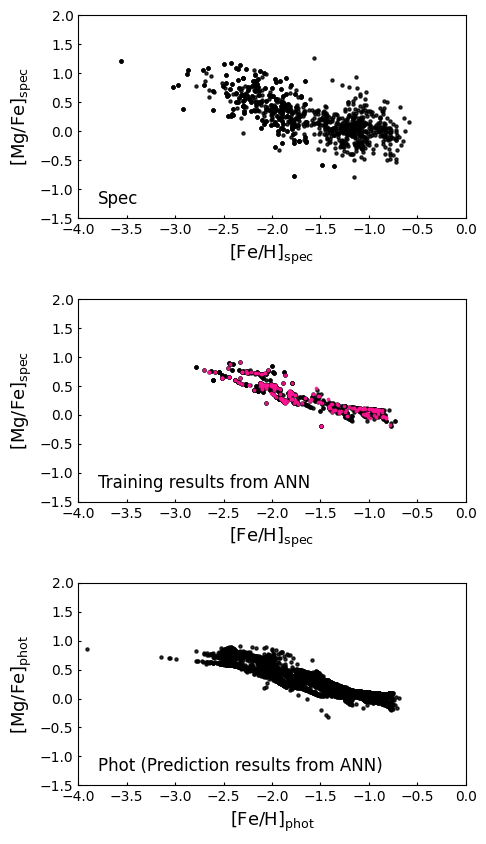

In [32]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_fnx['FEH_phot_ann'], train_fnx['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_scl['FEH_phot_ann'], train_scl['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_umi['FEH_phot_ann'], train_umi['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dra['FEH_phot_ann'], train_dra['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(test_fnx['FEH_phot_ann'], test_fnx['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_scl['FEH_phot_ann'], test_scl['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_umi['FEH_phot_ann'], test_umi['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dra['FEH_phot_ann'], test_dra['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from ANN', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from ANN)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

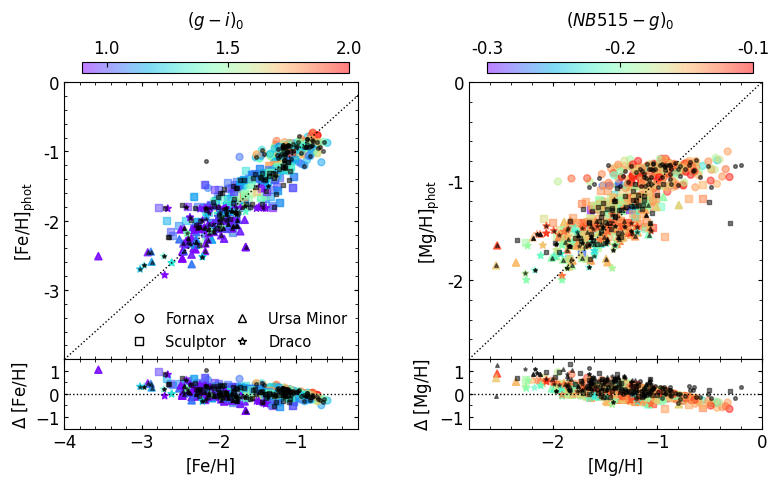

In [33]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 25 ; alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', '*']

# Training
# [Fe/H]
ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_scl['FEH'], train_scl['FEH_phot_ann'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_umi['FEH'], train_umi['FEH_phot_ann'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dra['FEH'], train_dra['FEH_phot_ann'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax0.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann'], s=7, alpha=0.5, marker=markers[0], color='black')
ax0.scatter(test_scl['FEH'], test_scl['FEH_phot_ann'], s=7, alpha=0.5, marker=markers[1], color='black')
ax0.scatter(test_umi['FEH'], test_umi['FEH_phot_ann'], s=7, alpha=0.5, marker=markers[2], color='black')
ax0.scatter(test_dra['FEH'], test_dra['FEH_phot_ann'], s=7, alpha=0.5, marker=markers[3], color='black')

custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
legend = ax0.legend(handles=custom_legend, fontsize=10.5, framealpha=0, ncol=2, columnspacing=0.1)
legend.set_bbox_to_anchor((0.16, 0.12, 0.3, 0.1), transform=ax0.transAxes)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.05, 0.96, f'Training (N={len(train_FEH)}, RMSE={train_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
#ax0.text(0.05, 0.88, f'Test (N={len(test_FEH)}, RMSE={test_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(g - i)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])
#m_train, b_train = np.polyfit(train_FEH['FEH'], train_FEH['FEH_phot_ann'], 1)
#ax0.plot(np.linspace(xmin, xmax, 100), m_train * np.linspace(xmin, xmax, 100) + b_train, color='black', linestyle='-', linewidth=1.5, label='Train Fit')
#print('m_train =', m_train)

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann']-train_fnx['FEH'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_scl['FEH'], train_scl['FEH_phot_ann']-train_scl['FEH'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_umi['FEH'], train_umi['FEH_phot_ann']-train_umi['FEH'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dra['FEH'], train_dra['FEH_phot_ann']-train_dra['FEH'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax2.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax2.scatter(test_scl['FEH'], test_scl['FEH_phot_ann']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax2.scatter(test_umi['FEH'], test_umi['FEH_phot_ann']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax2.scatter(test_dra['FEH'], test_dra['FEH_phot_ann']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.5, 1.5])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)


# Test
# [Mg/H]
xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_scl['MGH'], train_scl['MGH_phot_ann'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_umi['MGH'], train_umi['MGH_phot_ann'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dra['MGH'], train_dra['MGH_phot_ann'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax1.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann'], s=7, alpha=0.5, marker=markers[0], color='black')
ax1.scatter(test_scl['MGH'], test_scl['MGH_phot_ann'], s=7, alpha=0.5, marker=markers[1], color='black')
ax1.scatter(test_umi['MGH'], test_umi['MGH_phot_ann'], s=7, alpha=0.5, marker=markers[2], color='black')
ax1.scatter(test_dra['MGH'], test_dra['MGH_phot_ann'], s=7, alpha=0.5, marker=markers[3], color='black')

ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-2, -1, 0])
ax1.set_yticklabels(['-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.05, 0.96, f'Training (N={len(train_MGH)}, RMSE={train_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
#ax1.text(0.05, 0.88, f'Test (N={len(test_MGH)}, RMSE={test_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(NB515 - g)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([-0.3, -0.2, -0.1])
cbar.ax.set_xticklabels(['-0.3', '-0.2', '-0.1'])
#m_test, b_test = np.polyfit(test_FEH['FEH'], test_FEH['FEH_phot_ann'], 1)
#ax1.plot(np.linspace(xmin, xmax, 100), m_test * np.linspace(xmin, xmax, 100) + b_test, color=color, linestyle='-', linewidth=1.5, label='Test Fit')
#print('m_test =', m_test)

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann']-train_fnx['MGH'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_scl['MGH'], train_scl['MGH_phot_ann']-train_scl['MGH'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_umi['MGH'], train_umi['MGH_phot_ann']-train_umi['MGH'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dra['MGH'], train_dra['MGH_phot_ann']-train_dra['MGH'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax3.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax3.scatter(test_scl['MGH'], test_scl['MGH_phot_ann']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax3.scatter(test_umi['MGH'], test_umi['MGH_phot_ann']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax3.scatter(test_dra['MGH'], test_dra['MGH_phot_ann']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.5, 1.5])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()

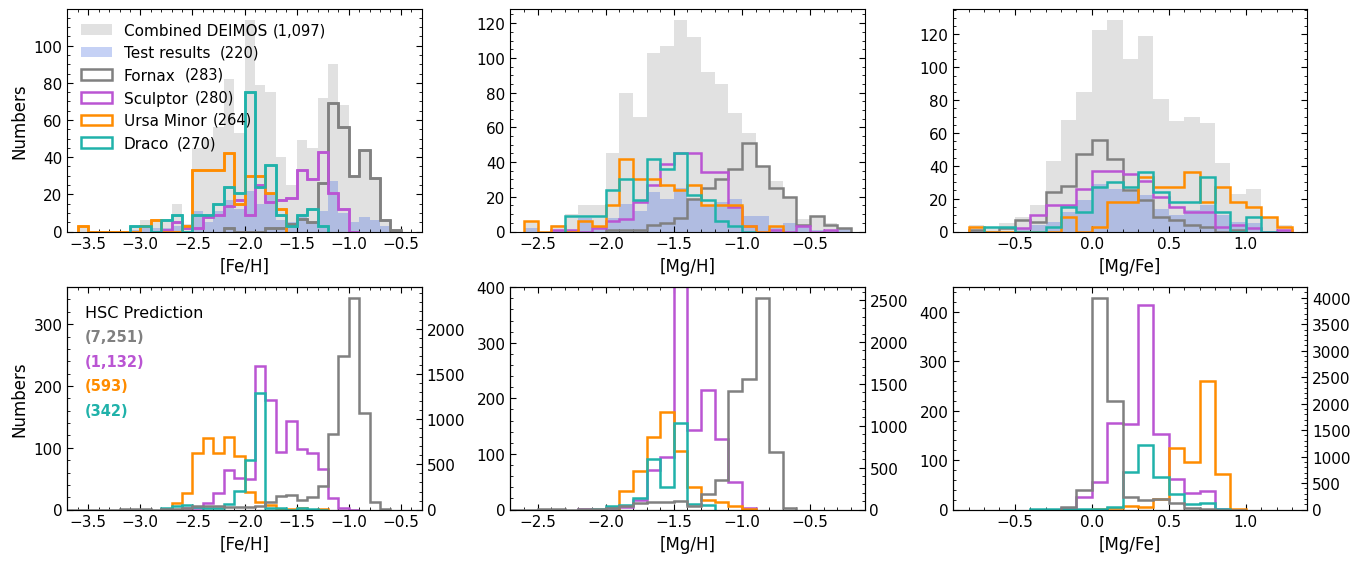

In [34]:
def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_dataset['FEH'], bins=np.arange(np.floor(np.min(test_dataset['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_dataset['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_dataset['MGH'], bins=np.arange(np.floor(np.min(test_dataset['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_dataset['MGFE'], bins=np.arange(np.floor(np.min(test_dataset['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_ann'], [hsc_scl_mag['FEH_phot_ann'], hsc_umi_mag['FEH_phot_ann'], hsc_dra_mag['FEH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 360])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_ann'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_ann'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_ann'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_ann'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_ann'], [hsc_scl_mag['MGH_phot_ann'], hsc_umi_mag['MGH_phot_ann'], hsc_dra_mag['MGH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_ann'], [hsc_scl_mag['MGFE_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], hsc_dra_mag['MGFE_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.show()

In [35]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_ann']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_ann']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_ann']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_ann']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_ann']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_ann']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_ann']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_ann']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_ann']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_ann']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_ann']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_ann']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_ann']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_ann']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_ann']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_ann']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_ann']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_ann']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_ann']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_ann']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_ann']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_ann']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_ann']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_ann']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df

FEH           MGH         MGFE
fnx_mag      -1.05 ± 0.22  -0.99 ± 0.28  0.06 ± 0.25
scl_mag      -1.62 ± 0.40  -1.41 ± 0.27  0.21 ± 0.31
umi_mag      -2.16 ± 0.31  -1.59 ± 0.33  0.56 ± 0.35
dra_mag      -1.98 ± 0.33  -1.64 ± 0.27  0.34 ± 0.34
hsc_fnx_mag  -1.09 ± 0.31  -0.98 ± 0.22  0.12 ± 0.11
hsc_scl_mag  -1.70 ± 0.27  -1.37 ± 0.16  0.33 ± 0.17
hsc_umi_mag  -2.24 ± 0.20  -1.56 ± 0.16  0.68 ± 0.13
hsc_dra_mag  -1.93 ± 0.19  -1.55 ± 0.13  0.38 ± 0.14

# ANN using PyTorch

ANNModel(
  (fc1): Linear(in_features=4, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 0/500:
....................................................................................................
Epoch 100/500:
....................................................................................................
Epoch 200/500:
....................................................................................................
Epoch 300/500:
....................................................................................................
Epoch 400/500:
.........................

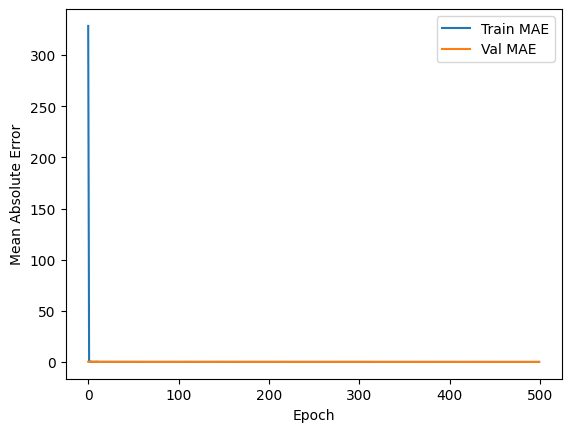

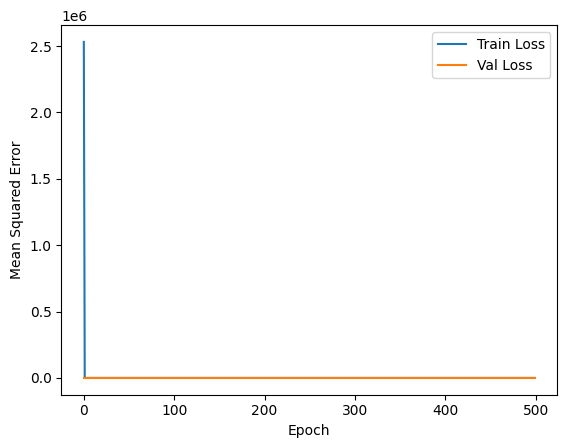

Test R² FEH: 0.7624674049958027
Test R² MGH: 0.5334308102627813
Train R² FEH: 0.820221262401606
Train R² MGH: 0.5775159424089678
CPU times: user 1h 6min 3s, sys: 0 ns, total: 1h 6min 3s
Wall time: 1h 6min 53s


In [36]:
%%time
import torch
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import r2_score

# 1. Split the data
train_df_full, test_df = train_test_split(df_mag, test_size=0.2, random_state=42)
# Set the validation (training) sample
train_df, val_df = train_test_split(train_df_full, test_size=0.2, random_state=42)

# Input features
feature_cols = ['Mg0', 'Mi0', 'Mn0', 'galaxy_id']
target_cols  = ['FEH', 'MGH']

# Conversion Tensor (dtype: float32)
x_train = torch.tensor(train_df[feature_cols].values, dtype=torch.float32)
y_train = torch.tensor(train_df[target_cols].values, dtype=torch.float32)
x_val   = torch.tensor(val_df[feature_cols].values, dtype=torch.float32)
y_val   = torch.tensor(val_df[target_cols].values, dtype=torch.float32)
x_test  = torch.tensor(test_df[feature_cols].values, dtype=torch.float32)

# Make TensorDataset and DataLoader
batch_size = 32
train_data = TensorDataset(x_train, y_train)
val_data   = TensorDataset(x_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# 2. Define model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(4, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.fc6 = nn.Linear(1024, 1024)
        self.fc7 = nn.Linear(1024, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

model = ANNModel()
print(model)

# 3. Set the optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 4. Learning loop with Early Stopping
EPOCHS = 500
patience = 500
best_val_loss = float('inf')
epochs_no_improve = 0

# Make lists to save the learning/validation/MAE
train_losses, val_losses = [], []
train_mae, val_mae = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_mae += torch.mean(torch.abs(outputs - targets)).item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_mae = running_mae / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_mae.append(epoch_mae)
    
    # Validation 단계
    model.eval()
    val_running_loss = 0.0
    val_running_mae = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_mae += torch.mean(torch.abs(outputs - targets)).item() * inputs.size(0)
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_mae = val_running_mae / len(val_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_mae.append(val_epoch_mae)
    
    # Go to the new line every 100 epoch
    if epoch % 100 == 0:
        print(f"\nEpoch {epoch}/{EPOCHS}:")
    print('.', end='')
    
    # Early Stopping: Validation loss가 개선되면 모델 저장
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= patience:
        print("\nEarly stopping at epoch", epoch)
        break

print('\nTraining complete.')

# 5. Visualize learning process
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.legend()
plt.show()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

# 6. Get prediction
# Load the best model parameters in modeling
model.load_state_dict(best_model_state)
model.eval()

with torch.no_grad():
    # Predict test sample
    test_preds = model(x_test).numpy()
    # Predict training sample
    x_train_full = torch.tensor(train_df_full[feature_cols].values, dtype=torch.float32)
    train_preds = model(x_train_full).numpy()
    # Predict HSC sample
    x_hsc = torch.tensor(hsc_df_mag[feature_cols].values, dtype=torch.float32)
    hsc_preds = model(x_hsc).numpy()

# Save the prediction to the dataframe
test_df['FEH_phot_ann_pytorch'] = test_preds[:, 0]
test_df['MGH_phot_ann_pytorch'] = test_preds[:, 1]
test_df['MGFE_phot_ann_pytorch'] = test_df['MGH_phot_ann_pytorch'] - test_df['FEH_phot_ann_pytorch']
test_r2_feh = r2_score(test_df['FEH'], test_df['FEH_phot_ann_pytorch'])
test_r2_mgh = r2_score(test_df['MGH'], test_df['MGH_phot_ann_pytorch'])
print("Test R² FEH:", test_r2_feh) #0.815008339307173
print("Test R² MGH:", test_r2_mgh) #0.5254389210725939

train_df_full['FEH_phot_ann_pytorch'] = train_preds[:, 0]
train_df_full['MGH_phot_ann_pytorch'] = train_preds[:, 1]
train_df_full['MGFE_phot_ann_pytorch'] = train_df_full['MGH_phot_ann_pytorch'] - train_df_full['FEH_phot_ann_pytorch']
train_r2_feh = r2_score(train_df_full['FEH'], train_df_full['FEH_phot_ann_pytorch'])
train_r2_mgh = r2_score(train_df_full['MGH'], train_df_full['MGH_phot_ann_pytorch'])
print("Train R² FEH:", train_r2_feh) #0.8480162867595313
print("Train R² MGH:", train_r2_mgh) #0.5901053333337637

hsc_df_mag['FEH_phot_ann_pytorch'] = hsc_preds[:, 0]
hsc_df_mag['MGH_phot_ann_pytorch'] = hsc_preds[:, 1]
hsc_df_mag['MGFE_phot_ann_pytorch'] = hsc_df_mag['MGH_phot_ann_pytorch'] - hsc_df_mag['FEH_phot_ann_pytorch']

#Wall time: 1h 4min 5s

In [37]:
train_fnx = train_df_full[train_df_full['galaxy_id'] == 0]
train_scl = train_df_full[train_df_full['galaxy_id'] == 1]
train_umi = train_df_full[train_df_full['galaxy_id'] == 2]
train_dra = train_df_full[train_df_full['galaxy_id'] == 3]

test_fnx = test_df[test_df['galaxy_id'] == 0]
test_scl = test_df[test_df['galaxy_id'] == 1]
test_umi = test_df[test_df['galaxy_id'] == 2]
test_dra = test_df[test_df['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

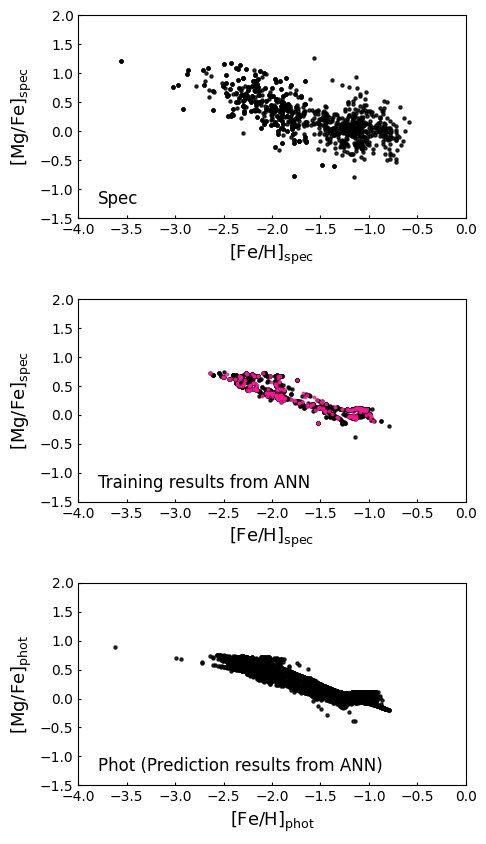

In [38]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_fnx['FEH_phot_ann_pytorch'], train_fnx['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax1.scatter(train_scl['FEH_phot_ann_pytorch'], train_scl['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax1.scatter(train_umi['FEH_phot_ann_pytorch'], train_umi['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dra['FEH_phot_ann_pytorch'], train_dra['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax1.scatter(test_fnx['FEH_phot_ann_pytorch'], test_fnx['MGFE_phot_ann_pytorch'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_scl['FEH_phot_ann_pytorch'], test_scl['MGFE_phot_ann_pytorch'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_umi['FEH_phot_ann_pytorch'], test_umi['MGFE_phot_ann_pytorch'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dra['FEH_phot_ann_pytorch'], test_dra['MGFE_phot_ann_pytorch'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from ANN', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_ann_pytorch'], hsc_fnx_mag['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_ann_pytorch'], hsc_scl_mag['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_ann_pytorch'], hsc_umi_mag['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_ann_pytorch'], hsc_dra_mag['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from ANN)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

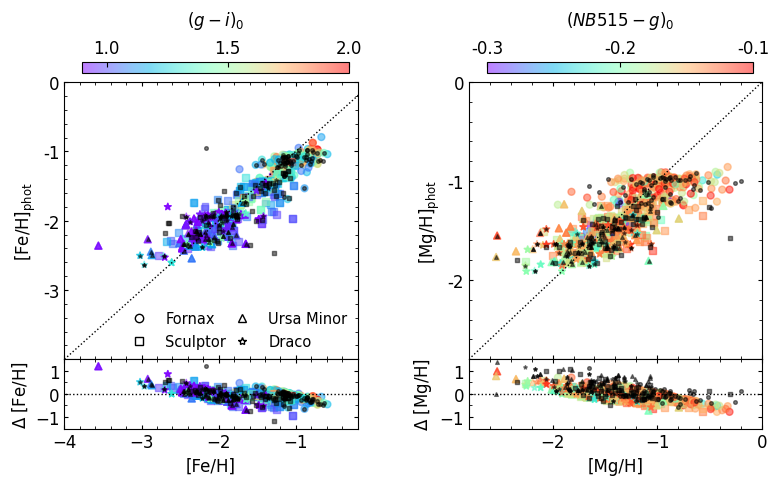

In [39]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 25 ; alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', '*']

# Training
# [Fe/H]
ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_scl['FEH'], train_scl['FEH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_umi['FEH'], train_umi['FEH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dra['FEH'], train_dra['FEH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax0.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[0], color='black')
ax0.scatter(test_scl['FEH'], test_scl['FEH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[1], color='black')
ax0.scatter(test_umi['FEH'], test_umi['FEH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[2], color='black')
ax0.scatter(test_dra['FEH'], test_dra['FEH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[3], color='black')

custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
legend = ax0.legend(handles=custom_legend, fontsize=10.5, framealpha=0, ncol=2, columnspacing=0.1)
legend.set_bbox_to_anchor((0.16, 0.12, 0.3, 0.1), transform=ax0.transAxes)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.05, 0.96, f'Training (N={len(train_FEH)}, RMSE={train_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
#ax0.text(0.05, 0.88, f'Test (N={len(test_FEH)}, RMSE={test_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(g - i)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])
#m_train, b_train = np.polyfit(train_FEH['FEH'], train_FEH['FEH_phot_ann_pytorch'], 1)
#ax0.plot(np.linspace(xmin, xmax, 100), m_train * np.linspace(xmin, xmax, 100) + b_train, color='black', linestyle='-', linewidth=1.5, label='Train Fit')
#print('m_train =', m_train)

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann_pytorch']-train_fnx['FEH'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_scl['FEH'], train_scl['FEH_phot_ann_pytorch']-train_scl['FEH'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_umi['FEH'], train_umi['FEH_phot_ann_pytorch']-train_umi['FEH'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dra['FEH'], train_dra['FEH_phot_ann_pytorch']-train_dra['FEH'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax2.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann_pytorch']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax2.scatter(test_scl['FEH'], test_scl['FEH_phot_ann_pytorch']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax2.scatter(test_umi['FEH'], test_umi['FEH_phot_ann_pytorch']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax2.scatter(test_dra['FEH'], test_dra['FEH_phot_ann_pytorch']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.5, 1.5])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)


# Test
# [Mg/H]
xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_scl['MGH'], train_scl['MGH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_umi['MGH'], train_umi['MGH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dra['MGH'], train_dra['MGH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax1.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[0], color='black')
ax1.scatter(test_scl['MGH'], test_scl['MGH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[1], color='black')
ax1.scatter(test_umi['MGH'], test_umi['MGH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[2], color='black')
ax1.scatter(test_dra['MGH'], test_dra['MGH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[3], color='black')

ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-2, -1, 0])
ax1.set_yticklabels(['-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.05, 0.96, f'Training (N={len(train_MGH)}, RMSE={train_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
#ax1.text(0.05, 0.88, f'Test (N={len(test_MGH)}, RMSE={test_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(NB515 - g)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([-0.3, -0.2, -0.1])
cbar.ax.set_xticklabels(['-0.3', '-0.2', '-0.1'])
#m_test, b_test = np.polyfit(test_FEH['MGH'], test_FEH['MGH_phot_ann_pytorch'], 1)
#ax1.plot(np.linspace(xmin, xmax, 100), m_test * np.linspace(xmin, xmax, 100) + b_test, color=color, linestyle='-', linewidth=1.5, label='Test Fit')
#print('m_test =', m_test)

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann_pytorch']-train_fnx['MGH'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_scl['MGH'], train_scl['MGH_phot_ann_pytorch']-train_scl['MGH'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_umi['MGH'], train_umi['MGH_phot_ann_pytorch']-train_umi['MGH'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dra['MGH'], train_dra['MGH_phot_ann_pytorch']-train_dra['MGH'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax3.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann_pytorch']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax3.scatter(test_scl['MGH'], test_scl['MGH_phot_ann_pytorch']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax3.scatter(test_umi['MGH'], test_umi['MGH_phot_ann_pytorch']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax3.scatter(test_dra['MGH'], test_dra['MGH_phot_ann_pytorch']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.5, 1.5])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()

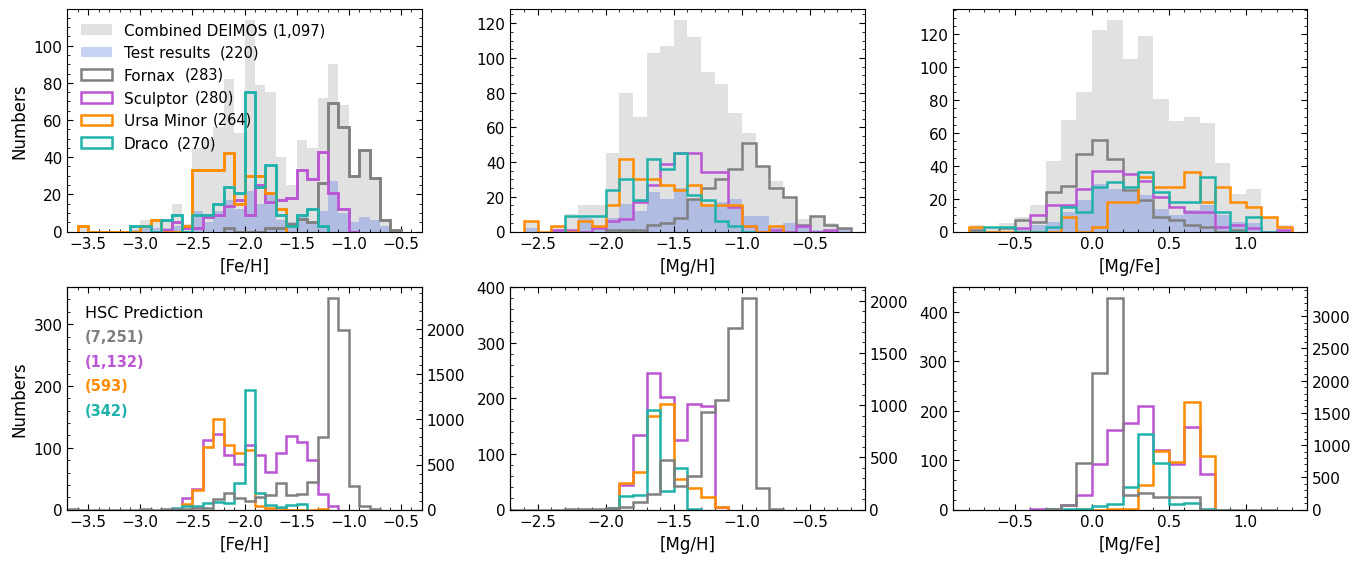

In [40]:
def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_dataset['FEH'], bins=np.arange(np.floor(np.min(test_dataset['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_dataset['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_dataset['MGH'], bins=np.arange(np.floor(np.min(test_dataset['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_dataset['MGFE'], bins=np.arange(np.floor(np.min(test_dataset['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_ann_pytorch'], [hsc_scl_mag['FEH_phot_ann_pytorch'], hsc_umi_mag['FEH_phot_ann_pytorch'], hsc_dra_mag['FEH_phot_ann_pytorch']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 360])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_ann_pytorch'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_ann_pytorch'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_ann_pytorch'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_ann_pytorch'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_ann_pytorch'], [hsc_scl_mag['MGH_phot_ann_pytorch'], hsc_umi_mag['MGH_phot_ann_pytorch'], hsc_dra_mag['MGH_phot_ann_pytorch']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_ann_pytorch'], [hsc_scl_mag['MGFE_phot_ann_pytorch'], hsc_umi_mag['MGFE_phot_ann_pytorch'], hsc_dra_mag['MGFE_phot_ann_pytorch']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.show()

In [41]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_ann_pytorch']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_ann_pytorch']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_ann_pytorch']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_ann_pytorch']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_ann_pytorch']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_ann_pytorch']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_ann_pytorch']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_ann_pytorch']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_ann_pytorch']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_ann_pytorch']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_ann_pytorch']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_ann_pytorch']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_ann_pytorch']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_ann_pytorch']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_ann_pytorch']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df

FEH           MGH         MGFE
fnx_mag      -1.05 ± 0.22  -0.99 ± 0.28  0.06 ± 0.25
scl_mag      -1.62 ± 0.40  -1.41 ± 0.27  0.21 ± 0.31
umi_mag      -2.16 ± 0.31  -1.59 ± 0.33  0.56 ± 0.35
dra_mag      -1.98 ± 0.33  -1.64 ± 0.27  0.34 ± 0.34
hsc_fnx_mag  -1.27 ± 0.32  -1.14 ± 0.21  0.13 ± 0.15
hsc_scl_mag  -1.87 ± 0.35  -1.51 ± 0.17  0.36 ± 0.22
hsc_umi_mag  -2.18 ± 0.17  -1.59 ± 0.14  0.59 ± 0.12
hsc_dra_mag  -1.98 ± 0.19  -1.61 ± 0.12  0.36 ± 0.12

# ANN using Scikit-learn

Iteration 1, loss = 0.96554110
Validation score: -1.930730
Iteration 2, loss = 0.45239626
Validation score: -3.205725
Iteration 3, loss = 0.25279544
Validation score: -1.142763
Iteration 4, loss = 0.15412551
Validation score: 0.128850
Iteration 5, loss = 0.10244737
Validation score: 0.097528
Iteration 6, loss = 0.07159718
Validation score: 0.165028
Iteration 7, loss = 0.07072626
Validation score: 0.353938
Iteration 8, loss = 0.06250021
Validation score: 0.382271
Iteration 9, loss = 0.05506720
Validation score: 0.390369
Iteration 10, loss = 0.05287836
Validation score: 0.421780
Iteration 11, loss = 0.05277153
Validation score: 0.440653
Iteration 12, loss = 0.04908153
Validation score: 0.453218
Iteration 13, loss = 0.04899808
Validation score: 0.470553
Iteration 14, loss = 0.04828458
Validation score: 0.476914
Iteration 15, loss = 0.04732856
Validation score: 0.493608
Iteration 16, loss = 0.04774068
Validation score: 0.492260
Iteration 17, loss = 0.04522026
Validation score: 0.504269
Ite

/afs/crc.nd.edu/user/j/jhong5/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


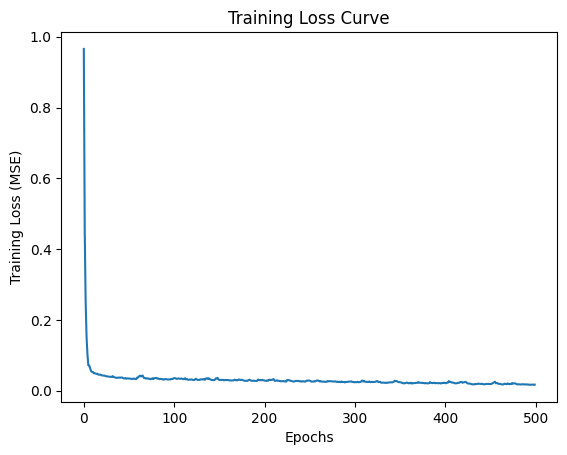

Train R² FEH: 0.8513257108892365
Train R² MGH: 0.6146970601968422
Train R² FEH: 0.8936105375816472
Train R² MGH: 0.6861262063708807
CPU times: user 18min 20s, sys: 0 ns, total: 18min 20s
Wall time: 18min 21s


In [42]:
%%time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Split the data
train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)

# Input features
features = ['Mg0', 'Mi0', 'Mn0', 'galaxy_id']
targets  = ['FEH', 'MGH']

X_train = train_dataset[features]
y_train = train_dataset[targets]

# Make a model using MLPRegressor of Scikit-learn
# 5 hidden layers with 1024 units, activating relu
model_ann = MLPRegressor(hidden_layer_sizes=(1024, 1024, 1024, 1024, 1024),
                         activation='relu',
                         solver='adam',             # RMSprop과 유사한 최적화 알고리즘으로 adam 사용
                         learning_rate_init=0.001,
                         max_iter=500,              # 최대 에포크 수
                         early_stopping=True,       # 내부 validation split 사용
                         validation_fraction=0.2,   # train 데이터 중 20%를 validation으로 사용
                         n_iter_no_change=500,      # patience에 해당 (개선 없을 시 조기 종료)
                         random_state=42,
                         verbose=True)

# Make a model
model_ann.fit(X_train, y_train)

# 학습 과정 시각화 (loss_curve_는 훈련 손실 MSE 기록)
plt.figure()
plt.plot(model_ann.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Curve')
plt.show()

# Get predictions
# Save the predictions to the test samples
X_test = test_dataset[features]
test_predictions = model_ann.predict(X_test)
test_dataset['FEH_phot_ann_sklearn'] = test_predictions[:, 0]
test_dataset['MGH_phot_ann_sklearn'] = test_predictions[:, 1]
test_dataset['MGFE_phot_ann_sklearn'] = test_dataset['MGH_phot_ann_sklearn'] - test_dataset['FEH_phot_ann_sklearn']
test_r2_feh = r2_score(test_dataset['FEH'], test_dataset['FEH_phot_ann_sklearn'])
test_r2_mgh = r2_score(test_dataset['MGH'], test_dataset['MGH_phot_ann_sklearn'])
print("Train R² FEH:", test_r2_feh) #0.8513257108892365
print("Train R² MGH:", test_r2_mgh) #0.6146970601968422

# Save the predictions to the training samples
train_predictions = model_ann.predict(X_train)
train_dataset['FEH_phot_ann_sklearn'] = train_predictions[:, 0]
train_dataset['MGH_phot_ann_sklearn'] = train_predictions[:, 1]
train_dataset['MGFE_phot_ann_sklearn'] = train_dataset['MGH_phot_ann_sklearn'] - train_dataset['FEH_phot_ann_sklearn']
train_r2_feh = r2_score(train_dataset['FEH'], train_dataset['FEH_phot_ann_sklearn'])
train_r2_mgh = r2_score(train_dataset['MGH'], train_dataset['MGH_phot_ann_sklearn'])
print("Train R² FEH:", train_r2_feh) #0.8936105375816472
print("Train R² MGH:", train_r2_mgh) #0.6861262063708807

# Save the predictions to the HSC samples
X_hsc = hsc_df_mag[features]
hsc_predictions = model_ann.predict(X_hsc)
hsc_df_mag['FEH_phot_ann_sklearn'] = hsc_predictions[:, 0]
hsc_df_mag['MGH_phot_ann_sklearn'] = hsc_predictions[:, 1]
hsc_df_mag['MGFE_phot_ann_sklearn'] = hsc_df_mag['MGH_phot_ann_sklearn'] - hsc_df_mag['FEH_phot_ann_sklearn']

#Wall time: 17min 47s

In [43]:
train_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dra = train_dataset[train_dataset['galaxy_id'] == 3]

test_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dra = test_dataset[test_dataset['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

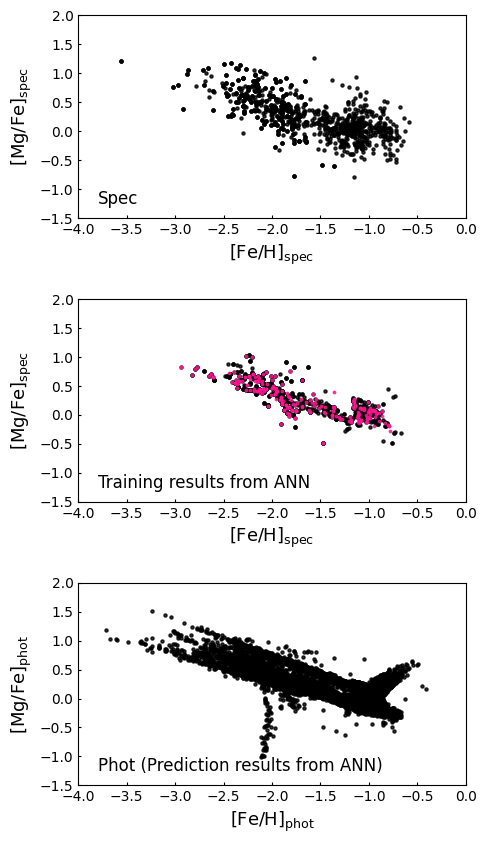

In [44]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_fnx['FEH_phot_ann_sklearn'], train_fnx['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax1.scatter(train_scl['FEH_phot_ann_sklearn'], train_scl['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax1.scatter(train_umi['FEH_phot_ann_sklearn'], train_umi['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dra['FEH_phot_ann_sklearn'], train_dra['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax1.scatter(test_fnx['FEH_phot_ann_sklearn'], test_fnx['MGFE_phot_ann_sklearn'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_scl['FEH_phot_ann_sklearn'], test_scl['MGFE_phot_ann_sklearn'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_umi['FEH_phot_ann_sklearn'], test_umi['MGFE_phot_ann_sklearn'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dra['FEH_phot_ann_sklearn'], test_dra['MGFE_phot_ann_sklearn'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from ANN', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_ann_sklearn'], hsc_fnx_mag['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_ann_sklearn'], hsc_scl_mag['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_ann_sklearn'], hsc_umi_mag['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_ann_sklearn'], hsc_dra_mag['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from ANN)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

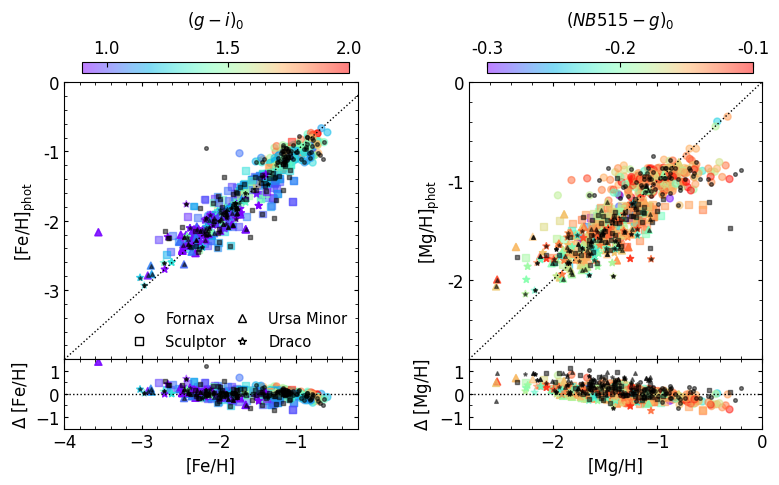

In [45]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 25 ; alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', '*']

# Training
# [Fe/H]
ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_scl['FEH'], train_scl['FEH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_umi['FEH'], train_umi['FEH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dra['FEH'], train_dra['FEH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax0.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[0], color='black')
ax0.scatter(test_scl['FEH'], test_scl['FEH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[1], color='black')
ax0.scatter(test_umi['FEH'], test_umi['FEH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[2], color='black')
ax0.scatter(test_dra['FEH'], test_dra['FEH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[3], color='black')

custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
legend = ax0.legend(handles=custom_legend, fontsize=10.5, framealpha=0, ncol=2, columnspacing=0.1)
legend.set_bbox_to_anchor((0.16, 0.12, 0.3, 0.1), transform=ax0.transAxes)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.05, 0.96, f'Training (N={len(train_FEH)}, RMSE={train_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
#ax0.text(0.05, 0.88, f'Test (N={len(test_FEH)}, RMSE={test_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(g - i)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])
#m_train, b_train = np.polyfit(train_FEH['FEH'], train_FEH['FEH_phot_ann_sklearn'], 1)
#ax0.plot(np.linspace(xmin, xmax, 100), m_train * np.linspace(xmin, xmax, 100) + b_train, color='black', linestyle='-', linewidth=1.5, label='Train Fit')
#print('m_train =', m_train)

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann_sklearn']-train_fnx['FEH'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_scl['FEH'], train_scl['FEH_phot_ann_sklearn']-train_scl['FEH'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_umi['FEH'], train_umi['FEH_phot_ann_sklearn']-train_umi['FEH'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dra['FEH'], train_dra['FEH_phot_ann_sklearn']-train_dra['FEH'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax2.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann_sklearn']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax2.scatter(test_scl['FEH'], test_scl['FEH_phot_ann_sklearn']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax2.scatter(test_umi['FEH'], test_umi['FEH_phot_ann_sklearn']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax2.scatter(test_dra['FEH'], test_dra['FEH_phot_ann_sklearn']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.5, 1.5])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)


# Test
# [Mg/H]
xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_scl['MGH'], train_scl['MGH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_umi['MGH'], train_umi['MGH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dra['MGH'], train_dra['MGH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax1.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[0], color='black')
ax1.scatter(test_scl['MGH'], test_scl['MGH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[1], color='black')
ax1.scatter(test_umi['MGH'], test_umi['MGH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[2], color='black')
ax1.scatter(test_dra['MGH'], test_dra['MGH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[3], color='black')

ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-2, -1, 0])
ax1.set_yticklabels(['-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.05, 0.96, f'Training (N={len(train_MGH)}, RMSE={train_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
#ax1.text(0.05, 0.88, f'Test (N={len(test_MGH)}, RMSE={test_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(NB515 - g)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([-0.3, -0.2, -0.1])
cbar.ax.set_xticklabels(['-0.3', '-0.2', '-0.1'])
#m_test, b_test = np.polyfit(test_FEH['MGH'], test_FEH['MGH_phot_ann_sklearn'], 1)
#ax1.plot(np.linspace(xmin, xmax, 100), m_test * np.linspace(xmin, xmax, 100) + b_test, color=color, linestyle='-', linewidth=1.5, label='Test Fit')
#print('m_test =', m_test)

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann_sklearn']-train_fnx['MGH'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_scl['MGH'], train_scl['MGH_phot_ann_sklearn']-train_scl['MGH'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_umi['MGH'], train_umi['MGH_phot_ann_sklearn']-train_umi['MGH'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dra['MGH'], train_dra['MGH_phot_ann_sklearn']-train_dra['MGH'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax3.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann_sklearn']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax3.scatter(test_scl['MGH'], test_scl['MGH_phot_ann_sklearn']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax3.scatter(test_umi['MGH'], test_umi['MGH_phot_ann_sklearn']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax3.scatter(test_dra['MGH'], test_dra['MGH_phot_ann_sklearn']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.5, 1.5])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()

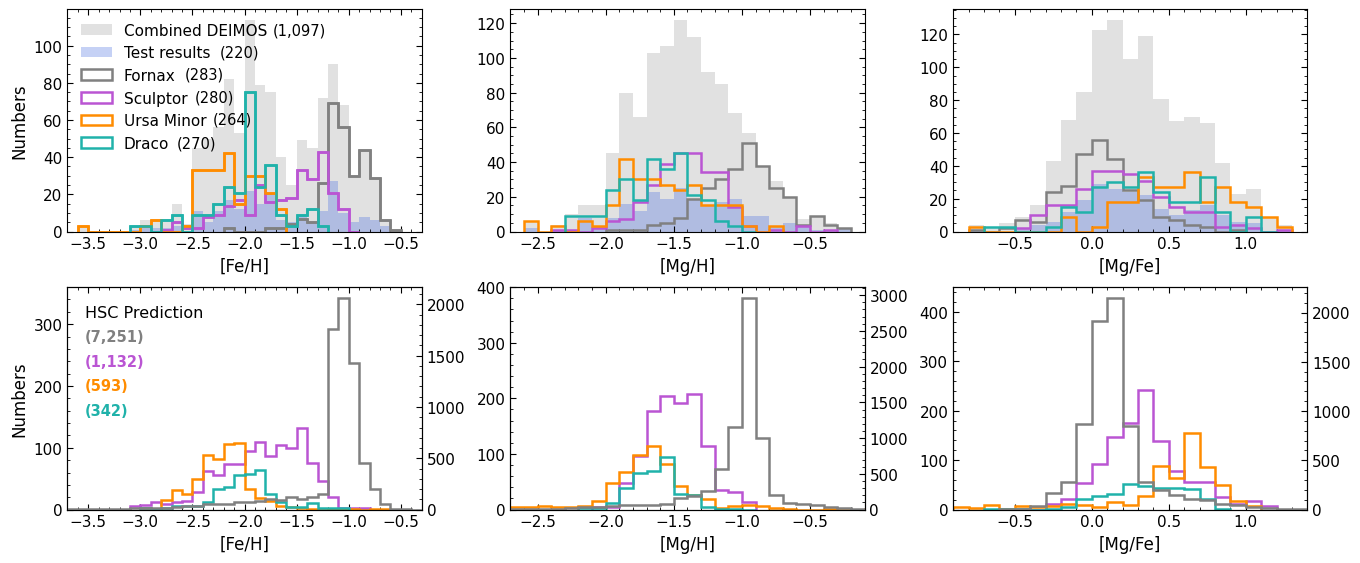

In [46]:
def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_dataset['FEH'], bins=np.arange(np.floor(np.min(test_dataset['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_dataset['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_dataset['MGH'], bins=np.arange(np.floor(np.min(test_dataset['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_dataset['MGFE'], bins=np.arange(np.floor(np.min(test_dataset['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_ann_sklearn'], [hsc_scl_mag['FEH_phot_ann_sklearn'], hsc_umi_mag['FEH_phot_ann_sklearn'], hsc_dra_mag['FEH_phot_ann_sklearn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 360])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_ann_sklearn'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_ann_sklearn'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_ann_sklearn'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_ann_sklearn'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_ann_sklearn'], [hsc_scl_mag['MGH_phot_ann_sklearn'], hsc_umi_mag['MGH_phot_ann_sklearn'], hsc_dra_mag['MGH_phot_ann_sklearn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_ann_sklearn'], [hsc_scl_mag['MGFE_phot_ann_sklearn'], hsc_umi_mag['MGFE_phot_ann_sklearn'], hsc_dra_mag['MGFE_phot_ann_sklearn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.show()

In [47]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_ann_sklearn']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_ann_sklearn']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_ann_sklearn']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_ann_sklearn']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_ann_sklearn']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_ann_sklearn']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_ann_sklearn']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_ann_sklearn']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_ann_sklearn']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_ann_sklearn']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_ann_sklearn']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_ann_sklearn']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_ann_sklearn']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_ann_sklearn']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_ann_sklearn']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df

FEH           MGH         MGFE
fnx_mag      -1.05 ± 0.22  -0.99 ± 0.28  0.06 ± 0.25
scl_mag      -1.62 ± 0.40  -1.41 ± 0.27  0.21 ± 0.31
umi_mag      -2.16 ± 0.31  -1.59 ± 0.33  0.56 ± 0.35
dra_mag      -1.98 ± 0.33  -1.64 ± 0.27  0.34 ± 0.34
hsc_fnx_mag  -1.17 ± 0.40  -1.03 ± 0.28  0.14 ± 0.22
hsc_scl_mag  -1.83 ± 0.40  -1.48 ± 0.20  0.34 ± 0.26
hsc_umi_mag  -2.21 ± 0.27  -1.71 ± 0.37  0.50 ± 0.39
hsc_dra_mag  -1.98 ± 0.28  -1.63 ± 0.17  0.35 ± 0.25

# CNN

/afs/crc.nd.edu/user/j/jhong5/.local/lib/python3.9/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/afs/crc.nd.edu/user/j/jhong5/.local/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 4, 8)           │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 4, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 4)           │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 2)           │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,156 (4.52 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 0 (0.00 B)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................
          loss       mae       mse  val_loss   val_mae   val_mse  epoch
411  0.072096  0.203515  0.072096  0.071598  0.205903  0.071598    411
412  0.074639  0.207265  0.074639  0.072654  0.208758  0.072654    412
413  0.072397  0.202071  0.072397  0.070352  0.204029  0.070352    413
414  0.072334  0.202830  0.072334  0.071073  0.204688  0.071073    414
415  0.070635  0.200257  0.070635  0.066847  0.197643  0.066847    415


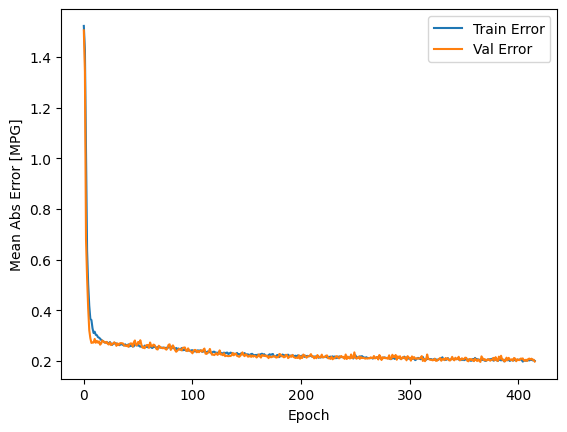

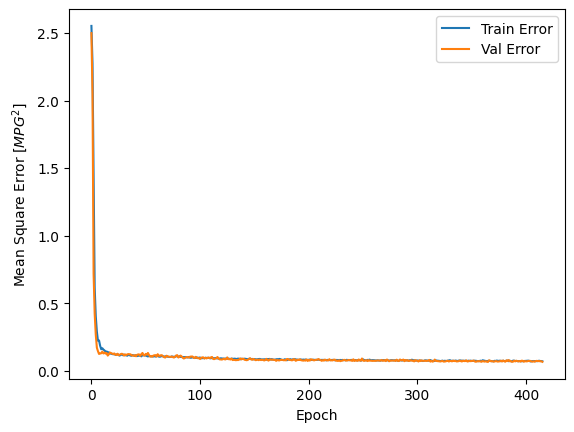

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
CPU times: user 5min 20s, sys: 1min 32s, total: 6min 53s
Wall time: 3min 11s


In [48]:
%%time
from tensorflow import keras

train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)
    
def build_model_cnn():
    model = keras.Sequential([
        keras.layers.Reshape((4, 1), input_shape=(4,)),
        keras.layers.Conv1D(8, 3, activation=None, padding='same'),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv1D(4, 3, activation=None, padding='same'),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv1D(2, 3, activation=None, padding='same'),
        keras.layers.LeakyReLU(alpha=0.2),

        # Add Dropout after convolutional layers
        keras.layers.Dropout(0.2),

        # Dense layer after flatten
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(16, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(8, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(4, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),

        # Output layer
        keras.layers.Dense(2)
    ])
    
    # compile a model
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

model_cnn = build_model_cnn()
model_cnn.summary()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 500 #5000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

#history = model_cnn.fit(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']],
history = model_cnn.fit(train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']],
                    train_dataset[['FEH', 'MGH']],
                    epochs=EPOCHS, 
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])
#model_cnn.save("model_cnn.h5")

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n', hist.tail())

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)

# Perform Predictions
#test_predictions = model_cnn.predict(test_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
test_predictions = model_cnn.predict(test_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']])
test_dataset['FEH_phot_cnn'], test_dataset['MGH_phot_cnn'] = test_predictions[:, 0], test_predictions[:, 1]
test_dataset['MGFE_phot_cnn'] = test_dataset['MGH_phot_cnn'] - test_dataset['FEH_phot_cnn']

#train_predictions = model_cnn.predict(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
train_predictions = model_cnn.predict(train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']])
train_dataset['FEH_phot_cnn'], train_dataset['MGH_phot_cnn'] = train_predictions[:, 0], train_predictions[:, 1]
train_dataset['MGFE_phot_cnn'] = train_dataset['MGH_phot_cnn'] - train_dataset['FEH_phot_cnn']

#hsc_predictions = model_cnn.predict(hsc_df_mag[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
hsc_predictions = model_cnn.predict(hsc_df_mag[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']])
hsc_df_mag['FEH_phot_cnn'], hsc_df_mag['MGH_phot_cnn'] = hsc_predictions[:, 0], hsc_predictions[:, 1]
hsc_df_mag['MGFE_phot_cnn'] = hsc_df_mag['MGH_phot_cnn'] - hsc_df_mag['FEH_phot_cnn']

#Wall time: 1min 54s

In [49]:
train_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dra = train_dataset[train_dataset['galaxy_id'] == 3]

test_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dra = test_dataset[test_dataset['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

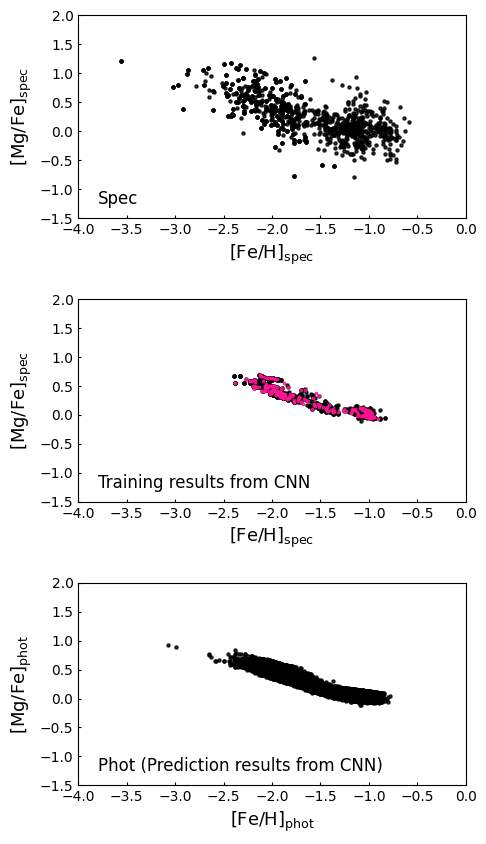

In [50]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_fnx['FEH_phot_cnn'], train_fnx['MGFE_phot_cnn'], s=s, alpha=alpha, color='black')
ax1.scatter(train_scl['FEH_phot_cnn'], train_scl['MGFE_phot_cnn'], s=s, alpha=alpha, color='black')
ax1.scatter(train_umi['FEH_phot_cnn'], train_umi['MGFE_phot_cnn'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dra['FEH_phot_cnn'], train_dra['MGFE_phot_cnn'], s=s, alpha=alpha, color='black')
ax1.scatter(test_fnx['FEH_phot_cnn'], test_fnx['MGFE_phot_cnn'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_scl['FEH_phot_cnn'], test_scl['MGFE_phot_cnn'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_umi['FEH_phot_cnn'], test_umi['MGFE_phot_cnn'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dra['FEH_phot_cnn'], test_dra['MGFE_phot_cnn'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from CNN', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_cnn'], hsc_fnx_mag['MGFE_phot_cnn'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_cnn'], hsc_scl_mag['MGFE_phot_cnn'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_cnn'], hsc_umi_mag['MGFE_phot_cnn'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_cnn'], hsc_dra_mag['MGFE_phot_cnn'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from CNN)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

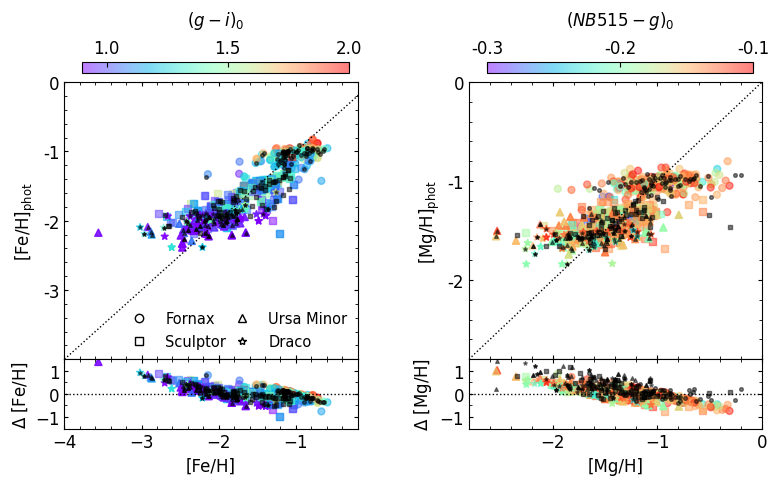

In [51]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 25 ; alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', '*']

# Training
# [Fe/H]
ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_fnx['FEH'], train_fnx['FEH_phot_cnn'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_scl['FEH'], train_scl['FEH_phot_cnn'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_umi['FEH'], train_umi['FEH_phot_cnn'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dra['FEH'], train_dra['FEH_phot_cnn'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax0.scatter(test_fnx['FEH'], test_fnx['FEH_phot_cnn'], s=7, alpha=0.5, marker=markers[0], color='black')
ax0.scatter(test_scl['FEH'], test_scl['FEH_phot_cnn'], s=7, alpha=0.5, marker=markers[1], color='black')
ax0.scatter(test_umi['FEH'], test_umi['FEH_phot_cnn'], s=7, alpha=0.5, marker=markers[2], color='black')
ax0.scatter(test_dra['FEH'], test_dra['FEH_phot_cnn'], s=7, alpha=0.5, marker=markers[3], color='black')

custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
legend = ax0.legend(handles=custom_legend, fontsize=10.5, framealpha=0, ncol=2, columnspacing=0.1)
legend.set_bbox_to_anchor((0.16, 0.12, 0.3, 0.1), transform=ax0.transAxes)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.05, 0.96, f'Training (N={len(train_FEH)}, RMSE={train_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
#ax0.text(0.05, 0.88, f'Test (N={len(test_FEH)}, RMSE={test_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(g - i)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])
#m_train, b_train = np.polyfit(train_FEH['FEH'], train_FEH['FEH_phot_cnn'], 1)
#ax0.plot(np.linspace(xmin, xmax, 100), m_train * np.linspace(xmin, xmax, 100) + b_train, color='black', linestyle='-', linewidth=1.5, label='Train Fit')
#print('m_train =', m_train)

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_fnx['FEH'], train_fnx['FEH_phot_cnn']-train_fnx['FEH'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_scl['FEH'], train_scl['FEH_phot_cnn']-train_scl['FEH'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_umi['FEH'], train_umi['FEH_phot_cnn']-train_umi['FEH'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dra['FEH'], train_dra['FEH_phot_cnn']-train_dra['FEH'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax2.scatter(test_fnx['FEH'], test_fnx['FEH_phot_cnn']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax2.scatter(test_scl['FEH'], test_scl['FEH_phot_cnn']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax2.scatter(test_umi['FEH'], test_umi['FEH_phot_cnn']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax2.scatter(test_dra['FEH'], test_dra['FEH_phot_cnn']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.5, 1.5])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)


# Test
# [Mg/H]
xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_fnx['MGH'], train_fnx['MGH_phot_cnn'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_scl['MGH'], train_scl['MGH_phot_cnn'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_umi['MGH'], train_umi['MGH_phot_cnn'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dra['MGH'], train_dra['MGH_phot_cnn'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax1.scatter(test_fnx['MGH'], test_fnx['MGH_phot_cnn'], s=7, alpha=0.5, marker=markers[0], color='black')
ax1.scatter(test_scl['MGH'], test_scl['MGH_phot_cnn'], s=7, alpha=0.5, marker=markers[1], color='black')
ax1.scatter(test_umi['MGH'], test_umi['MGH_phot_cnn'], s=7, alpha=0.5, marker=markers[2], color='black')
ax1.scatter(test_dra['MGH'], test_dra['MGH_phot_cnn'], s=7, alpha=0.5, marker=markers[3], color='black')

ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-2, -1, 0])
ax1.set_yticklabels(['-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.05, 0.96, f'Training (N={len(train_MGH)}, RMSE={train_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
#ax1.text(0.05, 0.88, f'Test (N={len(test_MGH)}, RMSE={test_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(NB515 - g)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([-0.3, -0.2, -0.1])
cbar.ax.set_xticklabels(['-0.3', '-0.2', '-0.1'])
#m_test, b_test = np.polyfit(test_FEH['FEH'], test_FEH['FEH_phot_cnn'], 1)
#ax1.plot(np.linspace(xmin, xmax, 100), m_test * np.linspace(xmin, xmax, 100) + b_test, color=color, linestyle='-', linewidth=1.5, label='Test Fit')
#print('m_test =', m_test)

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_fnx['MGH'], train_fnx['MGH_phot_cnn']-train_fnx['MGH'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_scl['MGH'], train_scl['MGH_phot_cnn']-train_scl['MGH'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_umi['MGH'], train_umi['MGH_phot_cnn']-train_umi['MGH'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dra['MGH'], train_dra['MGH_phot_cnn']-train_dra['MGH'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax3.scatter(test_fnx['MGH'], test_fnx['MGH_phot_cnn']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax3.scatter(test_scl['MGH'], test_scl['MGH_phot_cnn']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax3.scatter(test_umi['MGH'], test_umi['MGH_phot_cnn']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax3.scatter(test_dra['MGH'], test_dra['MGH_phot_cnn']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.5, 1.5])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()

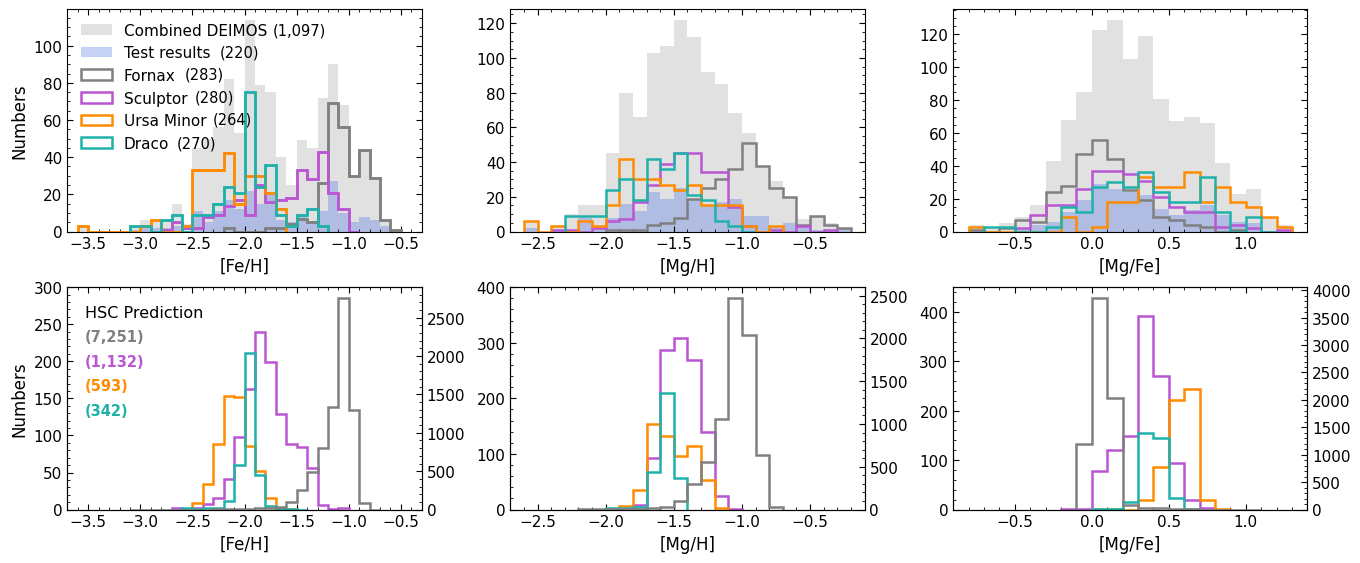

In [52]:
def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_dataset['FEH'], bins=np.arange(np.floor(np.min(test_dataset['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_dataset['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_dataset['MGH'], bins=np.arange(np.floor(np.min(test_dataset['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_dataset['MGFE'], bins=np.arange(np.floor(np.min(test_dataset['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_cnn'], [hsc_scl_mag['FEH_phot_cnn'], hsc_umi_mag['FEH_phot_cnn'], hsc_dra_mag['FEH_phot_cnn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 300])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_cnn'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_cnn'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_cnn'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_cnn'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_cnn'], [hsc_scl_mag['MGH_phot_cnn'], hsc_umi_mag['MGH_phot_cnn'], hsc_dra_mag['MGH_phot_cnn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_cnn'], [hsc_scl_mag['MGFE_phot_cnn'], hsc_umi_mag['MGFE_phot_cnn'], hsc_dra_mag['MGFE_phot_cnn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.show()

In [53]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_cnn']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_cnn']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_cnn']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_cnn']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_cnn']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_cnn']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_cnn']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_cnn']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_cnn']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_cnn']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_cnn']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_cnn']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_cnn']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_cnn']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_cnn']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_cnn']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_cnn']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_cnn']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_cnn']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_cnn']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_cnn']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_cnn']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_cnn']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_cnn']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df

FEH           MGH         MGFE
fnx_mag      -1.05 ± 0.22  -0.99 ± 0.28  0.06 ± 0.25
scl_mag      -1.62 ± 0.40  -1.41 ± 0.27  0.21 ± 0.31
umi_mag      -2.16 ± 0.31  -1.59 ± 0.33  0.56 ± 0.35
dra_mag      -1.98 ± 0.33  -1.64 ± 0.27  0.34 ± 0.34
hsc_fnx_mag  -1.12 ± 0.17  -1.06 ± 0.14  0.07 ± 0.07
hsc_scl_mag  -1.78 ± 0.22  -1.44 ± 0.12  0.34 ± 0.14
hsc_umi_mag  -2.09 ± 0.15  -1.51 ± 0.15  0.58 ± 0.09
hsc_dra_mag  -1.96 ± 0.10  -1.56 ± 0.07  0.40 ± 0.07

# CNN try using Guiglion

In [21]:
%%time
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Conv1D, LeakyReLU, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 데이터 분할
train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)

# CNN 입력 데이터와 타깃 데이터 추출
X_train = train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values
X_test = test_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values

y_train = train_dataset[['FEH', 'MGH']].values
y_test = test_dataset[['FEH', 'MGH']].values

# CNN 입력 데이터 스케일링
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# 타깃 데이터 스케일링
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# CNN 입력 데이터 reshape: (batch, 4, 1)
X_train = X_train.reshape(-1, 4, 1)
X_test = X_test.reshape(-1, 4, 1)

def build_model_cnn_guiglion():
    ipt = Input(shape=(4, 1), name="cnn_input")
    x = Conv1D(8, 3, padding='same', name='convol_1')(ipt)
    x = LeakyReLU()(x)
    x = Conv1D(4, 3, padding='same', name='convol_2')(x)
    x = LeakyReLU()(x)
    x = Conv1D(2, 3, padding='same', name='convol_3')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(32)(x)
    x = LeakyReLU()(x)

    # 추가 Dense layer
    combined = Dense(16)(x)
    combined = LeakyReLU()(combined)

    # 출력 layer (FEH, MGH 2개 출력)
    output = Dense(2, activation='linear', name="output_layer")(combined)

    # 모델 정의 및 컴파일
    model = Model(inputs=ipt, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    
    return model

# 모델 생성
model = build_model_cnn_guiglion()

# 모델 학습 (CNN 입력과 타깃 y_train 사용)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 모델 요약 출력
model.summary()

# 학습 및 테스트 데이터에 대한 예측 수행
train_predictions_scaled = model.predict(X_train)
train_predictions = scaler_phot.inverse_transform(train_predictions_scaled)
train_dataset['FEH_phot_cnn_g'], train_dataset['MGH_phot_cnn_g'] = train_predictions[:, 0], train_predictions[:, 1]
train_dataset['MGFE_phot_cnn_g'] = train_dataset['MGH_phot_cnn_g'] - train_dataset['FEH_phot_cnn_g']

test_predictions_scaled = model.predict(X_test)
test_predictions  = scaler_phot.inverse_transform(test_predictions_scaled)
test_dataset['FEH_phot_cnn_g'], test_dataset['MGH_phot_cnn_g'] = test_predictions[:, 0], test_predictions[:, 1]
test_dataset['MGFE_phot_cnn_g'] = test_dataset['MGH_phot_cnn_g'] - test_dataset['FEH_phot_cnn_g']


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.9906 - mae: 0.8065 - mse: 0.9906 - val_loss: 0.8307 - val_mae: 0.7374 - val_mse: 0.8307
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8331 - mae: 0.7399 - mse: 0.8331 - val_loss: 0.6930 - val_mae: 0.6628 - val_mse: 0.6930
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6809 - mae: 0.6761 - mse: 0.6809 - val_loss: 0.5613 - val_mae: 0.5837 - val_mse: 0.5613
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5975 - mae: 0.6074 - mse: 0.5975 - val_loss: 0.4695 - val_mae: 0.5315 - val_mse: 0.4695
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4947 - mae: 0.5481 - mse: 0.4947 - val_loss: 0.4449 - val_mae: 0.5191 - val_mse: 0.4449
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5155 - mae: 0.5502 - mse: 0.5155 - val_loss: 0.4293 - val_mae: 0.5142 - val_mse: 0.4293
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5077 - mae: 0.5494 - mse: 0.5077 - val

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_input (InputLayer)          │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convol_1 (Conv1D)               │ (None, 4, 8)           │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 4, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convol_2 (Conv1D)               │ (None, 4, 4)           │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convol_3 (Conv1D)               │ (None, 4, 2)           │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 4, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,026 (11.82 KB)

 Trainable params: 1,008 (3.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,018 (7.89 KB)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
CPU times: user 1min 25s, sys: 27.4 s, total: 1min 53s
Wall time: 50.6 s


In [54]:
# %%time
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.layers import Input, Conv1D, LeakyReLU, Dropout, Flatten, Dense, concatenate
# from tensorflow.keras.models import Model
# import tensorflow as tf

# # Split the data
# train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)

# X_train_cnn = train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values
# X_test_cnn = test_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values

# X_train_phot = train_dataset[['FEH', 'MGH']].values
# X_test_phot = test_dataset[['FEH', 'MGH']].values

# # Scaling
# scaler_cnn = StandardScaler()
# X_train_cnn = scaler_cnn.fit_transform(X_train_cnn)
# X_test_cnn = scaler_cnn.transform(X_test_cnn)

# scaler_phot = StandardScaler()
# X_train_phot = scaler_phot.fit_transform(X_train_phot)
# X_test_phot = scaler_phot.transform(X_test_phot)

# # Reshape
# X_train_cnn = X_train_cnn.reshape(-1, 4, 1)
# X_test_cnn = X_test_cnn.reshape(-1, 4, 1)

# X_train_phot = X_train_phot.reshape(-1, 2, 1)
# X_test_phot = X_test_phot.reshape(-1, 2, 1)

# # Scaler for y values (FEH, MGH)
# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(train_dataset[['FEH', 'MGH']])
# y_test = scaler_y.transform(test_dataset[['FEH', 'MGH']])

# def build_model_cnn_guiglion():
#     ipt = Input(shape=(4, 1), name="cnn_input")
#     x = Conv1D(8, 3, padding='same', name='convol_1')(ipt)
#     x = LeakyReLU()(x)
#     x = Conv1D(4, 3, padding='same', name='convol_2')(x)
#     x = LeakyReLU()(x)
#     x = Conv1D(2, 3, padding='same', name='convol_3')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.2)(x)
#     x = Flatten()(x)
#     x = Dense(32)(x)
#     x = LeakyReLU()(x)

#     # Combine with the final dense layer
#     combined = Dense(16)(x)
#     combined = LeakyReLU()(combined)

#     # Output layer (2 outputs for FEH and MGH)
#     output = Dense(2, activation='linear', name="output_layer")(combined)

#     # Define the model
#     model = Model(inputs=ipt, outputs=output)

#     # Compile the model
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#     model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

#     return model

# # Build the model
# model = build_model_cnn_guiglion()

# # Let the model learn (now we only use X_train_cnn)
# history = model.fit(
#     X_train_cnn,
#     X_train_phot,
#     epochs=100,
#     batch_size=32,
#     validation_split=0.2,
#     verbose=1
# )

# # Print model summary
# model.summary()

# # Get the predictions of training and test samples
# train_predictions = model.predict(X_train_cnn)
# train_dataset['FEH_phot_cnn_g'], train_dataset['MGH_phot_cnn_g'] = train_predictions[:, 0], train_predictions[:, 1]
# train_dataset['MGFE_phot_cnn_g'] = train_dataset['MGH_phot_cnn_g'] - train_dataset['FEH_phot_cnn_g']

# test_predictions = model.predict(X_test_cnn)
# test_dataset['FEH_phot_cnn_g'], test_dataset['MGH_phot_cnn_g'] = test_predictions[:, 0], test_predictions[:, 1]
# test_dataset['MGFE_phot_cnn_g'] = test_dataset['MGH_phot_cnn_g'] - test_dataset['FEH_phot_cnn_g']

# # # After predictions, inverse the scaling for FEH and MGH
# # test_predictions = scaler_y.inverse_transform(test_predictions)
# # train_predictions = scaler_y.inverse_transform(train_predictions)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.9712 - mae: 0.8087 - mse: 0.9712 - val_loss: 0.8547 - val_mae: 0.7633 - val_mse: 0.8547
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8098 - mae: 0.7341 - mse: 0.8098 - val_loss: 0.6596 - val_mae: 0.6512 - val_mse: 0.6596
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6164 - mae: 0.6248 - mse: 0.6164 - val_loss: 0.5091 - val_mae: 0.5564 - val_mse: 0.5091
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5420 - mae: 0.5804 - mse: 0.5420 - val_loss: 0.4690 - val_mae: 0.5328 - val_mse: 0.4690
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5269 - mae: 0.5707 - mse: 0.5269 - val_loss: 0.4468 - val_mae: 0.5298 - val_mse: 0.4468
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5333 - mae: 0.5797 - mse: 0.5333 - val_loss: 0.4333 - val_mae: 0.5177 - val_mse: 0.4333
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4898 - mae: 0.5419 - mse: 0.4898 - val

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_input (InputLayer)          │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convol_1 (Conv1D)               │ (None, 4, 8)           │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 4, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convol_2 (Conv1D)               │ (None, 4, 4)           │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convol_3 (Conv1D)               │ (None, 4, 2)           │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 4, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,026 (11.82 KB)

 Trainable params: 1,008 (3.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,018 (7.89 KB)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
CPU times: user 1min 17s, sys: 25.7 s, total: 1min 43s
Wall time: 50.6 s


In [22]:
# Get the prediction of HSC (no need for hsc_input_phot, just hsc_input_cnn)
hsc_input_cnn = scaler_cnn.transform(hsc_df_mag[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values)
#hsc_input_cnn = hsc_df_mag[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values
#hsc_input_cnn = hsc_input_cnn.reshape(-1, 4, 1)  # reshape
hsc_input_cnn = np.array(hsc_input_cnn).reshape(-1, 4, 1)  # reshape for CNN input

hsc_predictions_scaled = model.predict(hsc_input_cnn)
hsc_predictions   = scaler_phot.inverse_transform(hsc_predictions_scaled)

hsc_df_mag['FEH_phot_cnn_g'], hsc_df_mag['MGH_phot_cnn_g'] = hsc_predictions[:, 0], hsc_predictions[:, 1]
hsc_df_mag['MGFE_phot_cnn_g'] = hsc_df_mag['MGH_phot_cnn_g'] - hsc_df_mag['FEH_phot_cnn_g']

292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [23]:
train_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dra = train_dataset[train_dataset['galaxy_id'] == 3]

test_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dra = test_dataset[test_dataset['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

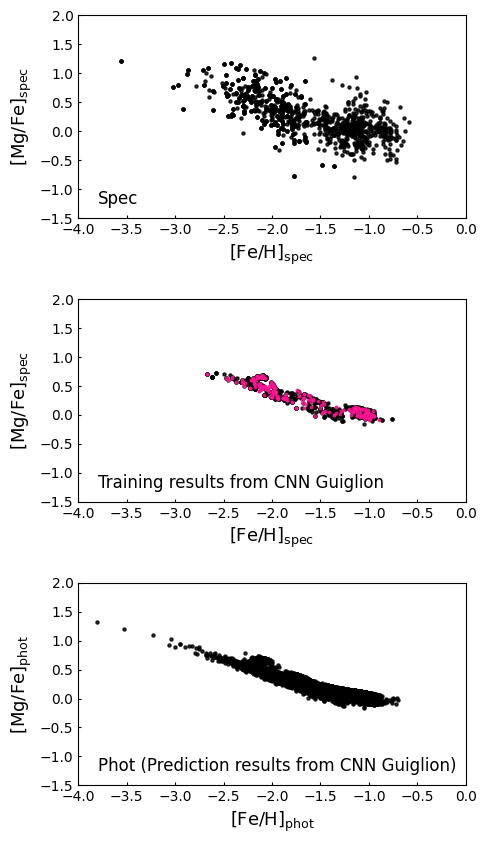

In [26]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_fnx['FEH_phot_cnn_g'], train_fnx['MGFE_phot_cnn_g'], s=s, alpha=alpha, color='black')
ax1.scatter(train_scl['FEH_phot_cnn_g'], train_scl['MGFE_phot_cnn_g'], s=s, alpha=alpha, color='black')
ax1.scatter(train_umi['FEH_phot_cnn_g'], train_umi['MGFE_phot_cnn_g'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dra['FEH_phot_cnn_g'], train_dra['MGFE_phot_cnn_g'], s=s, alpha=alpha, color='black')
ax1.scatter(test_fnx['FEH_phot_cnn_g'], test_fnx['MGFE_phot_cnn_g'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_scl['FEH_phot_cnn_g'], test_scl['MGFE_phot_cnn_g'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_umi['FEH_phot_cnn_g'], test_umi['MGFE_phot_cnn_g'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dra['FEH_phot_cnn_g'], test_dra['MGFE_phot_cnn_g'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from CNN Guiglion', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_cnn_g'], hsc_fnx_mag['MGFE_phot_cnn_g'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_cnn_g'], hsc_scl_mag['MGFE_phot_cnn_g'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_cnn_g'], hsc_umi_mag['MGFE_phot_cnn_g'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_cnn_g'], hsc_dra_mag['MGFE_phot_cnn_g'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from CNN Guiglion)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

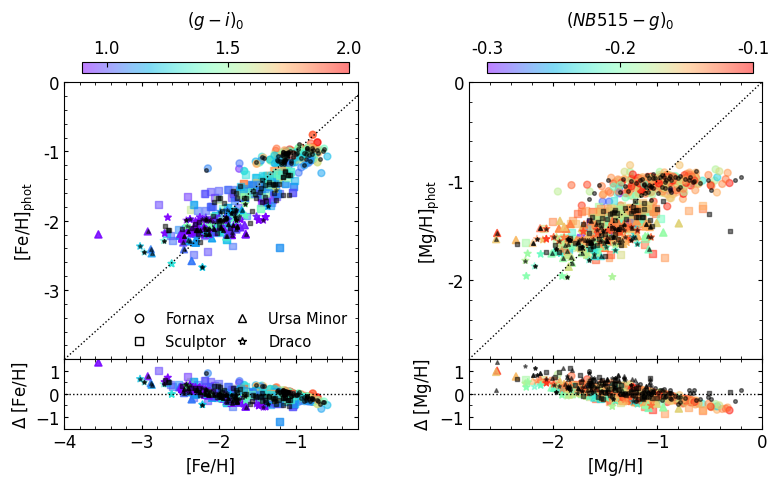

In [30]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 25 ; alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', '*']

# Training
# [Fe/H]
ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_fnx['FEH'], train_fnx['FEH_phot_cnn_g'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_scl['FEH'], train_scl['FEH_phot_cnn_g'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_umi['FEH'], train_umi['FEH_phot_cnn_g'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dra['FEH'], train_dra['FEH_phot_cnn_g'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax0.scatter(test_fnx['FEH'], test_fnx['FEH_phot_cnn_g'], s=7, alpha=0.5, marker=markers[0], color='black')
ax0.scatter(test_scl['FEH'], test_scl['FEH_phot_cnn_g'], s=7, alpha=0.5, marker=markers[1], color='black')
ax0.scatter(test_umi['FEH'], test_umi['FEH_phot_cnn_g'], s=7, alpha=0.5, marker=markers[2], color='black')
ax0.scatter(test_dra['FEH'], test_dra['FEH_phot_cnn_g'], s=7, alpha=0.5, marker=markers[3], color='black')

custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
legend = ax0.legend(handles=custom_legend, fontsize=10.5, framealpha=0, ncol=2, columnspacing=0.1)
legend.set_bbox_to_anchor((0.16, 0.12, 0.3, 0.1), transform=ax0.transAxes)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.05, 0.96, f'Training (N={len(train_FEH)}, RMSE={train_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
#ax0.text(0.05, 0.88, f'Test (N={len(test_FEH)}, RMSE={test_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(g - i)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])
#m_train, b_train = np.polyfit(train_FEH['FEH'], train_FEH['FEH_phot_cnn_g'], 1)
#ax0.plot(np.linspace(xmin, xmax, 100), m_train * np.linspace(xmin, xmax, 100) + b_train, color='black', linestyle='-', linewidth=1.5, label='Train Fit')
#print('m_train =', m_train)

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_fnx['FEH'], train_fnx['FEH_phot_cnn_g']-train_fnx['FEH'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_scl['FEH'], train_scl['FEH_phot_cnn_g']-train_scl['FEH'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_umi['FEH'], train_umi['FEH_phot_cnn_g']-train_umi['FEH'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dra['FEH'], train_dra['FEH_phot_cnn_g']-train_dra['FEH'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax2.scatter(test_fnx['FEH'], test_fnx['FEH_phot_cnn_g']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax2.scatter(test_scl['FEH'], test_scl['FEH_phot_cnn_g']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax2.scatter(test_umi['FEH'], test_umi['FEH_phot_cnn_g']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax2.scatter(test_dra['FEH'], test_dra['FEH_phot_cnn_g']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.5, 1.5])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)


# Test
# [Mg/H]
xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_fnx['MGH'], train_fnx['MGH_phot_cnn_g'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_scl['MGH'], train_scl['MGH_phot_cnn_g'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_umi['MGH'], train_umi['MGH_phot_cnn_g'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dra['MGH'], train_dra['MGH_phot_cnn_g'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax1.scatter(test_fnx['MGH'], test_fnx['MGH_phot_cnn_g'], s=7, alpha=0.5, marker=markers[0], color='black')
ax1.scatter(test_scl['MGH'], test_scl['MGH_phot_cnn_g'], s=7, alpha=0.5, marker=markers[1], color='black')
ax1.scatter(test_umi['MGH'], test_umi['MGH_phot_cnn_g'], s=7, alpha=0.5, marker=markers[2], color='black')
ax1.scatter(test_dra['MGH'], test_dra['MGH_phot_cnn_g'], s=7, alpha=0.5, marker=markers[3], color='black')

ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-2, -1, 0])
ax1.set_yticklabels(['-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.05, 0.96, f'Training (N={len(train_MGH)}, RMSE={train_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
#ax1.text(0.05, 0.88, f'Test (N={len(test_MGH)}, RMSE={test_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(NB515 - g)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([-0.3, -0.2, -0.1])
cbar.ax.set_xticklabels(['-0.3', '-0.2', '-0.1'])
#m_test, b_test = np.polyfit(test_FEH['FEH'], test_FEH['FEH_phot_cnn_g'], 1)
#ax1.plot(np.linspace(xmin, xmax, 100), m_test * np.linspace(xmin, xmax, 100) + b_test, color=color, linestyle='-', linewidth=1.5, label='Test Fit')
#print('m_test =', m_test)

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_fnx['MGH'], train_fnx['MGH_phot_cnn_g']-train_fnx['MGH'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_scl['MGH'], train_scl['MGH_phot_cnn_g']-train_scl['MGH'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_umi['MGH'], train_umi['MGH_phot_cnn_g']-train_umi['MGH'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dra['MGH'], train_dra['MGH_phot_cnn_g']-train_dra['MGH'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax3.scatter(test_fnx['MGH'], test_fnx['MGH_phot_cnn_g']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax3.scatter(test_scl['MGH'], test_scl['MGH_phot_cnn_g']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax3.scatter(test_umi['MGH'], test_umi['MGH_phot_cnn_g']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax3.scatter(test_dra['MGH'], test_dra['MGH_phot_cnn_g']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.5, 1.5])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()

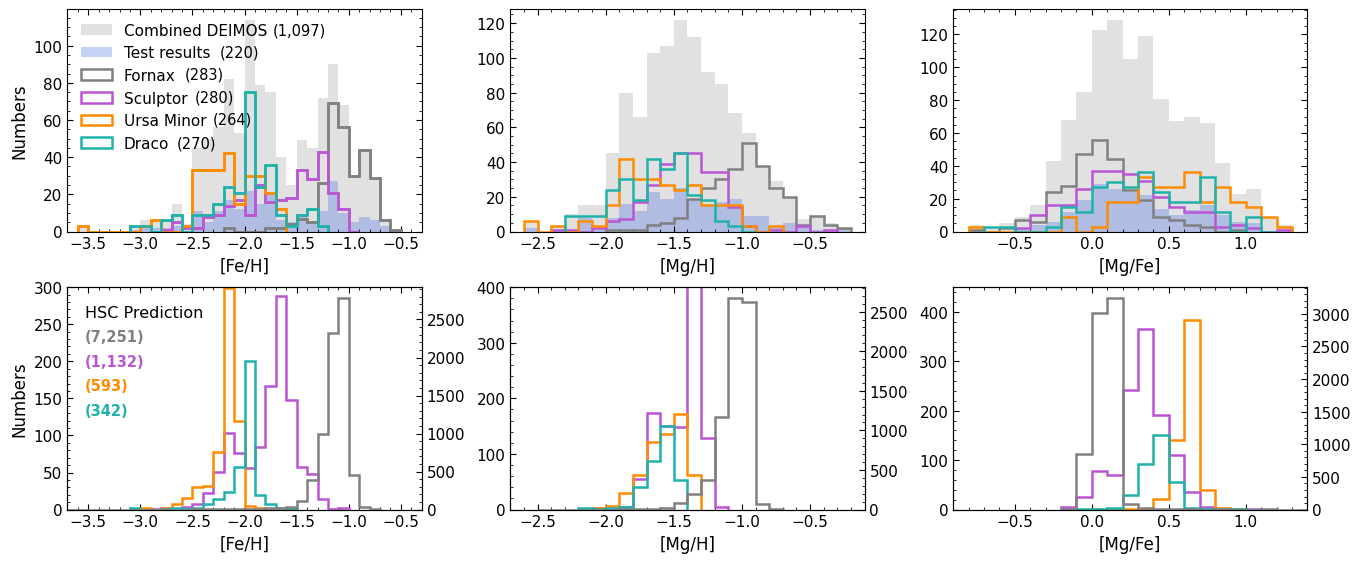

In [33]:
def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_dataset['FEH'], bins=np.arange(np.floor(np.min(test_dataset['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_dataset['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_dataset['MGH'], bins=np.arange(np.floor(np.min(test_dataset['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_dataset['MGFE'], bins=np.arange(np.floor(np.min(test_dataset['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_cnn_g'], [hsc_scl_mag['FEH_phot_cnn_g'], hsc_umi_mag['FEH_phot_cnn_g'], hsc_dra_mag['FEH_phot_cnn_g']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 300])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_cnn_g'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_cnn_g'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_cnn_g'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_cnn_g'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_cnn_g'], [hsc_scl_mag['MGH_phot_cnn_g'], hsc_umi_mag['MGH_phot_cnn_g'], hsc_dra_mag['MGH_phot_cnn_g']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_cnn_g'], [hsc_scl_mag['MGFE_phot_cnn_g'], hsc_umi_mag['MGFE_phot_cnn_g'], hsc_dra_mag['MGFE_phot_cnn_g']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.show()

In [34]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_cnn_g']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_cnn_g']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_cnn_g']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_cnn_g']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_cnn_g']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_cnn_g']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_cnn_g']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_cnn_g']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_cnn_g']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_cnn_g']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_cnn_g']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_cnn_g']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_cnn_g']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_cnn_g']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_cnn_g']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_cnn_g']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_cnn_g']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_cnn_g']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_cnn_g']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_cnn_g']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_cnn_g']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_cnn_g']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_cnn_g']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_cnn_g']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df

FEH           MGH         MGFE
fnx_mag      -1.05 ± 0.22  -0.99 ± 0.28  0.06 ± 0.25
scl_mag      -1.62 ± 0.40  -1.41 ± 0.27  0.21 ± 0.31
umi_mag      -2.16 ± 0.31  -1.59 ± 0.33  0.56 ± 0.35
dra_mag      -1.98 ± 0.33  -1.64 ± 0.27  0.34 ± 0.34
hsc_fnx_mag  -1.14 ± 0.15  -1.06 ± 0.12  0.08 ± 0.07
hsc_scl_mag  -1.78 ± 0.27  -1.44 ± 0.15  0.33 ± 0.16
hsc_umi_mag  -2.19 ± 0.14  -1.56 ± 0.14  0.63 ± 0.08
hsc_dra_mag  -2.02 ± 0.15  -1.60 ± 0.10  0.42 ± 0.10

# CNN - Guiglion20

In [35]:
# import os, os.path
# import h5py, matplotlib
# import matplotlib
# import matplotlib.pyplot as plt
# import scipy
# from astropy.io import fits
# from matplotlib import rcParams, gridspec
# from sklearn.model_selection import train_test_split
# import os
# from sklearn import preprocessing
# import tensorflow as tf
# from tensorflow.keras import Model
# from tensorflow.keras.models import load_model
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, concatenate, LeakyReLU, Convolution1D
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping

# np.__version__, keras.__version__, pd.__version__, tf.__version__

# def normalize_labels(y, limits=None):
#     if limits is None:
#         limits = []
#         for i in range(y.shape[1]):
#             mn = min(y[:,i])
#             mx = max(y[:,i])
#             y[:,i] = (y[:,i] - mn) / (mx - mn)
#             limits.append((mn,mx))
#         return y, limits

#     else:
#         for i in range(y.shape[1]):
#             y[:,i] = (y[:,i] - limits[i][0]) / (limits[i][1] - limits[i][0])
#         return y

# def normalize_parameters(X, limits=None):
#     if limits is None:
#         limits = []
#         for i in range(X.shape[1]):
#             mn = min(X[:,i,:])[0]
#             mx = max(X[:,i,:])[0]
#             X[:,i,:] = (X[:,i,:] - mn) / (mx - mn)
#             limits.append((mn,mx))
#         return X, limits

#     else:
#         for i in range(X.shape[1]):
#             X[:,i,:] = (X[:,i,:] - limits[i][0]) / (limits[i][1] - limits[i][0])
#         return X

# def load_data(filename_spectra, filename_parameters=None, filename_labels=None, validation_percent_split=0):

#     #LOAD THE SPECTRA OF THE TRAINING SAMPLE
#     ext = filename_spectra.split('.')[-1]
#     if ext in ('fits', 'fts'):
#         hdu = fits.open(filename_spectra)
#         spectra_matrix = hdu[0].data.T
#         hdu.close()

#     elif ext in ('csv',):
#         spectra_matrix = np.loadtxt(filename_spectra)

#     elif ext == 'npy':
#         spectra_matrix = np.load(filename_spectra)

#     n_rows_spectra, n_columns_spectra = spectra_matrix.shape

#     data_matrix = spectra_matrix.reshape(n_rows_spectra, n_columns_spectra, 1)
#     data_matrix = data_matrix.astype('float32')

#     #LOAD EXTRA PARAMETERS (PHOTOMETRY IN OUR CASE) FOR THE TRAINING
#     if filename_parameters is not None:
#         ext = filename_parameters.split('.')[-1]
#         if ext in ('fits', 'fts'):
#             hdu = fits.open(filename_parameters)
#             parameters_matrix = hdu[0].data
#             hdu.close()

#         elif ext in ('csv',):
#             parameter_frame   = pd.read_csv(filename_parameters)
#             parameters_matrix = parameter_frame.values

#         elif ext == 'npy':
#             parameters_matrix = np.load(filename_parameters)

#         n_rows_parameters, n_columns_parameters = parameters_matrix.shape

#         parameters_matrix = parameters_matrix.reshape(n_rows_parameters, n_columns_parameters, 1)
#         parameters_matrix = parameters_matrix.astype('float32')

#         assert n_rows_spectra == n_rows_parameters, 'Data and parameter files have different length'

#         data_matrix = np.concatenate((data_matrix, parameters_matrix), axis=1)

#     #LOAD STELLAR LABELS
#     if filename_labels is not None:

#         ext = filename_labels.split('.')[-1]
#         if ext in ('fits', 'fts'):
#             hdu = fits.open(filename_labels)
#             label_matrix = hdu[0].data
#             hdu.close()
#         elif ext in ('csv',):
#             label_frame = pd.read_csv(filename_labels)
#             label_names = list(label_frame.columns)
#             label_matrix = label_frame.values
#         elif ext == 'npy':
#             label_matrix = np.load(filename_labels)

#         n_rows_labels, n_labels = label_matrix.shape

#         assert n_rows_spectra == n_rows_labels

#         label_matrix[:,1:] = label_matrix[:,1:].astype('float32')

#         if validation_percent_split > 0:
#             X_train, X_test, y_train, y_test = train_test_split(data_matrix, label_matrix, test_size= validation_percent_split / 100.0, random_state=42)    #split the data, creating a test sample of X%

#             X_train_spec  = X_train[:,:n_columns_spectra,:]
#             X_train_param = X_train[:,n_columns_spectra:,:]
#             X_test_spec   = X_test[:,:n_columns_spectra,:]
#             X_test_param  = X_test[:,n_columns_spectra:,:]

#             y_train_IDs   = y_train[:,:1]
#             y_test_IDs    = y_test[:,:1]
#             y_train       = y_train[:,1:]
#             y_test        = y_test[:,1:]
#             y_train = y_train.astype('float32')
#             y_test = y_test.astype('float32')

#             if X_train_param.shape[1] == 0: X_train_param = None
#             if X_test_param.shape[1]  == 0: X_test_param  = None

#             return X_train_spec, X_train_param, y_train, X_test_spec, X_test_param, y_test, label_names, y_train_IDs, y_test_IDs

#         else:
#             X_train, y_train = data_matrix, label_matrix
#             if filename_parameters is not None:
#                 X_train_spec  = X_train[:,:n_columns_spectra,:]
#                 X_train_param = X_train[:,n_columns_spectra:,:]
#             else: 
#                 X_train_spec = X_train
#                 X_train_param = None
#             y_train_IDs   = y_train[:,:1]
#             y_train       = y_train[:,1:]
#             return X_train_spec, X_train_param, y_train, None, None, None, label_names, None, y_train_IDs

#     else:
#         if filename_parameters is not None:
#             X_train_spec  = data_matrix[:,:n_columns_spectra,:]
#             X_train_param = data_matrix[:,n_columns_spectra:,:]
#         else: 
#             X_train_spec = data_matrix
#             X_train_param = None
#         return X_train_spec, X_train_param, None, None, None, None, None, None, None

# def architecture(iptdim, iptdim_mag, use_phot):

#     ipt       = Input(shape=(iptdim, 1))     #INPUT DIMENSION OF THE SPECTROSCOPIC CHANNEL
#     ipt_param = Input(shape=(iptdim_mag,1))  #INPUT DIMENSION OF THE PHOTOMETRIC CHANNEL
#     ipt_all = [ipt]

#     x = Convolution1D(8, 10, padding='valid', name = 'convol_1')(ipt)   #CONVOLUTION LAYER 1
#     x = LeakyReLU()(x)
#     x = Convolution1D(4, 10, padding='valid', name = 'convol_2')(x)     #CONVOLUTION LAYER 2
#     x = LeakyReLU()(x)
#     x = Convolution1D(2, 10, padding='valid', name = 'convol_3')(x)     #CONVOLUTION LAYER 3
#     x = LeakyReLU()(x)

#     x = Dropout(0.2)(x)    #DROPOUT LAYER

#     x = Flatten()(x)
#     x = Dense(32)(x)       #FULLY CONNECTED LAYER
#     x = LeakyReLU()(x)

#     if(use_phot==True):
#         y = Flatten()(ipt_param)
#         y = Dense(27)(y)              #FULLY CONNECTED LAYER OF THE PHOTOMETRY
#         y = LeakyReLU()(y)
#         x = concatenate([x, y])       #COMBINING SPECTRA AND PHOTOMETRY
#         ipt_all = [ipt, ipt_param]

#     x = Dense(16)(x)
#     x = LeakyReLU()(x)

#     cnnout = Dense(y_train.shape[1], activation='linear')(x)  #OUTPUT LAYER
#     cnn = Model(ipt_all, cnnout)

#     return cnn

# v = "1"                               # Allow the keep track on the version of the runs
# validation_percent_split = 2.0        # Percentage of the test sample stars
# patience_n               = 40         # Patience for early stop
# n_epoch_max              = 1000       # Number of epoch max
# n_run                    = 3          # Number of models trained
# use_phot                 = True       # Use extra photometry if True

# filename_spectra        = df_mag              # SPECTRA OF THE TRAINING SAMPLE
# filename_labels         = df_mag.columns                # STELLAR LABELS + ERRORS
# filename_parameters     = hsc_df_mag            # = None if no photometry used

# X_train_spec, X_train_param, y_train, X_test_spec, X_test_param, y_test, label_names, y_train_IDs, y_test_IDs = load_data(filename_spectra, filename_parameters, filename_labels, validation_percent_split)

# print(X_train_spec.shape)
# print(X_test_spec.shape)
# print(y_train.shape)
# print(y_test.shape)
# print(X_train_param.shape)
# print(X_test_param.shape)
# print(y_train_IDs.shape)
# print(y_test_IDs.shape)

# #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% computation of normalized absolute magnitudes %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# X_train_mag_i = np.zeros((len(X_train_param),len(X_train_param[0,:,0])-1, 1))
# X_test_mag_i  = np.zeros((len(X_test_param), len(X_test_param[0,:,0])-1,  1))
# for jj in range(len(X_train_mag_i[0,:,0])-1):
#     X_train_mag_i[:,jj,:] = X_train_param[:,jj+1,:] + 5.0 * (np.log10(np.clip(X_train_param[:,0,:] / 1000.0,0.0001,684764767.0)) + 1.0)
#     X_test_mag_i[:,jj,:]  = X_test_param[:,jj+1,:]  + 5.0 * (np.log10(np.clip(X_test_param[:,0,:]  / 1000.0,0.0001,684764767.0)) + 1.0)
# X_train_mag_i[:,len(X_train_mag_i[0,:,0])-1,:] = X_train_param[:,len(X_train_param[0,:,0])-1,:] + 0.0
# X_test_mag_i[:,len(X_test_mag_i[0,:,0])-1,:]   = X_test_param[:,len(X_test_param[0,:,0])-1,:]  + 0.0

# X_train_mag, limits_mag_params = normalize_parameters(X_train_mag_i + 0.0)   #Normalization of the photometric parameters
# X_test_mag  = normalize_parameters(X_test_mag_i + 0.0, limits_mag_params)
# #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience_n, verbose=1, mode='auto')

# iptdim = len(X_train_spec[0])

# ############################################ Normalization of the stellar labels  #########################################
# #training sample
# y_train_n, limits_labels = normalize_labels(y_train+0.0)
# #test sample
# y_test_n = normalize_labels(y_test+0.0, limits_labels)
# ####################################################################################################

# np.savez('models/data_for_cnn_version_' + v + '.npz', X_train_spec_tmp=X_train_spec, X_train_mag_tmp=X_train_mag, y_train_tmp=y_train_n, X_test_spec_tmp=X_test_spec, X_test_mag_tmp=X_test_mag, y_test_tmp=y_test_n, label_names_tmp=label_names, limits_labels_tmp=limits_labels)

# histories = []

# #begin of the N iterations:
# for index_run in range(n_run):

#     iptdim_mag = len(X_train_mag[0])
#     cnn = architecture(iptdim, iptdim_mag, use_phot)
#     cnn.compile(loss='mse', optimizer='Adam',metrics=['mse'])
#     if(use_phot==False):
#         history = cnn.fit([X_train_spec], y_train_n, batch_size=16, epochs=n_epoch_max, validation_data=([X_test_spec], y_test_n), verbose=0, callbacks=[early_stop])
#     if(use_phot==True):
#         history = cnn.fit([X_train_spec,X_train_mag], y_train_n, batch_size=16, epochs=n_epoch_max, validation_data=([X_test_spec, X_test_mag], y_test_n), verbose=0, callbacks=[early_stop])

#     histories.append(history)

#     #SAVE THE CNN MODEL
#     cnn.save('models/model_version_' + v + '_%03d.h5' % index_run)  # creates a HDF5 file
#     print(index_run)

# cnn.summary()

# plt.rcParams.update({'font.size': 12})
# fig=plt.figure(figsize=(10,5))
# for h in histories:
#     plt.plot(h.history['loss'],     c='b', alpha=0.1)
#     plt.plot(h.history['val_loss'], c='r', alpha=0.1)
#     plt.yscale('log')
#     plt.xlabel("N_epoch")
#     plt.ylabel("loss")

# #Add together the n_runs
# res_train_all = np.zeros((n_run, y_train_n.shape[0], y_train_n.shape[1]))
# res_test_all  = np.zeros((n_run, y_test_n.shape[0],  y_test_n.shape[1]))

# # LOAD DATA FOR THE CNN (ALLOWS TO PREDICT THE RESULTS WITHOUT NECESSARILY TRAINING THE CNN)
# data = np.load('models/data_for_cnn_version_' + v + '.npz', allow_pickle=True)

# for index_run in range(n_run):

#     cnn = load_model('models/model_version_' + v + '_%03d.h5' % index_run)
#     if(use_phot==False):
#         res_train = cnn.predict([data['X_train_spec_tmp']])
#         res_test  = cnn.predict([data['X_test_spec_tmp']])
#     if(use_phot==True):
#         res_train = cnn.predict([data['X_train_spec_tmp'],data['X_train_mag_tmp']])
#         res_test  = cnn.predict([data['X_test_spec_tmp'],data['X_test_mag_tmp']])
#     array_limits_labels = np.asarray(data['limits_labels_tmp'])

#     # CONVERTING THE RESULTS TO PHYSICAL UNITS
#     for kk in range(y_train_n.shape[1]):
#         corr = (array_limits_labels[kk,1] - array_limits_labels[kk,0])
#         res_train_all[index_run,:,kk] = res_train[:,kk] * corr + array_limits_labels[kk,0]
#         res_test_all[index_run,:,kk]  = res_test[:,kk]  * corr + array_limits_labels[kk,0]

#     print(index_run)

# plt.rcParams.update({'font.size': 12})
# fig=plt.figure(figsize=(10,5))
# last_val_loss = np.array([h.history['val_loss'][-1] for h in histories])
# plt.hist(last_val_loss, bins = 20, histtype = 'stepfilled', facecolor = 'green')
# percenti = np.percentile(last_val_loss, 80.0)
# index_good_training = np.array(np.where(last_val_loss < percenti)[0])
# plt.plot([percenti, percenti], [0.0, +20.0], c = 'black')
# plt.xlabel("Last_Test_loss")
# plt.ylabel("N")

# # MEAN RESULTS
# res_train_f = np.mean(res_train_all[index_good_training,:,:], axis = 0)
# res_test_f  = np.mean(res_test_all[index_good_training,:,:],  axis = 0)

# #MEAN ERRORS
# error_train_f = np.std(res_train_all[index_good_training,:,:], axis = 0)
# error_test_f  = np.std(res_test_all[index_good_training,:,:],  axis = 0)

# #DATA SAVED AS DATAFRAMES IN CSV FILES
# df_res_train = pd.DataFrame(np.hstack((res_train_f,error_train_f)), columns=["Teff","logg","MH","FeH","AlphaM","SiFe","AlFe","MgFe","NiFe","eTeff","elogg","eMH","eFeH","eAlphaM","eSiFe","eAlFe","eMgFe","eNiFe"])
# df_res_test  = pd.DataFrame(np.hstack((res_test_f, error_test_f)),  columns=["Teff","logg","MH","FeH","AlphaM","SiFe","AlFe","MgFe","NiFe","eTeff","elogg","eMH","eFeH","eAlphaM","eSiFe","eAlFe","eMgFe","eNiFe"])

# df_y_train = pd.DataFrame(y_train, columns=["Teff","logg","MH","FeH","AlphaM","SiFe","AlFe","MgFe","NiFe"])
# df_y_test  = pd.DataFrame(y_test,  columns=["Teff","logg","MH","FeH","AlphaM","SiFe","AlFe","MgFe","NiFe"])

# df_res_train["RAVE_OBS_ID"] = y_train_IDs
# df_res_test["RAVE_OBS_ID"]  = y_test_IDs
# df_y_train["RAVE_OBS_ID"]   = y_train_IDs
# df_y_test["RAVE_OBS_ID"]    = y_test_IDs

# df_res_train.to_csv("output/res_train_cnn_version_" + v + '_' + str(use_phot) + ".csv", index=False)
# df_res_test.to_csv("output/res_test_cnn_version_"   + v + '_' + str(use_phot) + ".csv", index=False)
# df_y_train.to_csv("output/y_train_cnn_version_"     + v + '_' + str(use_phot) + ".csv", index=False)
# df_y_test.to_csv("output/y_test_cnn_version_"       + v + '_' + str(use_phot) + ".csv", index=False)

# # SAVE THE LAST_VAL_LOSS ARRAY
# df_last_val_loss = pd.DataFrame(last_val_loss, columns=["last_val_loss"])
# df_last_val_loss.to_csv("models/last_val_loss_version_"  + v + '_' + str(use_phot) + ".csv", index=False)

# xmine = [3200.0, +0.2, -2.2, -2.2, -0.25, -0.45, -0.35, -0.45, -0.29]
# xmaxe = [7400.0, +5.1, +0.7, +0.7, +0.48, +0.48, +0.50, +0.65, +0.20]
# ymine = [-750.0, -1.0, -0.5, -0.5, -0.40, -0.50, -0.40, -0.50, -0.45]
# ymaxe = [+750.0, +1.0, +0.5, +0.5, +0.40, +0.50, +0.40, +0.50, +0.45]
# x_disp = [3500.0, 0.5, -1.9, -1.9, -0.18, -0.35, -0.30, -0.30, -0.27]
# y_disp = [7000.0, 4.5, +0.3, +0.3, +0.40, +0.40, +0.40, +0.52, 0.15]
# corr   = [400.0, 0.5, 0.3, 0.3, 0.1, 0.1, 0.1, 0.1, 0.05]

# plt.rcParams.update({'font.size': 13})
# ct=0

# xlab        = ["Teff (K)", "log(g)", "[M/H]", "[Fe/H]", "[\u03B1/M]", "[Mg/Fe]", "[Si/Fe]", "[Al/Fe]", "[Ni/Fe]"]
# elements    = ['Teff', 'logg', 'MH', 'FeH', 'AlphaM', 'MgFe', 'SiFe', 'AlFe', 'NiFe']
# xmin_histo  = [3000.0, +0.0, -2.5, -2.5, -0.2, -0.3, -0.3, -0.3, -0.2]
# xmax_histo  = [8000.0, +5.5, +0.8, +0.8, +0.5, +0.5, +0.7, +0.5, +0.3]
# bin_histo   = [150.0, 0.2, 0.08, 0.08, 0.02, 0.02, 0.02, 0.02, 0.02]
# bin_histo2  = [60.0, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03]

# for elem in elements:
#     arond=2
#     ct=ct+1
#     fig = plt.figure(figsize=(7, 7))
#     gs = gridspec.GridSpec(3, 2, height_ratios=[0.2,1.0,0.2], width_ratios=[1.0,0.2]) #(line, column)

#     ax3 = plt.subplot(gs[0,0])
#     ax3.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
#     ax3.hist(df_y_train[elem], bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True)
#     ax3.hist(df_y_test[elem],  bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True)
#     ax3.set_xlabel(xlab[ct-1] + " APOGEE DR16", labelpad=2)
#     ax3.set_xlim(xmine[ct-1], xmaxe[ct-1])
#     plt.axis('off')

#     ax0 = plt.subplot(gs[1,0], sharex = ax3)
#     plt.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
#     ax0.plot(df_y_train[elem], df_res_train[elem], 'o', markersize=4.0, color='#1f77b4', fillstyle='none')
#     ax0.plot(df_y_test[elem],   df_res_test[elem],  'x', markersize=6.0, color='#ff7f0e')
#     ax0.set_xlim(xmine[ct-1], xmaxe[ct-1])
#     ax0.set_ylim(xmine[ct-1], xmaxe[ct-1])
#     ax0.set_ylabel(xlab[ct-1] + " CNN",labelpad=2)
#     if(ct==1):
#         arond=0
#         plt.legend(["Training sample", "Test sample"], loc='lower right', frameon=False, prop={'size': 12})
#     ax0.plot([xmine[ct-1], xmaxe[ct-1]], [xmine[ct-1], xmaxe[ct-1]],linestyle='--',color='black', alpha=0.5)
#     ax0.text(x_disp[ct-1], y_disp[ct-1],            "bias="+str(round(np.mean(df_res_train[elem]-df_y_train[elem]),arond)) + " , \u03C3=" + str(round(np.std(df_res_train[elem]-df_y_train[elem]),arond)),color='#1f77b4')
#     ax0.text(x_disp[ct-1], y_disp[ct-1]-corr[ct-1], "bias="+str(round(np.mean(df_res_test[elem] -df_y_test[elem]),arond))  + " , \u03C3=" + str(round(np.std(df_res_test[elem] -df_y_test[elem]),arond)), color='#ff7f0e')

#     ax1 = plt.subplot(gs[1,1], sharey = ax0)
#     ax1.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
#     ax1.hist(df_res_train[elem], bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True, orientation='horizontal')
#     ax1.hist(df_res_test[elem],  bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True, orientation='horizontal')
#     plt.subplots_adjust(wspace=.0)
#     plt.axis('off')

#     ax2 = plt.subplot(gs[2,0], sharex = ax0)
#     ax2.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
#     ax2.plot([xmine[ct-1], xmaxe[ct-1]], [0.0, 0.0],linestyle='--',color='black')
#     ax2.plot(df_y_train[elem], df_res_train[elem] - df_y_train[elem], 'o', markersize=4.0, color='#1f77b4', fillstyle='none')
#     ax2.plot(df_y_test[elem],  df_res_test[elem]  - df_y_test[elem],  'x', markersize=6.0, color='#ff7f0e')
#     ax2.set_xlim(xmine[ct-1], xmaxe[ct-1])
#     ax2.set_ylim(ymine[ct-1], ymaxe[ct-1])
#     ax2.set_ylabel("\u0394")
#     plt.subplots_adjust(hspace=.0)
#     ax2.set_xlabel(xlab[ct-1] + " APOGEE DR16",labelpad=2)

#     ax4 = plt.subplot(gs[2,1], sharey = ax2)
#     ax4.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
#     ax4.hist(df_res_train[elem] - df_y_train[elem], bins=(np.arange(ymine[ct-1], ymaxe[ct-1], bin_histo2[ct-1])), log=True, orientation='horizontal', histtype = 'step')
#     ax4.hist(df_res_test[elem]  - df_y_test[elem],  bins=(np.arange(ymine[ct-1], ymaxe[ct-1], bin_histo2[ct-1])), log=True, orientation='horizontal', histtype = 'step')
#     plt.subplots_adjust(wspace=.0)
#     plt.axis('off')

In [ ]:
from astroNN.models import StarNet2017
from astroNN.datasets import H5Loader

# And then create an object of StarNet2017 classs
starnet_net = StarNet2017()

# Load the train data from dataset first, x_train is spectra and y_train will be ASPCAP labels
loader = H5Loader('model_version_1_000.h5')
loader.load_err = False
print(loader)
#x_train, y_train = loader.load()

# KPCA (multivariate linear regression by Wu19)

In [ ]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# 데이터 분할
train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)

# 원본 데이터를 따로 저장 (4개 피처)
X_train_orig = train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values
X_test_orig = test_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values

y_train = train_dataset[['FEH', 'MGH']].values
y_test = test_dataset[['FEH', 'MGH']].values
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Kernel PCA 하이퍼파라미터 그리드
param_grid = {
    'gamma': [0.1, 1, 10, 50, 100],
    'n_components': [2, 3, 5, 10],
    'kernel': ['rbf', 'poly']
}

best_score = -999
best_params = None
best_kpca = None

# 하이퍼파라미터 탐색 시, 원본 데이터를 사용하여 변환 결과를 별도의 변수에 저장
for gamma in param_grid['gamma']:
    for nc in param_grid['n_components']:
        for krn in param_grid['kernel']:
            kpca = KernelPCA(kernel=krn, gamma=gamma, n_components=nc)
            X_train_trans = kpca.fit_transform(X_train_orig)  # 원본 데이터를 변환
            
            # 후단 모델 (비선형 모델: RandomForest)
            rf = RandomForestRegressor(n_estimators=500, random_state=42)
            multi_rf = MultiOutputRegressor(rf)
            multi_rf.fit(X_train_trans, y_train)
            score = multi_rf.score(X_train_trans, y_train)
            
            if score > best_score:
                best_score = score
                best_params = (gamma, nc, krn)
                best_kpca = kpca

print("Best params:", best_params)  # 예: (50, 10, 'poly')
print("Best score:", best_score)

# 최종 학습: 원본 데이터를 최적의 Kernel PCA로 변환
X_train_final = best_kpca.transform(X_train_orig)
X_test_final = best_kpca.transform(X_test_orig)

rf_final = RandomForestRegressor(n_estimators=500, random_state=42)
multi_rf_final = MultiOutputRegressor(rf_final)
multi_rf_final.fit(X_train_final, y_train)

pred_train_scaled = multi_rf_final.predict(X_train_final)
pred_test_scaled  = multi_rf_final.predict(X_test_final)

# 역변환 (scaler_y 는 미리 학습된 스케일러)
pred_train = scaler_y.inverse_transform(pred_train_scaled)
pred_test  = scaler_y.inverse_transform(pred_test_scaled)

# 예측 결과를 데이터프레임에 추가
train_dataset['FEH_phot_kpca'], train_dataset['MGH_phot_kpca'] = pred_train[:, 0], pred_train[:, 1]
train_dataset['MGFE_phot_kpca'] = train_dataset['MGH_phot_kpca'] - train_dataset['FEH_phot_kpca']
test_dataset['FEH_phot_kpca'], test_dataset['MGH_phot_kpca'] = pred_test[:, 0], pred_test[:, 1]
test_dataset['MGFE_phot_kpca'] = test_dataset['MGH_phot_kpca'] - test_dataset['FEH_phot_kpca']

# HSC 데이터에 대해 예측 수행 (원본 피처 사용)
X_hsc_orig = hsc_df_mag[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values
X_hsc_kpca = best_kpca.transform(X_hsc_orig)
hsc_dataset_pred_values = multi_rf_final.predict(X_hsc_kpca)
hsc_df_mag['FEH_phot_kpca'], hsc_df_mag['MGH_phot_kpca'] = hsc_dataset_pred_values[:, 0], hsc_dataset_pred_values[:, 1]
hsc_df_mag['MGFE_phot_kpca'] = hsc_df_mag['MGH_phot_kpca'] - hsc_df_mag['FEH_phot_kpca']


In [62]:
# %%time
# from sklearn.decomposition import KernelPCA
# from sklearn.multioutput import MultiOutputRegressor

# train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)

# X_train = train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values
# y_train = train_dataset[['FEH', 'MGH']].values
# X_test = test_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values
# y_test = test_dataset[['FEH', 'MGH']].values

# kpca = KernelPCA(kernel="rbf", gamma=50, n_components=3)
# X_train_kpca = kpca.fit_transform(X_train)
# X_test_kpca = kpca.transform(X_test)

# lr = LinearRegression()
# multioutput_lr = MultiOutputRegressor(lr)

# multioutput_lr.fit(X_train_kpca, y_train)

# pred_train = multioutput_lr.predict(X_train_kpca)
# pred_test = multioutput_lr.predict(X_test_kpca)

# train_dataset['FEH_phot_kpca'], train_dataset['MGH_phot_kpca'] = pred_train[:, 0], pred_train[:, 1]
# train_dataset['MGFE_phot_kpca'] = train_dataset['MGH_phot_kpca'] - train_dataset['FEH_phot_kpca']
# test_dataset['FEH_phot_kpca'], test_dataset['MGH_phot_kpca'] = pred_test[:, 0], pred_test[:, 1]
# test_dataset['MGFE_phot_kpca'] = test_dataset['MGH_phot_kpca'] - test_dataset['FEH_phot_kpca']

# X_hsc_kpca = kpca.transform(hsc_df_mag[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']].values)
# hsc_dataset_pred_values = multioutput_lr.predict(X_hsc_kpca)
# hsc_df_mag['FEH_phot_kpca'], hsc_df_mag['MGH_phot_kpca'] = hsc_dataset_pred_values[:, 0], hsc_dataset_pred_values[:, 1]
# hsc_df_mag['MGFE_phot_kpca'] = hsc_df_mag['MGH_phot_kpca'] - hsc_df_mag['FEH_phot_kpca']

CPU times: user 760 ms, sys: 158 ms, total: 919 ms
Wall time: 2.03 s


In [ ]:
train_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dra = train_dataset[train_dataset['galaxy_id'] == 3]

test_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dra = test_dataset[test_dataset['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_fnx['FEH_phot_kpca'], train_fnx['MGFE_phot_kpca'], s=s, alpha=alpha, color='black')
ax1.scatter(train_scl['FEH_phot_kpca'], train_scl['MGFE_phot_kpca'], s=s, alpha=alpha, color='black')
ax1.scatter(train_umi['FEH_phot_kpca'], train_umi['MGFE_phot_kpca'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dra['FEH_phot_kpca'], train_dra['MGFE_phot_kpca'], s=s, alpha=alpha, color='black')
ax1.scatter(test_fnx['FEH_phot_kpca'], test_fnx['MGFE_phot_kpca'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_scl['FEH_phot_kpca'], test_scl['MGFE_phot_kpca'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_umi['FEH_phot_kpca'], test_umi['MGFE_phot_kpca'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dra['FEH_phot_kpca'], test_dra['MGFE_phot_kpca'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from KPCA', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_kpca'], hsc_fnx_mag['MGFE_phot_kpca'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_kpca'], hsc_scl_mag['MGFE_phot_kpca'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_kpca'], hsc_umi_mag['MGFE_phot_kpca'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_kpca'], hsc_dra_mag['MGFE_phot_kpca'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
#ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from KPCA)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

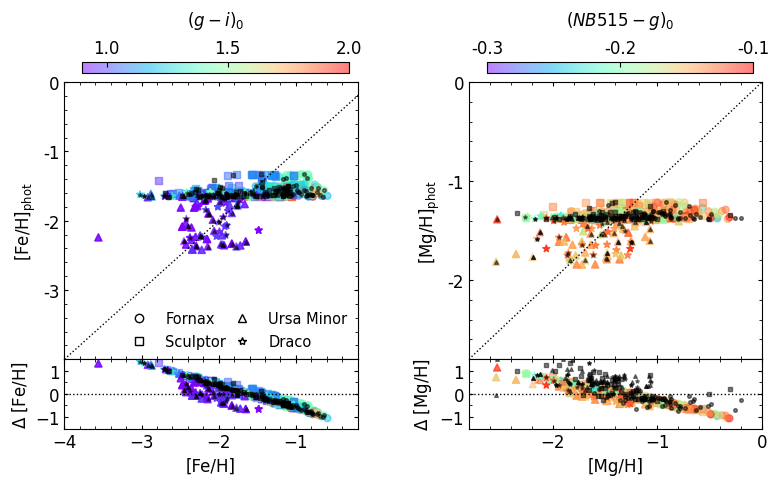

In [65]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 25 ; alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', '*']

# Training
# [Fe/H]
ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_fnx['FEH'], train_fnx['FEH_phot_kpca'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_scl['FEH'], train_scl['FEH_phot_kpca'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_umi['FEH'], train_umi['FEH_phot_kpca'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dra['FEH'], train_dra['FEH_phot_kpca'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax0.scatter(test_fnx['FEH'], test_fnx['FEH_phot_kpca'], s=7, alpha=0.5, marker=markers[0], color='black')
ax0.scatter(test_scl['FEH'], test_scl['FEH_phot_kpca'], s=7, alpha=0.5, marker=markers[1], color='black')
ax0.scatter(test_umi['FEH'], test_umi['FEH_phot_kpca'], s=7, alpha=0.5, marker=markers[2], color='black')
ax0.scatter(test_dra['FEH'], test_dra['FEH_phot_kpca'], s=7, alpha=0.5, marker=markers[3], color='black')

custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
legend = ax0.legend(handles=custom_legend, fontsize=10.5, framealpha=0, ncol=2, columnspacing=0.1)
legend.set_bbox_to_anchor((0.16, 0.12, 0.3, 0.1), transform=ax0.transAxes)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.05, 0.96, f'Training (N={len(train_FEH)}, RMSE={train_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
#ax0.text(0.05, 0.88, f'Test (N={len(test_FEH)}, RMSE={test_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(g - i)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])
#m_train, b_train = np.polyfit(train_FEH['FEH'], train_FEH['FEH_phot_kpca'], 1)
#ax0.plot(np.linspace(xmin, xmax, 100), m_train * np.linspace(xmin, xmax, 100) + b_train, color='black', linestyle='-', linewidth=1.5, label='Train Fit')
#print('m_train =', m_train)

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_fnx['FEH'], train_fnx['FEH_phot_kpca']-train_fnx['FEH'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_scl['FEH'], train_scl['FEH_phot_kpca']-train_scl['FEH'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_umi['FEH'], train_umi['FEH_phot_kpca']-train_umi['FEH'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dra['FEH'], train_dra['FEH_phot_kpca']-train_dra['FEH'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax2.scatter(test_fnx['FEH'], test_fnx['FEH_phot_kpca']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax2.scatter(test_scl['FEH'], test_scl['FEH_phot_kpca']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax2.scatter(test_umi['FEH'], test_umi['FEH_phot_kpca']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax2.scatter(test_dra['FEH'], test_dra['FEH_phot_kpca']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.5, 1.5])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)


# Test
# [Mg/H]
xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_fnx['MGH'], train_fnx['MGH_phot_kpca'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_scl['MGH'], train_scl['MGH_phot_kpca'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_umi['MGH'], train_umi['MGH_phot_kpca'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dra['MGH'], train_dra['MGH_phot_kpca'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax1.scatter(test_fnx['MGH'], test_fnx['MGH_phot_kpca'], s=7, alpha=0.5, marker=markers[0], color='black')
ax1.scatter(test_scl['MGH'], test_scl['MGH_phot_kpca'], s=7, alpha=0.5, marker=markers[1], color='black')
ax1.scatter(test_umi['MGH'], test_umi['MGH_phot_kpca'], s=7, alpha=0.5, marker=markers[2], color='black')
ax1.scatter(test_dra['MGH'], test_dra['MGH_phot_kpca'], s=7, alpha=0.5, marker=markers[3], color='black')

ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-2, -1, 0])
ax1.set_yticklabels(['-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.05, 0.96, f'Training (N={len(train_MGH)}, RMSE={train_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
#ax1.text(0.05, 0.88, f'Test (N={len(test_MGH)}, RMSE={test_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(NB515 - g)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([-0.3, -0.2, -0.1])
cbar.ax.set_xticklabels(['-0.3', '-0.2', '-0.1'])
#m_test, b_test = np.polyfit(test_FEH['FEH'], test_FEH['FEH_phot_kpca'], 1)
#ax1.plot(np.linspace(xmin, xmax, 100), m_test * np.linspace(xmin, xmax, 100) + b_test, color=color, linestyle='-', linewidth=1.5, label='Test Fit')
#print('m_test =', m_test)

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_fnx['MGH'], train_fnx['MGH_phot_kpca']-train_fnx['MGH'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_scl['MGH'], train_scl['MGH_phot_kpca']-train_scl['MGH'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_umi['MGH'], train_umi['MGH_phot_kpca']-train_umi['MGH'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dra['MGH'], train_dra['MGH_phot_kpca']-train_dra['MGH'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax3.scatter(test_fnx['MGH'], test_fnx['MGH_phot_kpca']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax3.scatter(test_scl['MGH'], test_scl['MGH_phot_kpca']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax3.scatter(test_umi['MGH'], test_umi['MGH_phot_kpca']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax3.scatter(test_dra['MGH'], test_dra['MGH_phot_kpca']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.5, 1.5])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()

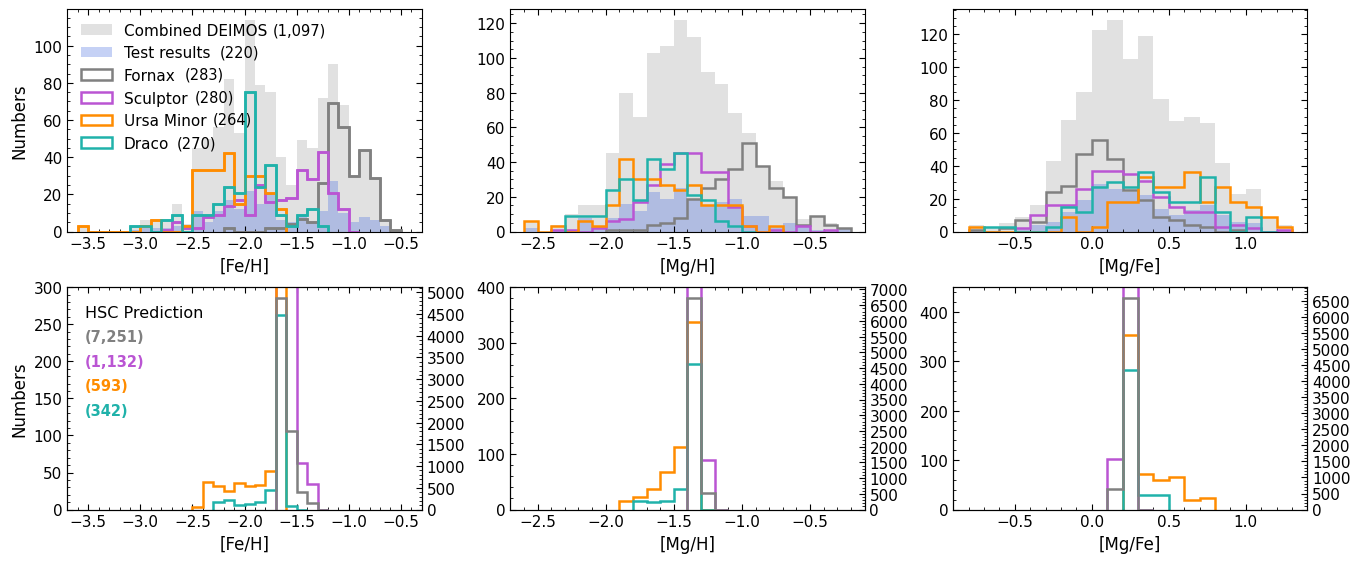

In [66]:
def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_dataset['FEH'], bins=np.arange(np.floor(np.min(test_dataset['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_dataset['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_dataset['MGH'], bins=np.arange(np.floor(np.min(test_dataset['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_dataset['MGFE'], bins=np.arange(np.floor(np.min(test_dataset['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_kpca'], [hsc_scl_mag['FEH_phot_kpca'], hsc_umi_mag['FEH_phot_kpca'], hsc_dra_mag['FEH_phot_kpca']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 300])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_kpca'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_kpca'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_kpca'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_kpca'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_kpca'], [hsc_scl_mag['MGH_phot_kpca'], hsc_umi_mag['MGH_phot_kpca'], hsc_dra_mag['MGH_phot_kpca']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_kpca'], [hsc_scl_mag['MGFE_phot_kpca'], hsc_umi_mag['MGFE_phot_kpca'], hsc_dra_mag['MGFE_phot_kpca']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.show()

In [67]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_kpca']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_kpca']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_kpca']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_kpca']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_kpca']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_kpca']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_kpca']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_kpca']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_kpca']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_kpca']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_kpca']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_kpca']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_kpca']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_kpca']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_kpca']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_kpca']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_kpca']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_kpca']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_kpca']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_kpca']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_kpca']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_kpca']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_kpca']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_kpca']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df


FEH           MGH         MGFE
fnx_mag      -1.05 ± 0.22  -0.99 ± 0.28  0.06 ± 0.25
scl_mag      -1.62 ± 0.40  -1.41 ± 0.27  0.21 ± 0.31
umi_mag      -2.16 ± 0.31  -1.59 ± 0.33  0.56 ± 0.35
dra_mag      -1.98 ± 0.33  -1.64 ± 0.27  0.34 ± 0.34
hsc_fnx_mag  -1.60 ± 0.06  -1.36 ± 0.03  0.24 ± 0.03
hsc_scl_mag  -1.60 ± 0.07  -1.35 ± 0.04  0.24 ± 0.03
hsc_umi_mag  -1.81 ± 0.24  -1.45 ± 0.11  0.36 ± 0.13
hsc_dra_mag  -1.70 ± 0.15  -1.42 ± 0.10  0.29 ± 0.06

In [65]:
from astroNN.models import ApogeeCNN
from astroNN.datasets import H5Loader

# Load the train data from dataset first, x_train is spectra and y_train will be ASPCAP labels
loader = H5Loader('datasets.h5')
loader.load_err = False
x_train, y_train = loader.load()

# And then create an instance of Convolutional Neural Network class
cnn_net = ApogeeCNN()

# You don't have to specify the task because its 'regression' by default. But if you are doing classification. you can set task='classification'
cnn_net.task = 'regression'

# Set max_epochs to 10 for a quick result. You should train more epochs normally
cnn_net.max_epochs = 10
cnn_net.train(x_train, y_train)

FileNotFoundError: Cannot find /emc1/home/jhong5/subaru_hsc/datasets.h5

# RNN

In [ ]:
%%time

train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)

def build_model_rnn():
    model = keras.Sequential([
        keras.layers.Reshape((4, 1), input_shape=(4,)),  # RNN의 입력을 위한 Reshape
        keras.layers.LSTM(64, activation='relu', return_sequences=True),  # LSTM 레이어
        keras.layers.LSTM(128, activation='relu', return_sequences=True),
        keras.layers.LSTM(256, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(2)  # FEH과 MGH를 예측
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

model_rnn = build_model_rnn()
model_rnn.summary()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 5000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)

history = model_rnn.fit(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']],
                    train_dataset[['FEH', 'MGH']],
                    epochs=EPOCHS, validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
#model_rnn.save("model_rnn.h5")

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n', hist.tail())

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)

# Perform Predictions
test_predictions = model_rnn.predict(test_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
test_dataset['FEH_phot_rnn'], test_dataset['MGH_phot_rnn'] = test_predictions[:, 0], test_predictions[:, 1]
test_dataset['MGFE_phot_rnn'] = test_dataset['MGH_phot_rnn'] - test_dataset['FEH_phot_rnn']

train_predictions = model_rnn.predict(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
train_dataset['FEH_phot_rnn'], train_dataset['MGH_phot_rnn'] = train_predictions[:, 0], train_predictions[:, 1]
train_dataset['MGFE_phot_rnn'] = train_dataset['MGH_phot_rnn'] - train_dataset['FEH_phot_rnn']

hsc_predictions = model_rnn.predict(hsc_df_mag[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
hsc_df_mag['FEH_phot_rnn'], hsc_df_mag['MGH_phot_rnn'] = hsc_predictions[:, 0], hsc_predictions[:, 1]
hsc_df_mag['MGFE_phot_rnn'] = hsc_df_mag['MGH_phot_rnn'] - hsc_df_mag['FEH_phot_rnn']



In [ ]:
train_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dra = train_dataset[train_dataset['galaxy_id'] == 3]

test_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dra = test_dataset[test_dataset['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_FEH['FEH'], bins=np.arange(np.floor(np.min(test_FEH['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_FEH['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_FEH['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_MGH['MGH'], bins=np.arange(np.floor(np.min(test_MGH['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_MGH['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_MGFE['MGFE'], bins=np.arange(np.floor(np.min(test_MGFE['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_MGFE['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_rnn'], [hsc_scl_mag['FEH_phot_rnn'], hsc_umi_mag['FEH_phot_rnn'], hsc_dra_mag['FEH_phot_rnn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 300])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_rnn'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_rnn'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_rnn'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_rnn'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_rnn'], [hsc_scl_mag['MGH_phot_rnn'], hsc_umi_mag['MGH_phot_rnn'], hsc_dra_mag['MGH_phot_rnn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_rnn'], [hsc_scl_mag['MGFE_phot_rnn'], hsc_umi_mag['MGFE_phot_rnn'], hsc_dra_mag['MGFE_phot_rnn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.show()

In [ ]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_rnn']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_rnn']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_rnn']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_rnn']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_rnn']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_rnn']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_rnn']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_rnn']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_rnn']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_rnn']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_rnn']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_rnn']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_rnn']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_rnn']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_rnn']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_rnn']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_rnn']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_rnn']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_rnn']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_rnn']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_rnn']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_rnn']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_rnn']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_rnn']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df


In [ ]:
train_FEH_fnx = train_FEH[train_FEH['galaxy_id'] == 0]
train_FEH_scl = train_FEH[train_FEH['galaxy_id'] == 1]
train_FEH_umi = train_FEH[train_FEH['galaxy_id'] == 2]
train_FEH_dra = train_FEH[train_FEH['galaxy_id'] == 3]
train_MGH_fnx = train_MGH[train_MGH['galaxy_id'] == 0]
train_MGH_scl = train_MGH[train_MGH['galaxy_id'] == 1]
train_MGH_umi = train_MGH[train_MGH['galaxy_id'] == 2]
train_MGH_dra = train_MGH[train_MGH['galaxy_id'] == 3]

test_FEH_fnx = test_FEH[test_FEH['galaxy_id'] == 0]
test_FEH_scl = test_FEH[test_FEH['galaxy_id'] == 1]
test_FEH_umi = test_FEH[test_FEH['galaxy_id'] == 2]
test_FEH_dra = test_FEH[test_FEH['galaxy_id'] == 3]
test_MGH_fnx = test_MGH[test_MGH['galaxy_id'] == 0]
test_MGH_scl = test_MGH[test_MGH['galaxy_id'] == 1]
test_MGH_umi = test_MGH[test_MGH['galaxy_id'] == 2]
test_MGH_dra = test_MGH[test_MGH['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 2048)           │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,807,842 (10.71 MB)

 Trainable params: 2,807,842 (10.71 MB)

 Non-trainable params: 0 (0.00 B)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

.
                  loss               mae               mse          val_loss  \
990 0.027292815968394 0.119425125420094 0.027292815968394 0.068895846605301   
991 0.029972609132528 0.120752021670341 0.029972609132528 0.067007727921009   
992 0.036866292357445 0.133847624063492 0.036866292357445 0.069878414273262   
993 0.030390990898013 0.121808350086212 0.030390990898013 0.072533145546913   
994 0.027319930493832 0.115672141313553 0.027319930493832 0.065013915300369   

              val_mae           val_mse  epoch  
990 0.194792792201042 0.068895846605301    990  
991 0.192197009921074 0.067007727921009    991  
992 0.195646047592163 0.069878414273262    992  
993 0.199742212891579 0.072533145546913    993  
994 0.184574857354164 0.065013915300369    994  


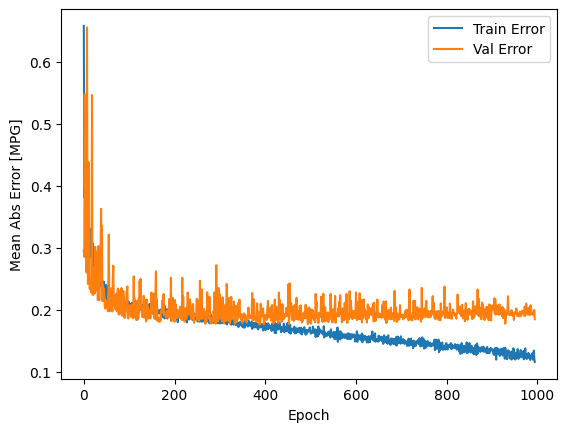

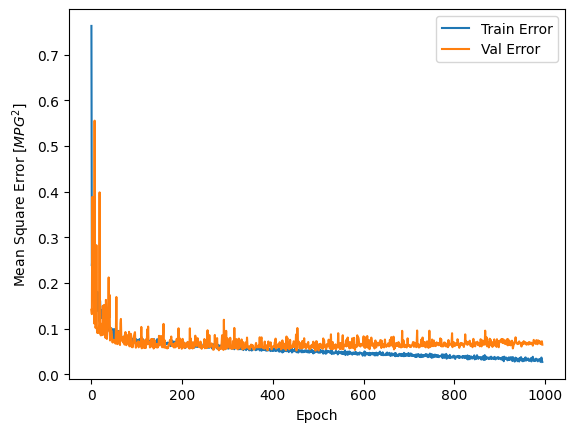

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
CPU times: user 3h 21min 14s, sys: 1h 16min 19s, total: 4h 37min 33s
Wall time: 18min 48s


In [136]:
%%time

galaxy_map = {'for': 0, 'scl': 1, 'umi': 2, 'dra': 3}
df_mag['galaxy_id'] = df_mag['DSPH'].map(galaxy_map)
df_mag['Mg0_Mi0'] = df_mag['Mg0'] - df_mag['Mi0']
df_mag['Mg0_Mn0'] = df_mag['Mg0'] - df_mag['Mn0']

train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(2048, activation='relu', input_shape=(4,)),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(2)  #provides FEH and MGH
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 5000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)

history = model.fit(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']],
                    train_dataset[['FEH', 'MGH']],
                    epochs=EPOCHS, validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
model.save("model.h5")

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n', hist.tail())

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)

# Perform Predictions
test_predictions = model.predict(test_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
test_dataset['FEH_phot_ann'], test_dataset['MGH_phot_ann'] = test_predictions[:, 0], test_predictions[:, 1]
test_dataset['MGFE_phot_ann'] = test_dataset['MGH_phot_ann'] - test_dataset['FEH_phot_ann']
test_dataset.drop(['Mg0_Mi0', 'Mg0_Mn0'], axis=1, inplace=True)

train_predictions = model.predict(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
train_dataset['FEH_phot_ann'], train_dataset['MGH_phot_ann'] = train_predictions[:, 0], train_predictions[:, 1]
train_dataset['MGFE_phot_ann'] = train_dataset['MGH_phot_ann'] - train_dataset['FEH_phot_ann']
train_dataset.drop(['Mg0_Mi0', 'Mg0_Mn0'], axis=1, inplace=True)

#CPU times: user 12min 4s, sys: 6min 6s, total: 18min 11s
#Wall time: 9min

In [137]:
import h5py
with h5py.File('model.h5', 'r') as f:
    print(list(f.keys()))

['model_weights', 'optimizer_weights']


In [138]:
%%time

hsc_df_mag['Mg0_Mi0'] = hsc_df_mag['Mg0'] - hsc_df_mag['Mi0']
hsc_df_mag['Mg0_Mn0'] = hsc_df_mag['Mg0'] - hsc_df_mag['Mn0']
hsc_df_mag['galaxy_id'] = hsc_df_mag['name'].map(galaxy_map)
hsc_predictions = model.predict(hsc_df_mag[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])

hsc_df_mag['FEH_phot_ann'], hsc_df_mag['MGH_phot_ann'] = hsc_predictions[:, 0], hsc_predictions[:, 1]
hsc_df_mag['MGFE_phot_ann'] = hsc_df_mag['MGH_phot_ann'] - hsc_df_mag['FEH_phot_ann']

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']


292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
CPU times: user 21.1 s, sys: 648 ms, total: 21.7 s
Wall time: 4.04 s


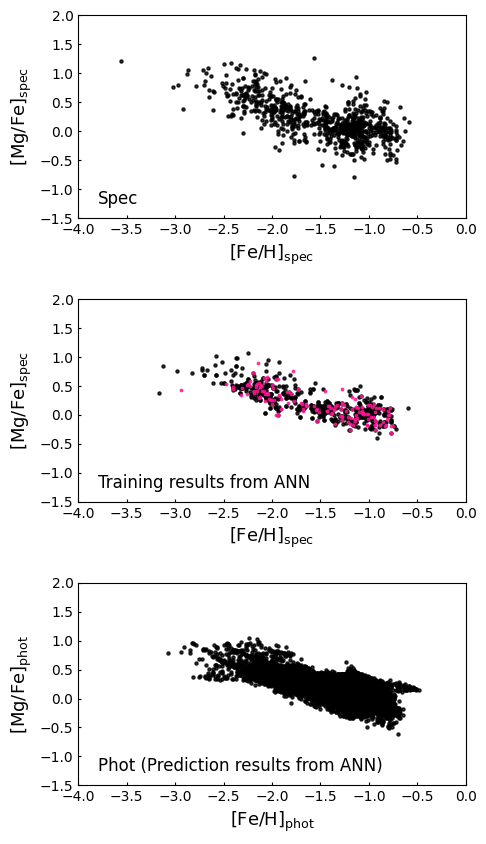

In [139]:
hsc_df_mag_fnx = hsc_df_mag[hsc_df_mag['galaxy_id'] == 0]
hsc_df_mag_scl = hsc_df_mag[hsc_df_mag['galaxy_id'] == 1]
hsc_df_mag_umi = hsc_df_mag[hsc_df_mag['galaxy_id'] == 2]
hsc_df_mag_dra = hsc_df_mag[hsc_df_mag['galaxy_id'] == 3]

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_dataset_fnx['FEH_phot_ann'], train_dataset_fnx['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dataset_scl['FEH_phot_ann'], train_dataset_scl['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dataset_umi['FEH_phot_ann'], train_dataset_umi['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dataset_dra['FEH_phot_ann'], train_dataset_dra['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(test_dataset_fnx['FEH_phot_ann'], test_dataset_fnx['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dataset_scl['FEH_phot_ann'], test_dataset_scl['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dataset_umi['FEH_phot_ann'], test_dataset_umi['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dataset_dra['FEH_phot_ann'], test_dataset_dra['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from ANN', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_df_mag_fnx['FEH_phot_ann'], hsc_df_mag_fnx['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_df_mag_scl['FEH_phot_ann'], hsc_df_mag_scl['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_df_mag_umi['FEH_phot_ann'], hsc_df_mag_umi['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_df_mag_dra['FEH_phot_ann'], hsc_df_mag_dra['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from ANN)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

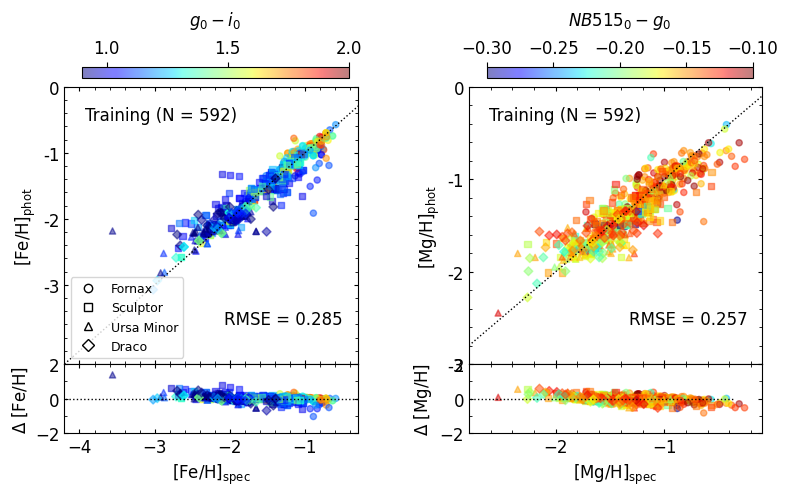

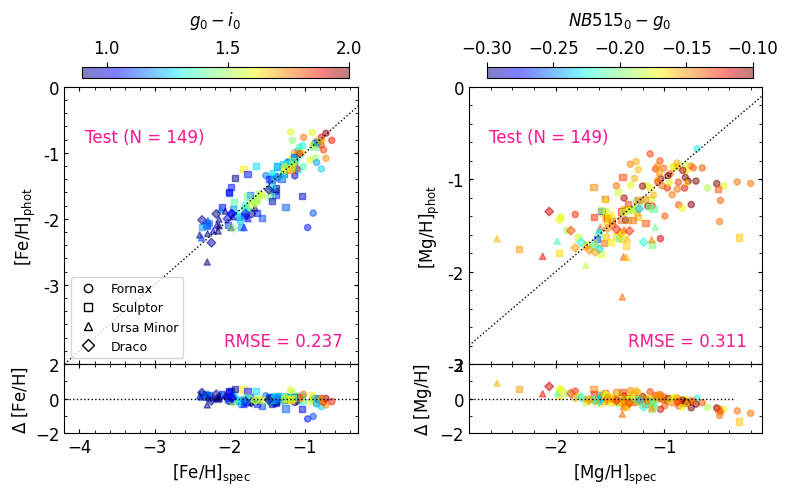

In [140]:
train_dataset_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_dataset_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_dataset_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dataset_dra = train_dataset[train_dataset['galaxy_id'] == 3]

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 20
alpha = 0.5
xmin, xmax = -4.2, -0.3
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', 'D']

ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_dataset_fnx['FEH'], train_dataset_fnx['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_fnx['Mg0']-train_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_dataset_scl['FEH'], train_dataset_scl['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_scl['Mg0']-train_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_dataset_umi['FEH'], train_dataset_umi['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_umi['Mg0']-train_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dataset_dra['FEH'], train_dataset_dra['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_dra['Mg0']-train_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
ax0.legend(handles=custom_legend, loc='lower left', fontsize=9, framealpha=0.8)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.text(0.07, 0.93, 'Training (N = {0:,.0f})'.format(len(train_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12)
#ax0.text(0.07, 0.85, 'Test (N = {0:,.0f})'.format(len(test_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12, color=color)
ax0.text(0.95, 0.13, f'RMSE = {rmse_train_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color='black')
#ax0.text(0.95, 0.05, f'RMSE = {rmse_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color=color)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$g_0 - i_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_dataset_fnx['FEH'], train_dataset_fnx['FEH_phot_ann']-train_dataset_fnx['FEH'], s=s, alpha=alpha, c=train_dataset_fnx['Mg0']-train_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_dataset_scl['FEH'], train_dataset_scl['FEH_phot_ann']-train_dataset_scl['FEH'], s=s, alpha=alpha, c=train_dataset_scl['Mg0']-train_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_dataset_umi['FEH'], train_dataset_umi['FEH_phot_ann']-train_dataset_umi['FEH'], s=s, alpha=alpha, c=train_dataset_umi['Mg0']-train_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dataset_dra['FEH'], train_dataset_dra['FEH_phot_ann']-train_dataset_dra['FEH'], s=s, alpha=alpha, c=train_dataset_dra['Mg0']-train_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax2.set_xlabel('[Fe/H]$_\mathrm{spec}$', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-2, 2])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax2.text(0.4, 0.95, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_train_pred_FEH - Y_train_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10)
#ax2.text(0.4, 0.80, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_pred_FEH - Y_test_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10, color=color)

xmin, xmax = -2.8, -0.1
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_dataset_fnx['MGH'], train_dataset_fnx['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_fnx['Mn0']-train_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_dataset_scl['MGH'], train_dataset_scl['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_scl['Mn0']-train_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_dataset_umi['MGH'], train_dataset_umi['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_umi['Mn0']-train_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dataset_dra['MGH'], train_dataset_dra['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_dra['Mn0']-train_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-3, -2, -1, 0])
ax1.set_yticklabels(['-3', '-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.text(0.07, 0.93, 'Training (N = {0:,.0f})'.format(len(train_dataset)), ha='left', va='top', transform=ax1.transAxes, size=12)
ax1.text(0.95, 0.13, f'RMSE = {rmse_train_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color='black')
#ax1.text(0.95, 0.05, f'RMSE = {rmse_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color=color)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$NB515_0 - g_0$', size=12, labelpad=10, loc='center')
#cbar.ax.set_xticks([1.0, 1.5, 2.0])
#cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_dataset_fnx['MGH'], train_dataset_fnx['MGH_phot_ann']-train_dataset_fnx['MGH'], s=s, alpha=alpha, c=train_dataset_fnx['Mn0']-train_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_dataset_scl['MGH'], train_dataset_scl['MGH_phot_ann']-train_dataset_scl['MGH'], s=s, alpha=alpha, c=train_dataset_scl['Mn0']-train_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_dataset_umi['MGH'], train_dataset_umi['MGH_phot_ann']-train_dataset_umi['MGH'], s=s, alpha=alpha, c=train_dataset_umi['Mn0']-train_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dataset_dra['MGH'], train_dataset_dra['MGH_phot_ann']-train_dataset_dra['MGH'], s=s, alpha=alpha, c=train_dataset_dra['Mn0']-train_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax3.set_xlabel('[Mg/H]$_\mathrm{spec}$', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-2, 2])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()
#plt.savefig('feh_mgh_mgfe_train_pred_test_pred_compare.png', bbox_inches='tight')









test_dataset_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_dataset_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_dataset_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dataset_dra = test_dataset[test_dataset['galaxy_id'] == 3]

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 20
alpha = 0.5
xmin, xmax = -4.2, -0.3
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', 'D']

ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(test_dataset_fnx['FEH'], test_dataset_fnx['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_fnx['Mg0']-test_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(test_dataset_scl['FEH'], test_dataset_scl['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_scl['Mg0']-test_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(test_dataset_umi['FEH'], test_dataset_umi['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_umi['Mg0']-test_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(test_dataset_dra['FEH'], test_dataset_dra['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_dra['Mg0']-test_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
ax0.legend(handles=custom_legend, loc='lower left', fontsize=9, framealpha=0.8)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.07, 0.93, 'Training (N = {0:,.0f})'.format(len(train_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12)
ax0.text(0.07, 0.85, 'Test (N = {0:,.0f})'.format(len(test_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12, color=color)
#ax0.text(0.95, 0.13, f'RMSE = {rmse_train_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color='black')
ax0.text(0.95, 0.05, f'RMSE = {rmse_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color=color)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$g_0 - i_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(test_dataset_fnx['FEH'], test_dataset_fnx['FEH_phot_ann']-test_dataset_fnx['FEH'], s=s, alpha=alpha, c=test_dataset_fnx['Mg0']-test_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(test_dataset_scl['FEH'], test_dataset_scl['FEH_phot_ann']-test_dataset_scl['FEH'], s=s, alpha=alpha, c=test_dataset_scl['Mg0']-test_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(test_dataset_umi['FEH'], test_dataset_umi['FEH_phot_ann']-test_dataset_umi['FEH'], s=s, alpha=alpha, c=test_dataset_umi['Mg0']-test_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(test_dataset_dra['FEH'], test_dataset_dra['FEH_phot_ann']-test_dataset_dra['FEH'], s=s, alpha=alpha, c=test_dataset_dra['Mg0']-test_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax2.set_xlabel('[Fe/H]$_\mathrm{spec}$', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-2, 2])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax2.text(0.4, 0.95, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_train_pred_FEH - Y_train_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10)
#ax2.text(0.4, 0.80, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_pred_FEH - Y_test_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10, color=color)

xmin, xmax = -2.8, -0.1
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(test_dataset_fnx['MGH'], test_dataset_fnx['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_fnx['Mn0']-test_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(test_dataset_scl['MGH'], test_dataset_scl['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_scl['Mn0']-test_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(test_dataset_umi['MGH'], test_dataset_umi['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_umi['Mn0']-test_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(test_dataset_dra['MGH'], test_dataset_dra['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_dra['Mn0']-test_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-3, -2, -1, 0])
ax1.set_yticklabels(['-3', '-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.95, 0.13, f'RMSE = {rmse_train_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color='black')
ax1.text(0.07, 0.85, 'Test (N = {0:,.0f})'.format(len(test_dataset)), ha='left', va='top', transform=ax1.transAxes, size=12, color=color)
ax1.text(0.95, 0.05, f'RMSE = {rmse_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color=color)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$NB515_0 - g_0$', size=12, labelpad=10, loc='center')
#cbar.ax.set_xticks([1.0, 1.5, 2.0])
#cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(test_dataset_fnx['MGH'], test_dataset_fnx['MGH_phot_ann']-test_dataset_fnx['MGH'], s=s, alpha=alpha, c=test_dataset_fnx['Mn0']-test_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(test_dataset_scl['MGH'], test_dataset_scl['MGH_phot_ann']-test_dataset_scl['MGH'], s=s, alpha=alpha, c=test_dataset_scl['Mn0']-test_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(test_dataset_umi['MGH'], test_dataset_umi['MGH_phot_ann']-test_dataset_umi['MGH'], s=s, alpha=alpha, c=test_dataset_umi['Mn0']-test_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(test_dataset_dra['MGH'], test_dataset_dra['MGH_phot_ann']-test_dataset_dra['MGH'], s=s, alpha=alpha, c=test_dataset_dra['Mn0']-test_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax3.set_xlabel('[Mg/H]$_\mathrm{spec}$', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-2, 2])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()
#plt.savefig('feh_mgh_mgfe_train_pred_test_pred_compare.png', bbox_inches='tight')

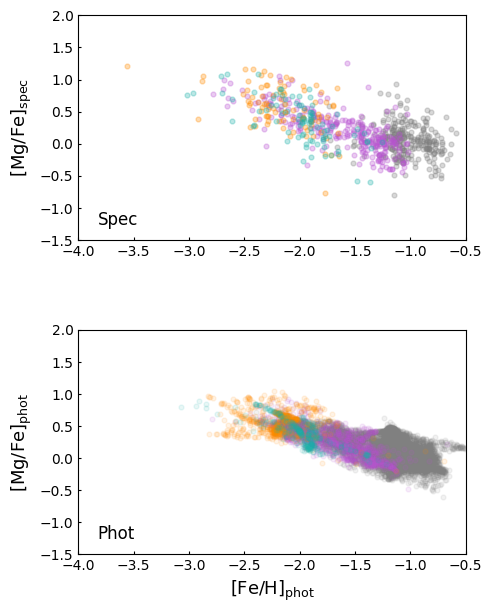

In [141]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(5,7), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 12
alpha = 0.3

# Spectroscopy
#ax0.errorbar(fnx_mag['FEH'], fnx_mag['MGFE'], xerr=fnx_mag['FEHERR'], yerr=fnx_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='gray')
#ax0.errorbar(scl_mag['FEH'], scl_mag['MGFE'], xerr=scl_mag['FEHERR'], yerr=scl_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='mediumorchid')
#ax0.errorbar(umi_mag['FEH'], umi_mag['MGFE'], xerr=umi_mag['FEHERR'], yerr=umi_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='darkorange')
#ax0.errorbar(dra_mag['FEH'], dra_mag['MGFE'], xerr=dra_mag['FEHERR'], yerr=dra_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='lightseagreen')
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=0.3, color='gray')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=0.3, color='mediumorchid')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=0.3, color='darkorange')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=0.3, color='lightseagreen')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, -0.5])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Photometry
#ax1.errorbar(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], xerr=hsc_fnx_mag['FEH_phot_ann_uncertainty'], yerr=hsc_fnx_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='gray')
#ax1.errorbar(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], xerr=hsc_scl_mag['FEH_phot_ann_uncertainty'], yerr=hsc_scl_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='mediumorchid')
#ax1.errorbar(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], xerr=hsc_umi_mag['FEH_phot_ann_uncertainty'], yerr=hsc_umi_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='darkorange')
#ax1.errorbar(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], xerr=hsc_dra_mag['FEH_phot_ann_uncertainty'], yerr=hsc_dra_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='lightseagreen')
ax1.scatter(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], s=s, alpha=0.1, color='gray')
ax1.scatter(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], s=s, alpha=0.1, color='mediumorchid')
ax1.scatter(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], s=s, alpha=0.1, color='darkorange')
ax1.scatter(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], s=s, alpha=0.1, color='lightseagreen')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax1.set_xlim([-4, -0.5])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Phot', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

plt.show()
#plt.savefig('compare_ann_spec_phot_mgfe_feh_together.png', bbox_inches='tight')

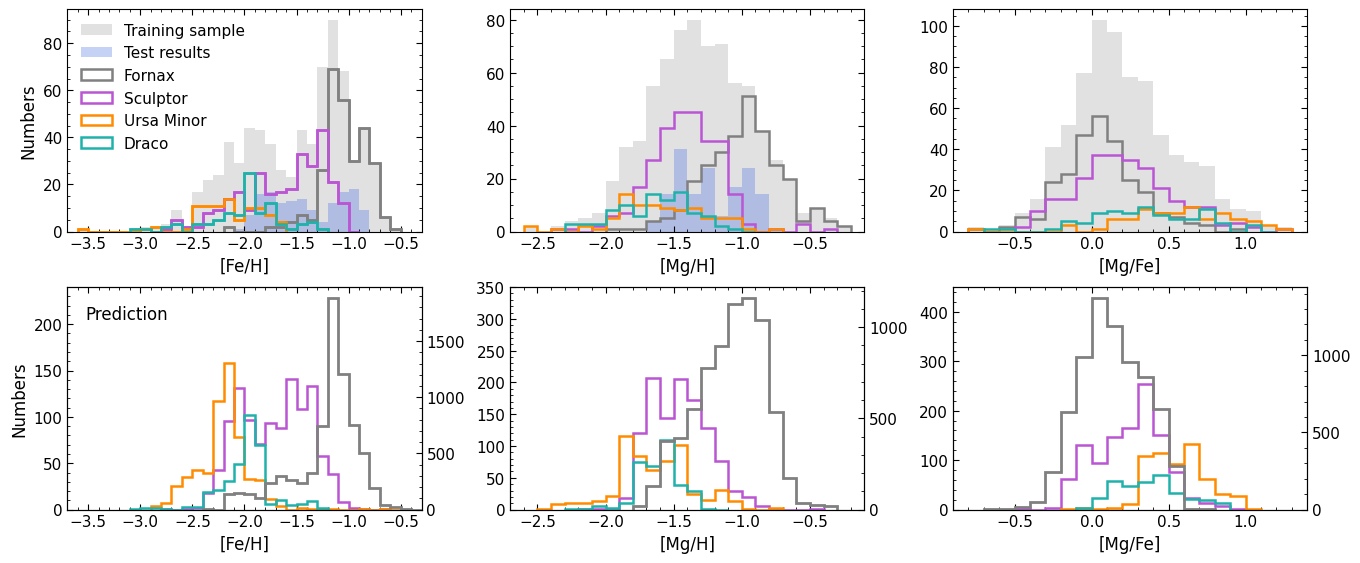

In [142]:
from matplotlib.ticker import MultipleLocator

def plot_histogram(ax, data_list, labels, colors, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=1)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=1)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=2)
    plot_histogram(ax, data_list, labels, colors, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})

bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Training sample')
ax0.hist(Y_pred[:, 0], bins=np.arange(np.floor(np.min(Y_pred[:, 0]) / bins_width) * bins_width,
                                     np.ceil(np.max(Y_pred[:, 0]) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(Y_pred[:, 1], bins=np.arange(np.floor(np.min(Y_pred[:, 1]) / bins_width) * bins_width,
                                     np.ceil(np.max(Y_pred[:, 1]) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row 
plot_with_twinx(ax3.twinx(), ax3, 
                hsc_fnx_mag['FEH_phot_ann'], [hsc_scl_mag['FEH_phot_ann'], hsc_umi_mag['FEH_phot_ann'], hsc_dra_mag['FEH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_ylim([0, 240])
ax3.text(0.05, 0.92, 'Prediction', ha='left', va='top', transform=ax3.transAxes, size=12)
ax3.set_xlim([-3.7, -0.3])

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_ann'], [hsc_scl_mag['MGH_phot_ann'], hsc_umi_mag['MGH_phot_ann'], hsc_dra_mag['MGH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_ylim([0, 350])
ax4.set_xlim([-2.7, -0.1])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_ann'], [hsc_scl_mag['MGFE_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], hsc_dra_mag['MGFE_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_ylim([0, 450])
ax5.set_xlim([-0.9, 1.4])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

# Save the plot
plt.savefig('compare_ann_feh_mgh_mgfe.png', bbox_inches='tight')

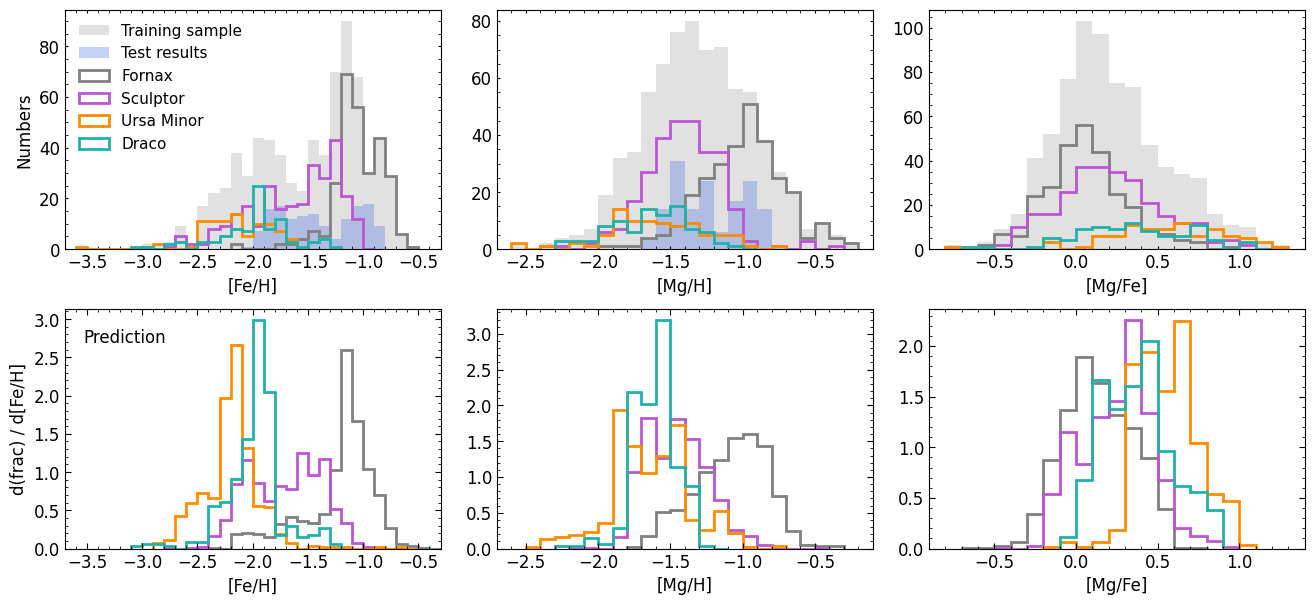

In [143]:
bins_width = 0.1
alpha = 1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 7), gridspec_kw={'wspace': 0.15, 'hspace': 0.25})

data_dict_feh = {
    'Training sample': (df_mag['FEH'], 'dimgray', 0.2),
    'Test results': (Y_pred[:, 0], 'royalblue', 0.3),
    'Fornax': (fnx_mag['FEH'], colors[0], alpha),
    'Sculptor': (scl_mag['FEH'], colors[1], alpha),
    'Ursa Minor': (umi_mag['FEH'], colors[2], alpha),
    'Draco': (dra_mag['FEH'], colors[3], alpha)
}

data_dict_mgh = {
    'Training sample': (df_mag['MGH'], 'dimgray', 0.2),
    'Test results': (Y_pred[:, 1], 'royalblue', 0.3),
    'Fornax': (fnx_mag['MGH'], colors[0], alpha),
    'Sculptor': (scl_mag['MGH'], colors[1], alpha),
    'Ursa Minor': (umi_mag['MGH'], colors[2], alpha),
    'Draco': (dra_mag['MGH'], colors[3], alpha)
}

data_dict_mgfe = {
    'Training sample': (df_mag['MGFE'], 'dimgray', 0.2),
    'Fornax': (fnx_mag['MGFE'], colors[0], alpha),
    'Sculptor': (scl_mag['MGFE'], colors[1], alpha),
    'Ursa Minor': (umi_mag['MGFE'], colors[2], alpha),
    'Draco': (dra_mag['MGFE'], colors[3], alpha)
}

for data_dict, ax, xlabel in zip(
        [data_dict_feh, data_dict_mgh, data_dict_mgfe],  
        [ax0, ax1, ax2],  
        ['[Fe/H]', '[Mg/H]', '[Mg/Fe]']
):
    for label, (data, color, alpha_value) in data_dict.items():
        bins = np.arange(np.floor(np.min(data) / bins_width) * bins_width, 
                         np.ceil(np.max(data) / bins_width) * bins_width + bins_width, 
                         bins_width)
        ax.hist(data, bins=bins, histtype='step' if label not in ['Training sample', 'Test results'] else 'stepfilled', color=color, alpha=alpha_value, label=label, linewidth=2)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel('')
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=2.5, labelsize=12)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=2.5, labelsize=12)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_ylabel('Numbers', size=12)
ax0.legend(loc='upper left', frameon=False, fontsize=11)
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)


def create_data_sets(data_dict, labels, colors):
    return [(data_dict[label], label, color) for label, color in zip(labels, colors)]

data_sets = [
    ('FEH_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag),
    ('MGH_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag),
    ('MGFE_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag)
]

data_sets_list = []
for feature in data_sets:
    feature_name, *datasets = feature
    data_sets_list.append(create_data_sets({label: data[feature_name] for label, data in zip(labels, datasets)}, labels, colors))

def plot_histogram(ax, data, bins_width, label, color, alpha=0.8):
    color_dict = {
        'Fornax': 'gray',
        'Sculptor': 'mediumorchid',
        'Ursa Minor': 'darkorange',
        'Draco': 'lightseagreen',
        'Training sample': 'dimgray',
        'Test results': 'royalblue'
    }
    color = color_dict.get(label, 'gray')
    
    bins = np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                     bins_width)
    counts, bin_edges = np.histogram(data, bins=bins)
    frac_dfeh = counts / (len(data) * bins_width)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    ax.stairs(frac_dfeh, bin_edges, label=label, color=color, linewidth=2)
    
    return ax

def plot_data_on_ax(ax, data_sets, xlabel, ylabel, xticks=None):
    for data, label, color in data_sets:
        plot_histogram(ax, data, bins_width, label, color, alpha=alpha)
    ax.set_ylim(bottom=0)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=12)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=12)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    
    if xticks:
        ax.set_xticks(xticks)

data_sets_0 = data_sets_list[0]
data_sets_1 = data_sets_list[1]
data_sets_2 = data_sets_list[2]
plot_data_on_ax(ax3, data_sets_0, '[Fe/H]', 'd(frac) / d[Fe/H]')
plot_data_on_ax(ax4, data_sets_1, '[Mg/H]', '')
plot_data_on_ax(ax5, data_sets_2, '[Mg/Fe]', '', xticks=[-0.5, 0.0, 0.5, 1.0])
ax3.text(0.05, 0.92, 'Prediction', ha='left', va='top', transform=ax3.transAxes, size=12)

ax0.set_xlim([-3.7, -0.3])
ax1.set_xlim([-2.7, -0.1])
ax2.set_xlim([-0.9, 1.4])
ax3.set_xlim([-3.7, -0.3])
ax4.set_xlim([-2.7, -0.1])
ax5.set_xlim([-0.9, 1.4])

plt.savefig('compare_ann_feh_mgh_mgfe_dfrac_dfeh.png', bbox_inches='tight')

In [ ]:
# Trial with Expanded data

In [147]:
## Read HSC-DEIMOS files
fnx = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Fornax_HSC_DEIMOS_plus_w_age.csv')
scl = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Sculptor_HSC_DEIMOS_plus_w_age.csv')
umi = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Ursaminor_HSC_DEIMOS_plus_w_age.csv')
dra = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Draco_HSC_DEIMOS_plus_w_age.csv')
print(f'len(fnx) = {len(fnx)}') #485 -> 308
print(f'len(scl) = {len(scl)}') #405 -> 283
print(f'len(umi) = {len(umi)}') #263 -> 93
print(f'len(dra) = {len(dra)}') #168 -> 93

## Read whole HSC data
hsc_fnx = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/fornax_tpall3e_g24_radec_members_cut.csv')
hsc_scl = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/sculptor_tpall3e_g24_radec_members_cut.csv')
hsc_umi = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/ursaminor_tpall3e_g24_radec_members_cut.csv')
hsc_dra = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/draco_tpall3e_g24_radec_members_cut.csv')
print(f'len(hsc_fnx) = {len(hsc_fnx)}') #23089
print(f'len(hsc_scl) = {len(hsc_scl)}') #2137
print(f'len(hsc_umi) = {len(hsc_umi)}') #921
print(f'len(hsc_dra) = {len(hsc_dra)}') #478

len(fnx) = 308
len(scl) = 283
len(umi) = 93
len(dra) = 93
len(hsc_fnx) = 23089
len(hsc_scl) = 2137
len(hsc_umi) = 921
len(hsc_dra) = 478


In [148]:
umi = pd.concat([umi] * 3, ignore_index=True)
print(f'len(umi) = {len(umi)}')  # 93 * 3 = 279
dra = pd.concat([dra] * 3, ignore_index=True)
print(f'len(dra) = {len(dra)}')  # 93 * 3 = 279

len(umi) = 279
len(dra) = 279


In [149]:
# Define the distance modulus for each dataset from McConnachie (2012)
dm_values = {
    'fnx': 20.84,
    'scl': 19.67,
    'umi': 19.4,
    'dra': 19.4
}

# Define the datasets
datasets = {
    'fnx': [fnx, hsc_fnx],
    'scl': [scl, hsc_scl],
    'umi': [umi, hsc_umi],
    'dra': [dra, hsc_dra]
}

# Apply the distance modulus correction and store as G0
for key, dataset_list in datasets.items():
    dm = dm_values[key]
    for dataset in dataset_list:
        dataset['Mg0'] = dataset['g0'] - dm
        dataset['Mi0'] = dataset['i0'] - dm
        dataset['Mn0'] = dataset['n0'] - dm

In [150]:
xmin, xmax = 0.4, 2

Mg0_max = -0.20 ; Mn0_max = -0.30 ; Mi0_max = -1.18
fnx_mag = fnx[(xmin < fnx['Mg0']-fnx['Mi0']) & (fnx['Mg0']-fnx['Mi0'] < xmax) & (fnx['Mg0'] < Mg0_max) & (fnx['Mn0'] < Mn0_max) & (fnx['Mi0'] < Mi0_max)]
print('len(fnx_mag) =', len(fnx), '->', len(fnx_mag)) #308 -> 283
hsc_fnx_mag = hsc_fnx[(xmin < hsc_fnx['Mg0']-hsc_fnx['Mi0']) & (hsc_fnx['Mg0']-hsc_fnx['Mi0'] < xmax) & (hsc_fnx['Mg0'] < Mg0_max) & (hsc_fnx['Mn0'] < Mn0_max) & (hsc_fnx['Mi0'] < Mi0_max)]
print('len(hsc_fnx_mag) =', len(hsc_fnx), '->', len(hsc_fnx_mag)) #23089 -> 7251

Mg0_max = 0.18 ; Mn0_max = 0.08 ; Mi0_max = -0.70
scl_mag = scl[(xmin < scl['Mg0']-scl['Mi0']) & (scl['Mg0']-scl['Mi0'] < xmax) & (scl['Mg0'] < Mg0_max) & (scl['Mn0'] < Mn0_max) & (scl['Mi0'] < Mi0_max)]
print('len(scl_mag) =', len(scl), '->', len(scl_mag)) #283 -> 280
hsc_scl_mag = hsc_scl[(xmin < hsc_scl['Mg0']-hsc_scl['Mi0']) & (hsc_scl['Mg0']-hsc_scl['Mi0'] < xmax) & (hsc_scl['Mg0'] < Mg0_max) & (hsc_scl['Mn0'] < Mn0_max) & (hsc_scl['Mi0'] < Mi0_max)]
print('len(hsc_scl_mag) =', len(hsc_scl), '->', len(hsc_scl_mag)) #2137 -> 1132

Mg0_max = 1.00 ; Mn0_max = 0.85 ; Mi0_max = 0.15
umi_mag = umi[(xmin < umi['Mg0']-umi['Mi0']) & (umi['Mg0']-umi['Mi0'] < xmax) & (umi['Mg0'] < Mg0_max) & (umi['Mn0'] < Mn0_max) & (umi['Mi0'] < Mi0_max)]
print('len(umi_mag) =', len(umi), '->', len(umi_mag)) #93 -> 88
hsc_umi_mag = hsc_umi[(xmin < hsc_umi['Mg0']-hsc_umi['Mi0']) & (hsc_umi['Mg0']-hsc_umi['Mi0'] < xmax) & (hsc_umi['Mg0'] < Mg0_max) & (hsc_umi['Mn0'] < Mn0_max) & (hsc_umi['Mi0'] < Mi0_max)]
print('len(hsc_umi_mag) =', len(hsc_umi), '->', len(hsc_umi_mag)) #921 -> 593

Mg0_max = 0.65 ; Mn0_max = 0.50 ; Mi0_max = -0.20
dra_mag = dra[(xmin < dra['Mg0']-dra['Mi0']) & (dra['Mg0']-dra['Mi0'] < xmax) & (dra['Mg0'] < Mg0_max) & (dra['Mn0'] < Mn0_max) & (dra['Mi0'] < Mi0_max)]
print('len(dra_mag) =', len(dra), '->', len(dra_mag)) #93 -> 90
hsc_dra_mag = hsc_dra[(xmin < hsc_dra['Mg0']-hsc_dra['Mi0']) & (hsc_dra['Mg0']-hsc_dra['Mi0'] < xmax) & (hsc_dra['Mg0'] < Mg0_max) & (hsc_dra['Mn0'] < Mn0_max) & (hsc_dra['Mi0'] < Mi0_max)]
print('len(hsc_dra_mag) =', len(hsc_dra), '->', len(hsc_dra_mag)) #478 -> 342

len(fnx_mag) = 308 -> 283
len(hsc_fnx_mag) = 23089 -> 7251
len(scl_mag) = 283 -> 280
len(hsc_scl_mag) = 2137 -> 1132
len(umi_mag) = 279 -> 264
len(hsc_umi_mag) = 921 -> 593
len(dra_mag) = 279 -> 270
len(hsc_dra_mag) = 478 -> 342


In [151]:
# Combine DEIMOS
frame = [fnx_mag, scl_mag, umi_mag, dra_mag]
df_mag = pd.concat(frame, ignore_index=True)
print('len(df_mag) =', len(df_mag)) #741
print(Counter(df_mag['DSPH'])) #Counter({'for': 283, 'scl': 280, 'dra': 90, 'umi': 88})

# Combine HSC
frame = [hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag]
hsc_df_mag = pd.concat(frame, ignore_index=True)
print('len(hsc_df_mag) =', len(hsc_df_mag)) #9318
print(Counter(hsc_df_mag['name'])) #Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342})

len(df_mag) = 1097
Counter({'for': 283, 'scl': 280, 'dra': 270, 'umi': 264})
len(hsc_df_mag) = 9318
Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342})


In [152]:
%%time

df_mag_ohe = pd.get_dummies(df_mag, columns=['DSPH'])
df_mag_ohe['galaxy_id'] = (
    0 * df_mag_ohe['DSPH_for'] +
    1 * df_mag_ohe['DSPH_scl'] +
    2 * df_mag_ohe['DSPH_umi'] +
    3 * df_mag_ohe['DSPH_dra']
)
df_mag['galaxy_id'] = df_mag['DSPH'].map(galaxy_map)
df_mag['Mg0_Mi0'] = df_mag['Mg0'] - df_mag['Mi0']
df_mag['Mg0_Mn0'] = df_mag['Mg0'] - df_mag['Mn0']

train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(2048, activation='relu', input_shape=(4,)),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(2)  #provides FEH and MGH
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 5000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)

history = model.fit(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']],
                    train_dataset[['FEH', 'MGH']],
                    epochs=EPOCHS, validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
model.save("model.h5")

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n', hist.tail())

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)

# Perform Predictions
test_predictions = model.predict(test_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
test_dataset['FEH_phot_ann'], test_dataset['MGH_phot_ann'] = test_predictions[:, 0], test_predictions[:, 1]
test_dataset['MGFE_phot_ann'] = test_dataset['MGH_phot_ann'] - test_dataset['FEH_phot_ann']
test_dataset.drop(['Mg0_Mi0', 'Mg0_Mn0'], axis=1, inplace=True)

train_predictions = model.predict(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
train_dataset['FEH_phot_ann'], train_dataset['MGH_phot_ann'] = train_predictions[:, 0], train_predictions[:, 1]
train_dataset['MGFE_phot_ann'] = train_dataset['MGH_phot_ann'] - train_dataset['FEH_phot_ann']
train_dataset.drop(['Mg0_Mi0', 'Mg0_Mn0'], axis=1, inplace=True)

#CPU times: user 12min 4s, sys: 6min 6s, total: 18min 11s
#Wall time: 9min

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 2048)           │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,807,842 (10.71 MB)

 Trainable params: 2,807,842 (10.71 MB)

 Non-trainable params: 0 (0.00 B)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.....................................................................................

KeyboardInterrupt: 

In [153]:
%%time

hsc_df_mag['Mg0_Mi0'] = hsc_df_mag['Mg0'] - hsc_df_mag['Mi0']
hsc_df_mag['Mg0_Mn0'] = hsc_df_mag['Mg0'] - hsc_df_mag['Mn0']
hsc_df_mag['galaxy_id'] = hsc_df_mag['name'].map(galaxy_map)
hsc_predictions = model.predict(hsc_df_mag[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])

hsc_df_mag['FEH_phot_ann'], hsc_df_mag['MGH_phot_ann'] = hsc_predictions[:, 0], hsc_predictions[:, 1]
hsc_df_mag['MGFE_phot_ann'] = hsc_df_mag['MGH_phot_ann'] - hsc_df_mag['FEH_phot_ann']

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']


292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
CPU times: user 24.1 s, sys: 570 ms, total: 24.7 s
Wall time: 4.55 s


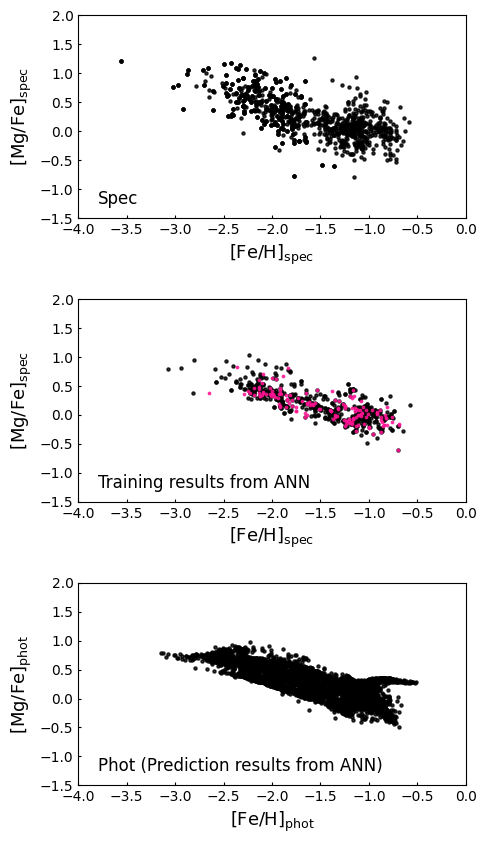

In [154]:
hsc_df_mag_fnx = hsc_df_mag[hsc_df_mag['galaxy_id'] == 0]
hsc_df_mag_scl = hsc_df_mag[hsc_df_mag['galaxy_id'] == 1]
hsc_df_mag_umi = hsc_df_mag[hsc_df_mag['galaxy_id'] == 2]
hsc_df_mag_dra = hsc_df_mag[hsc_df_mag['galaxy_id'] == 3]

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_dataset_fnx['FEH_phot_ann'], train_dataset_fnx['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dataset_scl['FEH_phot_ann'], train_dataset_scl['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dataset_umi['FEH_phot_ann'], train_dataset_umi['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dataset_dra['FEH_phot_ann'], train_dataset_dra['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(test_dataset_fnx['FEH_phot_ann'], test_dataset_fnx['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dataset_scl['FEH_phot_ann'], test_dataset_scl['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dataset_umi['FEH_phot_ann'], test_dataset_umi['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dataset_dra['FEH_phot_ann'], test_dataset_dra['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from ANN', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_df_mag_fnx['FEH_phot_ann'], hsc_df_mag_fnx['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_df_mag_scl['FEH_phot_ann'], hsc_df_mag_scl['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_df_mag_umi['FEH_phot_ann'], hsc_df_mag_umi['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_df_mag_dra['FEH_phot_ann'], hsc_df_mag_dra['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from ANN)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

KeyError: 'FEH_phot_ann'

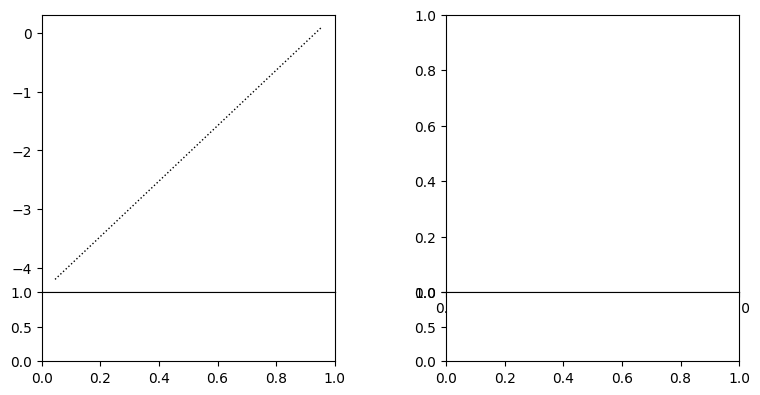

In [155]:
train_dataset_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_dataset_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_dataset_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dataset_dra = train_dataset[train_dataset['galaxy_id'] == 3]

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 20
alpha = 0.5
xmin, xmax = -4.2, -0.3
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', 'D']

ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_dataset_fnx['FEH'], train_dataset_fnx['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_fnx['Mg0']-train_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_dataset_scl['FEH'], train_dataset_scl['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_scl['Mg0']-train_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_dataset_umi['FEH'], train_dataset_umi['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_umi['Mg0']-train_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dataset_dra['FEH'], train_dataset_dra['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_dra['Mg0']-train_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
ax0.legend(handles=custom_legend, loc='lower left', fontsize=9, framealpha=0.8)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.text(0.07, 0.93, 'Training (N = {0:,.0f})'.format(len(train_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12)
#ax0.text(0.07, 0.85, 'Test (N = {0:,.0f})'.format(len(test_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12, color=color)
ax0.text(0.95, 0.13, f'RMSE = {rmse_train_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color='black')
#ax0.text(0.95, 0.05, f'RMSE = {rmse_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color=color)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$g_0 - i_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_dataset_fnx['FEH'], train_dataset_fnx['FEH_phot_ann']-train_dataset_fnx['FEH'], s=s, alpha=alpha, c=train_dataset_fnx['Mg0']-train_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_dataset_scl['FEH'], train_dataset_scl['FEH_phot_ann']-train_dataset_scl['FEH'], s=s, alpha=alpha, c=train_dataset_scl['Mg0']-train_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_dataset_umi['FEH'], train_dataset_umi['FEH_phot_ann']-train_dataset_umi['FEH'], s=s, alpha=alpha, c=train_dataset_umi['Mg0']-train_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dataset_dra['FEH'], train_dataset_dra['FEH_phot_ann']-train_dataset_dra['FEH'], s=s, alpha=alpha, c=train_dataset_dra['Mg0']-train_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax2.set_xlabel('[Fe/H]$_\mathrm{spec}$', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-2, 2])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax2.text(0.4, 0.95, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_train_pred_FEH - Y_train_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10)
#ax2.text(0.4, 0.80, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_pred_FEH - Y_test_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10, color=color)

xmin, xmax = -2.8, -0.1
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_dataset_fnx['MGH'], train_dataset_fnx['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_fnx['Mn0']-train_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_dataset_scl['MGH'], train_dataset_scl['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_scl['Mn0']-train_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_dataset_umi['MGH'], train_dataset_umi['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_umi['Mn0']-train_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dataset_dra['MGH'], train_dataset_dra['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_dra['Mn0']-train_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-3, -2, -1, 0])
ax1.set_yticklabels(['-3', '-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.text(0.07, 0.93, 'Training (N = {0:,.0f})'.format(len(train_dataset)), ha='left', va='top', transform=ax1.transAxes, size=12)
ax1.text(0.95, 0.13, f'RMSE = {rmse_train_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color='black')
#ax1.text(0.95, 0.05, f'RMSE = {rmse_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color=color)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$NB515_0 - g_0$', size=12, labelpad=10, loc='center')
#cbar.ax.set_xticks([1.0, 1.5, 2.0])
#cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_dataset_fnx['MGH'], train_dataset_fnx['MGH_phot_ann']-train_dataset_fnx['MGH'], s=s, alpha=alpha, c=train_dataset_fnx['Mn0']-train_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_dataset_scl['MGH'], train_dataset_scl['MGH_phot_ann']-train_dataset_scl['MGH'], s=s, alpha=alpha, c=train_dataset_scl['Mn0']-train_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_dataset_umi['MGH'], train_dataset_umi['MGH_phot_ann']-train_dataset_umi['MGH'], s=s, alpha=alpha, c=train_dataset_umi['Mn0']-train_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dataset_dra['MGH'], train_dataset_dra['MGH_phot_ann']-train_dataset_dra['MGH'], s=s, alpha=alpha, c=train_dataset_dra['Mn0']-train_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax3.set_xlabel('[Mg/H]$_\mathrm{spec}$', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-2, 2])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()
#plt.savefig('feh_mgh_mgfe_train_pred_test_pred_compare.png', bbox_inches='tight')









test_dataset_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_dataset_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_dataset_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dataset_dra = test_dataset[test_dataset['galaxy_id'] == 3]

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 20
alpha = 0.5
xmin, xmax = -4.2, -0.3
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', 'D']

ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(test_dataset_fnx['FEH'], test_dataset_fnx['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_fnx['Mg0']-test_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(test_dataset_scl['FEH'], test_dataset_scl['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_scl['Mg0']-test_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(test_dataset_umi['FEH'], test_dataset_umi['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_umi['Mg0']-test_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(test_dataset_dra['FEH'], test_dataset_dra['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_dra['Mg0']-test_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
ax0.legend(handles=custom_legend, loc='lower left', fontsize=9, framealpha=0.8)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.07, 0.93, 'Training (N = {0:,.0f})'.format(len(train_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12)
ax0.text(0.07, 0.85, 'Test (N = {0:,.0f})'.format(len(test_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12, color=color)
#ax0.text(0.95, 0.13, f'RMSE = {rmse_train_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color='black')
ax0.text(0.95, 0.05, f'RMSE = {rmse_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color=color)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$g_0 - i_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(test_dataset_fnx['FEH'], test_dataset_fnx['FEH_phot_ann']-test_dataset_fnx['FEH'], s=s, alpha=alpha, c=test_dataset_fnx['Mg0']-test_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(test_dataset_scl['FEH'], test_dataset_scl['FEH_phot_ann']-test_dataset_scl['FEH'], s=s, alpha=alpha, c=test_dataset_scl['Mg0']-test_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(test_dataset_umi['FEH'], test_dataset_umi['FEH_phot_ann']-test_dataset_umi['FEH'], s=s, alpha=alpha, c=test_dataset_umi['Mg0']-test_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(test_dataset_dra['FEH'], test_dataset_dra['FEH_phot_ann']-test_dataset_dra['FEH'], s=s, alpha=alpha, c=test_dataset_dra['Mg0']-test_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax2.set_xlabel('[Fe/H]$_\mathrm{spec}$', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-2, 2])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax2.text(0.4, 0.95, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_train_pred_FEH - Y_train_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10)
#ax2.text(0.4, 0.80, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_pred_FEH - Y_test_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10, color=color)

xmin, xmax = -2.8, -0.1
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(test_dataset_fnx['MGH'], test_dataset_fnx['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_fnx['Mn0']-test_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(test_dataset_scl['MGH'], test_dataset_scl['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_scl['Mn0']-test_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(test_dataset_umi['MGH'], test_dataset_umi['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_umi['Mn0']-test_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(test_dataset_dra['MGH'], test_dataset_dra['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_dra['Mn0']-test_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-3, -2, -1, 0])
ax1.set_yticklabels(['-3', '-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.95, 0.13, f'RMSE = {rmse_train_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color='black')
ax1.text(0.07, 0.85, 'Test (N = {0:,.0f})'.format(len(test_dataset)), ha='left', va='top', transform=ax1.transAxes, size=12, color=color)
ax1.text(0.95, 0.05, f'RMSE = {rmse_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color=color)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$NB515_0 - g_0$', size=12, labelpad=10, loc='center')
#cbar.ax.set_xticks([1.0, 1.5, 2.0])
#cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(test_dataset_fnx['MGH'], test_dataset_fnx['MGH_phot_ann']-test_dataset_fnx['MGH'], s=s, alpha=alpha, c=test_dataset_fnx['Mn0']-test_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(test_dataset_scl['MGH'], test_dataset_scl['MGH_phot_ann']-test_dataset_scl['MGH'], s=s, alpha=alpha, c=test_dataset_scl['Mn0']-test_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(test_dataset_umi['MGH'], test_dataset_umi['MGH_phot_ann']-test_dataset_umi['MGH'], s=s, alpha=alpha, c=test_dataset_umi['Mn0']-test_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(test_dataset_dra['MGH'], test_dataset_dra['MGH_phot_ann']-test_dataset_dra['MGH'], s=s, alpha=alpha, c=test_dataset_dra['Mn0']-test_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax3.set_xlabel('[Mg/H]$_\mathrm{spec}$', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-2, 2])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()
#plt.savefig('feh_mgh_mgfe_train_pred_test_pred_compare.png', bbox_inches='tight')

In [ ]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(5,7), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 12
alpha = 0.3

# Spectroscopy
#ax0.errorbar(fnx_mag['FEH'], fnx_mag['MGFE'], xerr=fnx_mag['FEHERR'], yerr=fnx_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='gray')
#ax0.errorbar(scl_mag['FEH'], scl_mag['MGFE'], xerr=scl_mag['FEHERR'], yerr=scl_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='mediumorchid')
#ax0.errorbar(umi_mag['FEH'], umi_mag['MGFE'], xerr=umi_mag['FEHERR'], yerr=umi_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='darkorange')
#ax0.errorbar(dra_mag['FEH'], dra_mag['MGFE'], xerr=dra_mag['FEHERR'], yerr=dra_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='lightseagreen')
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=0.3, color='gray')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=0.3, color='mediumorchid')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=0.3, color='darkorange')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=0.3, color='lightseagreen')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, -0.5])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Photometry
#ax1.errorbar(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], xerr=hsc_fnx_mag['FEH_phot_ann_uncertainty'], yerr=hsc_fnx_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='gray')
#ax1.errorbar(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], xerr=hsc_scl_mag['FEH_phot_ann_uncertainty'], yerr=hsc_scl_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='mediumorchid')
#ax1.errorbar(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], xerr=hsc_umi_mag['FEH_phot_ann_uncertainty'], yerr=hsc_umi_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='darkorange')
#ax1.errorbar(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], xerr=hsc_dra_mag['FEH_phot_ann_uncertainty'], yerr=hsc_dra_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='lightseagreen')
ax1.scatter(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], s=s, alpha=0.1, color='gray')
ax1.scatter(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], s=s, alpha=0.1, color='mediumorchid')
ax1.scatter(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], s=s, alpha=0.1, color='darkorange')
ax1.scatter(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], s=s, alpha=0.1, color='lightseagreen')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax1.set_xlim([-4, -0.5])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Phot', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

plt.show()
#plt.savefig('compare_ann_spec_phot_mgfe_feh_together.png', bbox_inches='tight')

In [ ]:
from matplotlib.ticker import MultipleLocator

def plot_histogram(ax, data_list, labels, colors, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=1)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=1)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=2)
    plot_histogram(ax, data_list, labels, colors, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})

bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Training sample')
ax0.hist(Y_pred[:, 0], bins=np.arange(np.floor(np.min(Y_pred[:, 0]) / bins_width) * bins_width,
                                     np.ceil(np.max(Y_pred[:, 0]) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(Y_pred[:, 1], bins=np.arange(np.floor(np.min(Y_pred[:, 1]) / bins_width) * bins_width,
                                     np.ceil(np.max(Y_pred[:, 1]) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row 
plot_with_twinx(ax3.twinx(), ax3, 
                hsc_fnx_mag['FEH_phot_ann'], [hsc_scl_mag['FEH_phot_ann'], hsc_umi_mag['FEH_phot_ann'], hsc_dra_mag['FEH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_ylim([0, 240])
ax3.text(0.05, 0.92, 'Prediction', ha='left', va='top', transform=ax3.transAxes, size=12)
ax3.set_xlim([-3.7, -0.3])

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_ann'], [hsc_scl_mag['MGH_phot_ann'], hsc_umi_mag['MGH_phot_ann'], hsc_dra_mag['MGH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_ylim([0, 350])
ax4.set_xlim([-2.7, -0.1])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_ann'], [hsc_scl_mag['MGFE_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], hsc_dra_mag['MGFE_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_ylim([0, 450])
ax5.set_xlim([-0.9, 1.4])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

# Save the plot
plt.show()
#plt.savefig('compare_ann_feh_mgh_mgfe.png', bbox_inches='tight')

In [ ]:
bins_width = 0.1
alpha = 1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 7), gridspec_kw={'wspace': 0.15, 'hspace': 0.25})

data_dict_feh = {
    'Training sample': (df_mag['FEH'], 'dimgray', 0.2),
    'Test results': (Y_pred[:, 0], 'royalblue', 0.3),
    'Fornax': (fnx_mag['FEH'], colors[0], alpha),
    'Sculptor': (scl_mag['FEH'], colors[1], alpha),
    'Ursa Minor': (umi_mag['FEH'], colors[2], alpha),
    'Draco': (dra_mag['FEH'], colors[3], alpha)
}

data_dict_mgh = {
    'Training sample': (df_mag['MGH'], 'dimgray', 0.2),
    'Test results': (Y_pred[:, 1], 'royalblue', 0.3),
    'Fornax': (fnx_mag['MGH'], colors[0], alpha),
    'Sculptor': (scl_mag['MGH'], colors[1], alpha),
    'Ursa Minor': (umi_mag['MGH'], colors[2], alpha),
    'Draco': (dra_mag['MGH'], colors[3], alpha)
}

data_dict_mgfe = {
    'Training sample': (df_mag['MGFE'], 'dimgray', 0.2),
    'Fornax': (fnx_mag['MGFE'], colors[0], alpha),
    'Sculptor': (scl_mag['MGFE'], colors[1], alpha),
    'Ursa Minor': (umi_mag['MGFE'], colors[2], alpha),
    'Draco': (dra_mag['MGFE'], colors[3], alpha)
}

for data_dict, ax, xlabel in zip(
        [data_dict_feh, data_dict_mgh, data_dict_mgfe],  
        [ax0, ax1, ax2],  
        ['[Fe/H]', '[Mg/H]', '[Mg/Fe]']
):
    for label, (data, color, alpha_value) in data_dict.items():
        bins = np.arange(np.floor(np.min(data) / bins_width) * bins_width, 
                         np.ceil(np.max(data) / bins_width) * bins_width + bins_width, 
                         bins_width)
        ax.hist(data, bins=bins, histtype='step' if label not in ['Training sample', 'Test results'] else 'stepfilled', color=color, alpha=alpha_value, label=label, linewidth=2)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel('')
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=2.5, labelsize=12)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=2.5, labelsize=12)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_ylabel('Numbers', size=12)
ax0.legend(loc='upper left', frameon=False, fontsize=11)
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)


def create_data_sets(data_dict, labels, colors):
    return [(data_dict[label], label, color) for label, color in zip(labels, colors)]

data_sets = [
    ('FEH_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag),
    ('MGH_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag),
    ('MGFE_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag)
]

data_sets_list = []
for feature in data_sets:
    feature_name, *datasets = feature
    data_sets_list.append(create_data_sets({label: data[feature_name] for label, data in zip(labels, datasets)}, labels, colors))

def plot_histogram(ax, data, bins_width, label, color, alpha=0.8):
    color_dict = {
        'Fornax': 'gray',
        'Sculptor': 'mediumorchid',
        'Ursa Minor': 'darkorange',
        'Draco': 'lightseagreen',
        'Training sample': 'dimgray',
        'Test results': 'royalblue'
    }
    color = color_dict.get(label, 'gray')
    
    bins = np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                     bins_width)
    counts, bin_edges = np.histogram(data, bins=bins)
    frac_dfeh = counts / (len(data) * bins_width)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    ax.stairs(frac_dfeh, bin_edges, label=label, color=color, linewidth=2)
    
    return ax

def plot_data_on_ax(ax, data_sets, xlabel, ylabel, xticks=None):
    for data, label, color in data_sets:
        plot_histogram(ax, data, bins_width, label, color, alpha=alpha)
    ax.set_ylim(bottom=0)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=12)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=12)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    
    if xticks:
        ax.set_xticks(xticks)

data_sets_0 = data_sets_list[0]
data_sets_1 = data_sets_list[1]
data_sets_2 = data_sets_list[2]
plot_data_on_ax(ax3, data_sets_0, '[Fe/H]', 'd(frac) / d[Fe/H]')
plot_data_on_ax(ax4, data_sets_1, '[Mg/H]', '')
plot_data_on_ax(ax5, data_sets_2, '[Mg/Fe]', '', xticks=[-0.5, 0.0, 0.5, 1.0])
ax3.text(0.05, 0.92, 'Prediction', ha='left', va='top', transform=ax3.transAxes, size=12)

ax0.set_xlim([-3.7, -0.3])
ax1.set_xlim([-2.7, -0.1])
ax2.set_xlim([-0.9, 1.4])
ax3.set_xlim([-3.7, -0.3])
ax4.set_xlim([-2.7, -0.1])
ax5.set_xlim([-0.9, 1.4])

plt.show()
#plt.savefig('compare_ann_feh_mgh_mgfe_dfrac_dfeh.png', bbox_inches='tight')

In [68]:
predicted_fnx_FEH = slope_fnx * fnx_mag['FEH'] + intercept_fnx
predicted_hsc_fnx_FEH = slope_hsc_fnx * hsc_fnx_mag['FEH_phot_ann'] + intercept_hsc_fnx
predicted_scl_FEH = slope_scl * scl_mag['FEH'] + intercept_scl
predicted_hsc_scl_FEH = slope_hsc_scl * hsc_scl_mag['FEH_phot_ann'] + intercept_hsc_scl
predicted_umi_FEH = slope_umi * umi_mag['FEH'] + intercept_umi
predicted_hsc_umi_FEH = slope_hsc_umi * hsc_umi_mag['FEH_phot_ann'] + intercept_hsc_umi
predicted_dra_FEH = slope_dra * dra_mag['FEH'] + intercept_dra
predicted_hsc_dra_FEH = slope_hsc_dra * hsc_dra_mag['FEH_phot_ann'] + intercept_hsc_dra

predicted_fnx_MGFE = slope_fnx * fnx_mag['MGFE'] + intercept_fnx
predicted_hsc_fnx_MGFE = slope_hsc_fnx * hsc_fnx_mag['MGFE_phot_ann'] + intercept_hsc_fnx
predicted_scl_MGFE = slope_scl * scl_mag['MGFE'] + intercept_scl
predicted_hsc_scl_MGFE = slope_hsc_scl * hsc_scl_mag['MGFE_phot_ann'] + intercept_hsc_scl
predicted_umi_MGFE = slope_umi * umi_mag['MGFE'] + intercept_umi
predicted_hsc_umi_MGFE = slope_hsc_umi * hsc_umi_mag['MGFE_phot_ann'] + intercept_hsc_umi
predicted_dra_MGFE = slope_dra * dra_mag['MGFE'] + intercept_dra
predicted_hsc_dra_MGFE = slope_hsc_dra * hsc_dra_mag['MGFE_phot_ann'] + intercept_hsc_dra

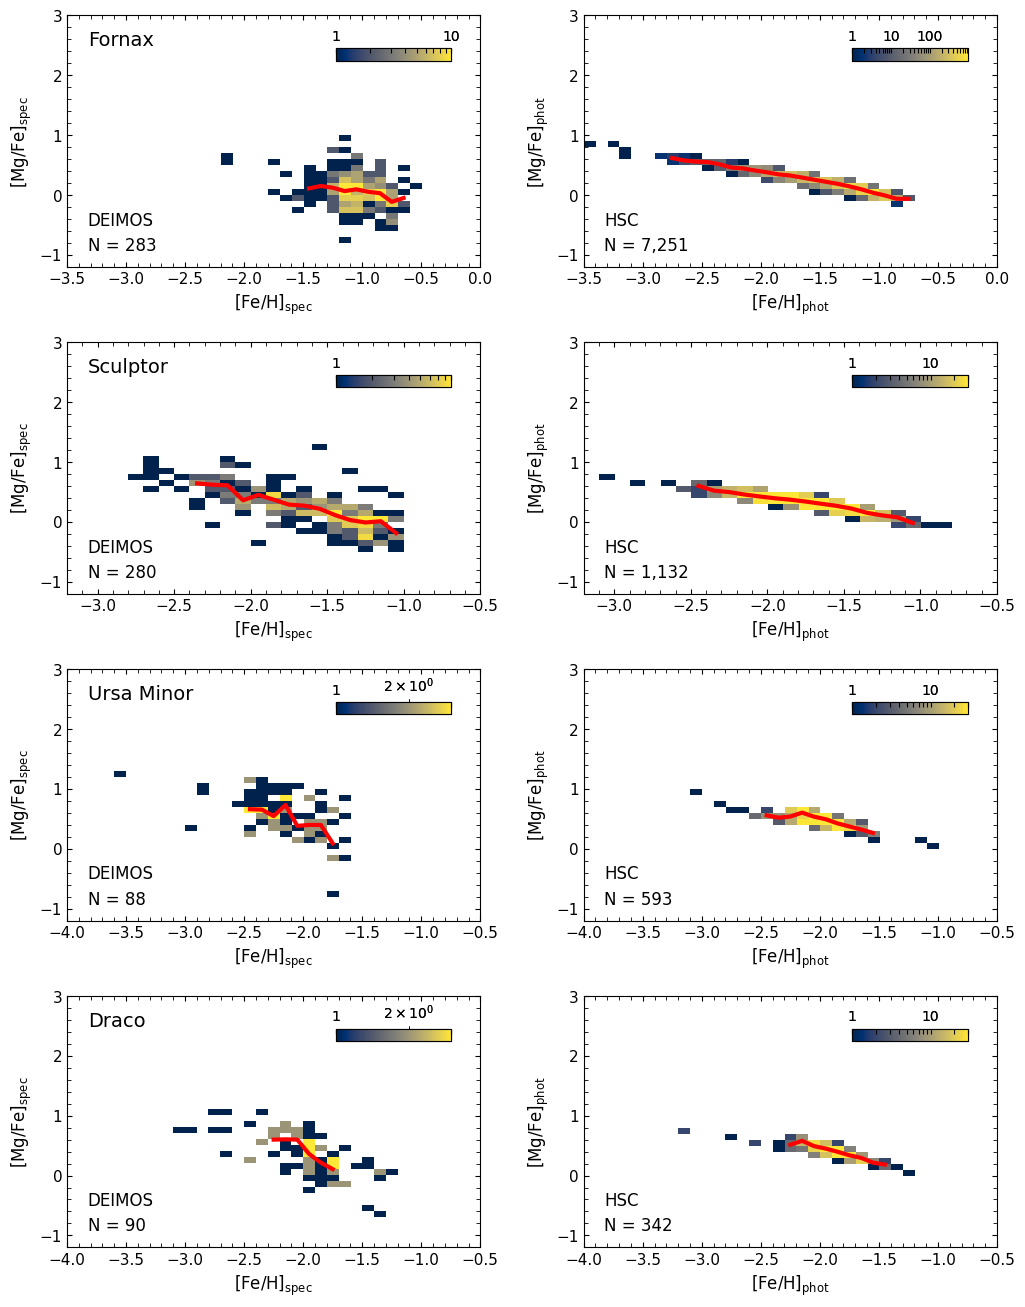

In [69]:
def plot_2d_histogram(ax, x, y, xlabel, ylabel, xlim, ylim, vmin=None, vmax=None, ticks=None):
    bins_width = 0.1
    xbins = np.arange(np.floor(np.min(x) / bins_width) * bins_width, 
                      np.ceil(np.max(x) / bins_width) * bins_width + bins_width, bins_width)
    ybins = np.arange(np.floor(np.min(y) / bins_width) * bins_width, 
                      np.ceil(np.max(y) / bins_width) * bins_width + bins_width, bins_width)

    counts, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins))

    median_values = []
    for i in range(len(xedges) - 1):
        mask = (xedges[i] <= x) & (x < xedges[i+1])
        y_in_bin = y[mask]
        if len(y_in_bin) >= 5:
            median_values.append(np.median(y_in_bin))
        else:
            median_values.append(np.nan)

    xedges_centered = (xedges[:-1] + xedges[1:]) / 2
    median_values = median_values[:len(xedges_centered)]

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(counts.T, cmap='cividis', origin='lower', extent=extent, aspect='auto', norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3.5, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=3, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3.5, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=3, labelsize=11)
    
    # Plot median line
    ax.plot(xedges_centered, median_values, color='red', label='Median', lw=3)

    # Add color bar
    cax = ax.inset_axes([0.65, 0.82, 0.28, 0.05])
    fig.add_axes(cax)
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=10, direction='in')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label('', size=11, labelpad=4, loc='center')
    cbar.locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=5)
    cbar.formatter = LogFormatter(base=10.0, labelOnlyBase=True)
    if ticks:
        cbar.set_ticks(ticks)  # Add custom ticks
    cbar.update_ticks()

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16), gridspec_kw={'wspace': 0.25, 'hspace': 0.3})
(ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7) = axes

# Fornax
plot_2d_histogram(ax0, fnx_mag['FEH'], fnx_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-3.5, 0], [-1.2, 3], vmin=1, vmax=10)
plot_2d_histogram(ax1, hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-3.5, 0], [-1.2, 3])
ax0.text(0.05, 0.94, 'Fornax', ha='left', va='top', transform=ax0.transAxes, size=14)
ax0.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(fnx_mag['FEH'])), ha='left', va='bottom', transform=ax0.transAxes, size=12)
ax1.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax1.transAxes, size=12)
ax1.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_fnx_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax1.transAxes, size=12)

# Sculptor
plot_2d_histogram(ax2, scl_mag['FEH'], scl_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-3.2, -0.5], [-1.2, 3])
plot_2d_histogram(ax3, hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-3.2, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax2.text(0.05, 0.94, 'Sculptor', ha='left', va='top', transform=ax2.transAxes, size=14)
ax2.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax2.transAxes, size=12)
ax2.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(scl_mag['FEH'])), ha='left', va='bottom', transform=ax2.transAxes, size=12)
ax3.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax3.transAxes, size=12)
ax3.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_scl_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax3.transAxes, size=12)

# Ursa Minor
plot_2d_histogram(ax4, umi_mag['FEH'], umi_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=3, ticks=[1, 3])
plot_2d_histogram(ax5, hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax4.text(0.05, 0.94, 'Ursa Minor', ha='left', va='top', transform=ax4.transAxes, size=14)
ax4.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax4.transAxes, size=12)
ax4.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(umi_mag['FEH'])), ha='left', va='bottom', transform=ax4.transAxes, size=12)
#cbar.set_ticks([1, 3])
ax5.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax5.transAxes, size=12)
ax5.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_umi_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax5.transAxes, size=12)

# Draco
plot_2d_histogram(ax6, dra_mag['FEH'], dra_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=3, ticks=[1, 3])
plot_2d_histogram(ax7, hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax6.text(0.05, 0.94, 'Draco', ha='left', va='top', transform=ax6.transAxes, size=14)
ax6.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax6.transAxes, size=12)
ax6.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(dra_mag['FEH'])), ha='left', va='bottom', transform=ax6.transAxes, size=12)
ax7.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax7.transAxes, size=12)
ax7.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_dra_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax7.transAxes, size=12)


plt.savefig('compare_ann_spec_phot_mgfe_feh_hist2d_medianline.png', bbox_inches='tight')

In [70]:
def get_median_mgfe(feh_values, mgfe_values, bin_width=0.1):
    bins = np.arange(np.floor(np.min(feh_values) / bin_width) * bin_width, 
                     np.ceil(np.max(feh_values) / bin_width) * bin_width + bin_width, bin_width)
    #print(bins) #[-2.2 -2.1 -2. -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1. -0.9 -0.8 -0.7 -0.6 -0.5]
    
    median_mgfe_dict = {}
    for i in range(len(bins) - 1):
        mask = (bins[i] <= feh_values) & (feh_values < bins[i + 1])
        if np.sum(mask) >= 5:  # get median value if there are 5 data at least
            median_mgfe_dict[(bins[i], bins[i + 1])] = np.median(mgfe_values[mask])
        else:
            median_mgfe_dict[(bins[i], bins[i + 1])] = np.nan  # NaN if there are less than 5 stars
    
    return median_mgfe_dict

# Get median MGFE value per FEH 0.1 bin
median_mgfe_bins = get_median_mgfe(fnx_mag['FEH'], fnx_mag['MGFE'])

# Get predicted MGFE values
# Assign the median MGFE value of the corresponding FEH bin as the predicted value for each data point.
predicted_fnx_MGFE = np.array([
    median_mgfe_bins.get(
        next(((b1, b2) for (b1, b2) in median_mgfe_bins if b1 <= feh < b2), None),
        np.nan
    ) for feh in fnx_mag['FEH']
])
#print(predicted_fnx_MGFE)

"""def calculate_err_sys(mgfe, fitted_mgfe, err_mgfe, N):
    def equation(err_sys):
        #numerator = np.sum((mgfe - fitted_mgfe)**2)
        #denominator = np.sum(err_mgfe**2) + (err_sys**2)
        numerator = (mgfe - fitted_mgfe)**2
        denominator = err_mgfe**2 + err_sys**2
        result = np.sum(numerator / denominator) / N
        print(f"numerator: {numerator}, denominator: {denominator}, result: {result}")
        
        return result - 1
   
    err_sys_initial = 0.1
    err_sys_solution = fsolve(equation, err_sys_initial)[0]
    print('err_sys_solution =', np.abs(err_sys_solution))

    return err_sys_solution

err_sys_1 = calculate_err_sys(fnx_mag['MGFE'], predicted_fnx_MGFE, fnx_mag['MGFEERR'], len(fnx_mag['MGFE']))

err_sys_2 = calculate_err_sys(hsc_fnx_mag['MGFE_phot_ann'], predicted_hsc_fnx_MGFE, hsc_fnx_mag['MGFE_phot_ann_uncertainty'], len(hsc_fnx_mag['MGFE_phot_ann']))
"""

from scipy.optimize import minimize
def calculate_err_sys(mgfe, fitted_mgfe, err_mgfe, N):
    def objective(err_sys):
        numerator = (mgfe - fitted_mgfe)**2
        denominator = err_mgfe**2 + err_sys[0]**2
        result = np.sum(numerator / denominator) / N
        #print(f"numerator: {numerator}, denominator: {denominator}, result: {result}")
        return (result - 1)**2  #minimize

    initial_guess = [0.1]
    bounds = [(0, None)]
    
    result = minimize(objective, x0=initial_guess, bounds=bounds)
    
    err_sys_solution = result.x[0]
    print(f"err_sys_solution: {err_sys_solution}")
    return err_sys_solution

sys_err_fnx = calculate_err_sys(fnx_mag['MGFE'], predicted_fnx_MGFE, fnx_mag['MGFEERR'], len(fnx_mag['MGFE']))
sys_err_hsc_fnx = calculate_err_sys(hsc_fnx_mag['MGFE_phot_ann'], predicted_hsc_fnx_MGFE, hsc_fnx_mag['MGFE_phot_ann_uncertainty'], len(hsc_fnx_mag['MGFE_phot_ann']))

err_sys_solution: 0.14317656398425804
err_sys_solution: 0.5881356520195343


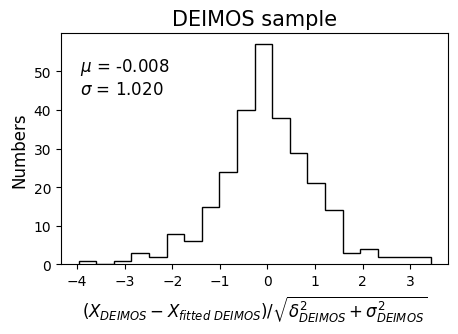

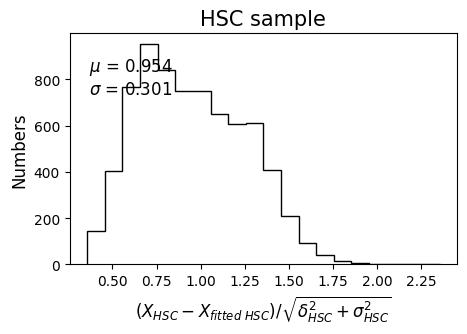

In [71]:
fig, ax0 = plt.subplots(figsize=(5,3))
x = (fnx_mag['MGFE'] - predicted_fnx_MGFE) / np.sqrt(fnx_mag['MGFEERR']**2 + sys_err_fnx**2)
ax0.hist(x, bins=20, color='k', histtype='step')
ax0.set_title('DEIMOS sample', size=15)
ax0.set_xlabel(r'$(X_{DEIMOS} - X_{fitted~DEIMOS}) / \sqrt{\delta_{DEIMOS}^2 + \sigma_{DEIMOS}^2}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.text(0.05, 0.9, '$\mu$ = {0:,.3f}'.format(np.mean(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.8, '$\sigma$ = {0:,.3f}'.format(np.std(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
plt.show()

print('\n')

fig, ax0 = plt.subplots(figsize=(5,3))
x = (hsc_fnx_mag['MGFE_phot_ann'] - predicted_hsc_fnx_MGFE) / np.sqrt(hsc_fnx_mag['MGFE_phot_ann_uncertainty']**2 + sys_err_hsc_fnx**2)
ax0.hist(x, bins=20, color='k', histtype='step')
ax0.set_title('HSC sample', size=15)
ax0.set_xlabel(r'$(X_{HSC} - X_{fitted~HSC}) / \sqrt{\delta_{HSC}^2 + \sigma_{HSC}^2}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.text(0.05, 0.9, '$\mu$ = {0:,.3f}'.format(np.mean(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.8, '$\sigma$ = {0:,.3f}'.format(np.std(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
plt.show()

In [73]:
fnx_mag_sigma = fnx_mag[
(np.abs(fnx_mag['FEH'] - np.mean(fnx_mag['FEH'])) - fnx_mag['FEHERR'] < 3 * fnx_mag['FEHERR'])
&
(np.abs(fnx_mag['MGFE'] - np.mean(fnx_mag['MGFE'])) - fnx_mag['MGFEERR'] < 3 * fnx_mag['MGFEERR'])
]
print(len(fnx_mag)) #261
print(len(fnx_mag_sigma), '\n') #224
scl_mag_sigma = scl_mag[
(np.abs(scl_mag['FEH'] - np.mean(scl_mag['FEH'])) - scl_mag['FEHERR'] < 3 * scl_mag['FEHERR'])
&
(np.abs(scl_mag['MGFE'] - np.mean(scl_mag['MGFE'])) - scl_mag['MGFEERR'] < 3 * scl_mag['MGFEERR'])
]
print(len(scl_mag)) #294
print(len(scl_mag_sigma), '\n') #184
umi_mag_sigma = umi_mag[
(np.abs(umi_mag['FEH'] - np.mean(umi_mag['FEH'])) - umi_mag['FEHERR'] < 3 * umi_mag['FEHERR'])
&
(np.abs(umi_mag['MGFE'] - np.mean(umi_mag['MGFE'])) - umi_mag['MGFEERR'] < 3 * umi_mag['MGFEERR'])
]
print(len(umi_mag)) #91
print(len(umi_mag_sigma), '\n') #74
dra_mag_sigma = dra_mag[
(np.abs(dra_mag['FEH'] - np.mean(dra_mag['FEH'])) - dra_mag['FEHERR'] < 3 * dra_mag['FEHERR'])
&
(np.abs(dra_mag['MGFE'] - np.mean(dra_mag['MGFE'])) - dra_mag['MGFEERR'] < 3 * dra_mag['MGFEERR'])
]
print(len(dra_mag)) #108
print(len(dra_mag_sigma), '\n') #82


hsc_fnx_mag_sigma = hsc_fnx_mag[
(np.abs(hsc_fnx_mag['FEH_phot_ann'] - np.mean(hsc_fnx_mag['FEH_phot_ann'])) - hsc_fnx_mag['FEH_phot_ann_uncertainty'] < 3 * hsc_fnx_mag['FEH_phot_ann_uncertainty'])
&
(np.abs(hsc_fnx_mag['MGFE_phot_ann'] - np.mean(hsc_fnx_mag['MGFE_phot_ann'])) - hsc_fnx_mag['MGFE_phot_ann_uncertainty'] < 3 * hsc_fnx_mag['MGFE_phot_ann_uncertainty'])
]
print(len(hsc_fnx_mag)) #5514
print(len(hsc_fnx_mag_sigma), '\n') #5364
hsc_scl_mag_sigma = hsc_scl_mag[
(np.abs(hsc_scl_mag['FEH_phot_ann'] - np.mean(hsc_scl_mag['FEH_phot_ann'])) - hsc_scl_mag['FEH_phot_ann_uncertainty'] < 3 * hsc_scl_mag['FEH_phot_ann_uncertainty'])
&
(np.abs(hsc_scl_mag['MGFE_phot_ann'] - np.mean(hsc_scl_mag['MGFE_phot_ann'])) - hsc_scl_mag['MGFE_phot_ann_uncertainty'] < 3 * hsc_scl_mag['MGFE_phot_ann_uncertainty'])
]
print(len(hsc_scl_mag)) #1205
print(len(hsc_scl_mag_sigma), '\n') #1078
hsc_umi_mag_sigma = hsc_umi_mag[
(np.abs(hsc_umi_mag['FEH_phot_ann'] - np.mean(hsc_umi_mag['FEH_phot_ann'])) - hsc_umi_mag['FEH_phot_ann_uncertainty'] < 3 * hsc_umi_mag['FEH_phot_ann_uncertainty'])
&
(np.abs(hsc_umi_mag['MGFE_phot_ann'] - np.mean(hsc_umi_mag['MGFE_phot_ann'])) - hsc_umi_mag['MGFE_phot_ann_uncertainty'] < 3 * hsc_umi_mag['MGFE_phot_ann_uncertainty'])
]
print(len(hsc_umi_mag)) #647
print(len(hsc_umi_mag_sigma), '\n') #630
hsc_dra_mag_sigma = hsc_dra_mag[
(np.abs(hsc_dra_mag['FEH_phot_ann'] - np.mean(hsc_dra_mag['FEH_phot_ann'])) - hsc_dra_mag['FEH_phot_ann_uncertainty'] < 3 * hsc_dra_mag['FEH_phot_ann_uncertainty'])
&
(np.abs(hsc_dra_mag['MGFE_phot_ann'] - np.mean(hsc_dra_mag['MGFE_phot_ann'])) - hsc_dra_mag['MGFE_phot_ann_uncertainty'] < 3 * hsc_dra_mag['MGFE_phot_ann_uncertainty'])
]
print(len(hsc_dra_mag)) #469
print(len(hsc_dra_mag_sigma)) #444

283
235 

280
169 

88
70 

90
64 

7251
6826 

1132
1100 

593
591 

342
339


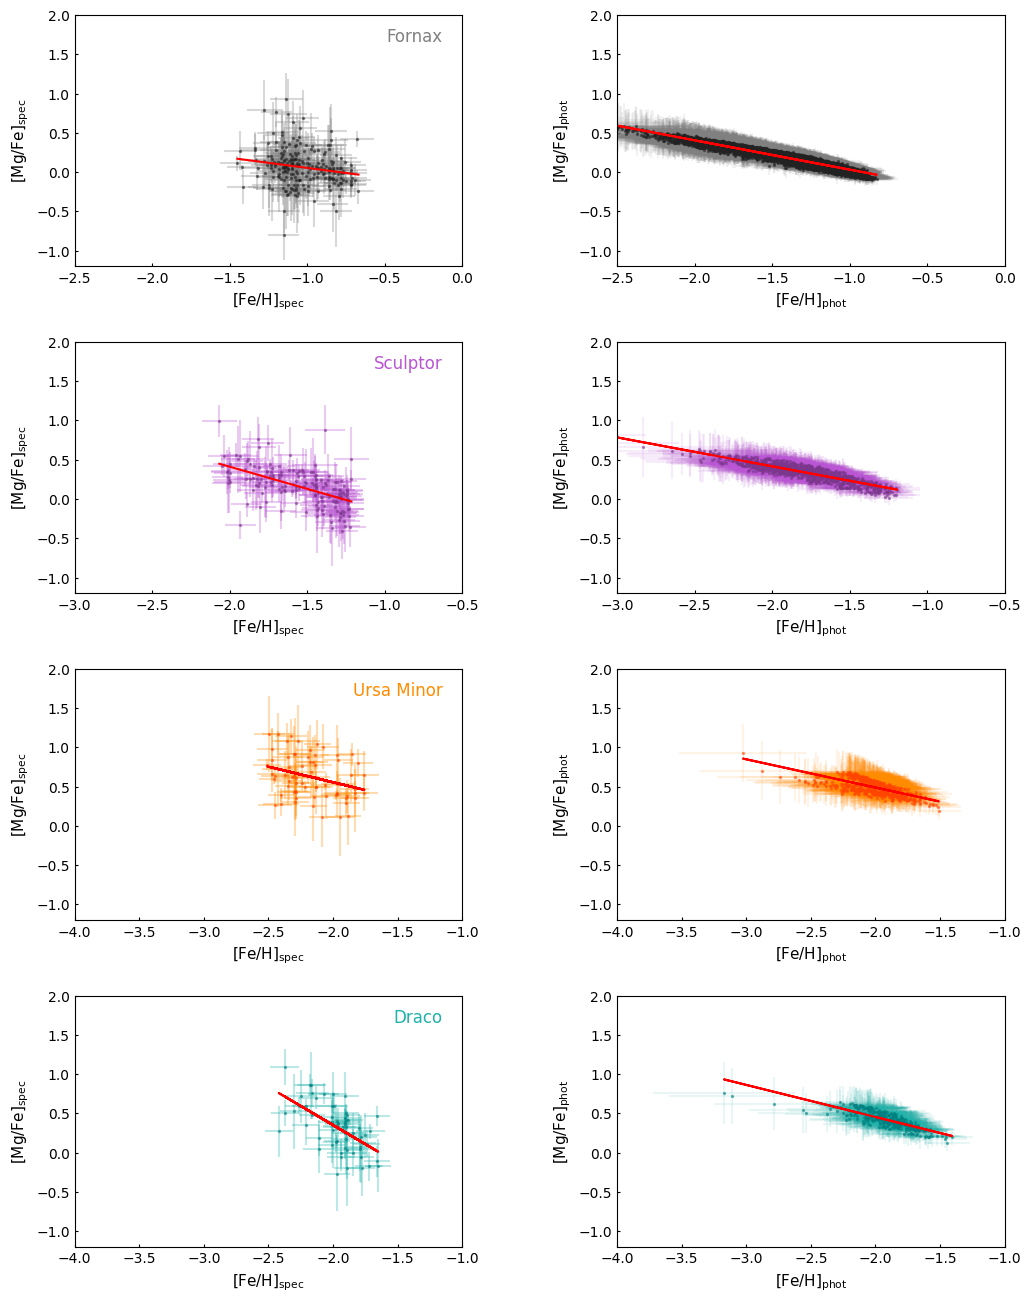

In [76]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(12,16), gridspec_kw={'wspace':0.4, 'hspace':0.3})
s = 2 ; alpha = 0.5 ; markersize=0

# Fnx
ax0.errorbar(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], xerr=fnx_mag_sigma['FEHERR'], yerr=fnx_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='gray')
ax0.scatter(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#222222', zorder=2)
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax0.set_xlim([-2.5, 0])
ax0.set_ylim([-1.2, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.95, 0.95, 'Fornax', ha='right', va='top', transform=ax0.transAxes, color='gray', size=12)
slope, intercept = np.polyfit(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], 1)
ax0.plot(fnx_mag_sigma['FEH'], slope * fnx_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax1.errorbar(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], xerr=hsc_fnx_mag_sigma['FEH_phot_ann_uncertainty'], yerr=hsc_fnx_mag_sigma['MGFE_phot_ann_uncertainty'], markersize=markersize, fmt='o', alpha=0.1, color='gray')
ax1.scatter(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#222222', zorder=2)
ax1.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax1.set_xlim([-2.5, 0])
ax1.set_ylim([-1.2, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], 1)
ax1.plot(hsc_fnx_mag_sigma['FEH_phot_ann'], slope * hsc_fnx_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# Scl
ax2.errorbar(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], xerr=scl_mag_sigma['FEHERR'], yerr=scl_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='mediumorchid')
ax2.scatter(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#7A378B', zorder=2)
ax2.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax2.set_xlim([-3, -0.5])
ax2.set_ylim([-1.2, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.95, 0.95, 'Sculptor', ha='right', va='top', transform=ax2.transAxes, color='mediumorchid', size=12)
slope, intercept = np.polyfit(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], 1)
ax2.plot(scl_mag_sigma['FEH'], slope * scl_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax3.errorbar(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], xerr=hsc_scl_mag_sigma['FEH_phot_ann_uncertainty'], yerr=hsc_scl_mag_sigma['MGFE_phot_ann_uncertainty'], markersize=markersize, fmt='o', alpha=0.1, color='mediumorchid')
ax3.scatter(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#7A378B', zorder=2)
ax3.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax3.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax3.set_xlim([-3, -0.5])
ax3.set_ylim([-1.2, 2])
ax3.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax3.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax3.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax3.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], 1)
ax3.plot(hsc_scl_mag_sigma['FEH_phot_ann'], slope * hsc_scl_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# UMi
ax4.errorbar(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], xerr=umi_mag_sigma['FEHERR'], yerr=umi_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='darkorange')
ax4.scatter(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#FF4500', zorder=2)
ax4.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax4.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax4.set_xlim([-4, -1])
ax4.set_ylim([-1.2, 2])
ax4.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax4.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax4.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax4.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax4.text(0.95, 0.95, 'Ursa Minor', ha='right', va='top', transform=ax4.transAxes, color='darkorange', size=12)
slope, intercept = np.polyfit(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], 1)
ax4.plot(umi_mag_sigma['FEH'], slope * umi_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax5.errorbar(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], xerr=hsc_umi_mag_sigma['FEH_phot_ann_uncertainty'], yerr=hsc_umi_mag_sigma['MGFE_phot_ann_uncertainty'], markersize=markersize, fmt='o', alpha=0.1, color='darkorange')
ax5.scatter(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#FF4500', zorder=2)
ax5.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax5.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax5.set_xlim([-4, -1])
ax5.set_ylim([-1.2, 2])
ax5.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax5.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax5.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax5.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], 1)
ax5.plot(hsc_umi_mag_sigma['FEH_phot_ann'], slope * hsc_umi_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# Dra
ax6.errorbar(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], xerr=dra_mag_sigma['FEHERR'], yerr=dra_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='lightseagreen')
ax6.scatter(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#008080', zorder=2)
ax6.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax6.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax6.set_xlim([-4, -1])
ax6.set_ylim([-1.2, 2])
ax6.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax6.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax6.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax6.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax6.text(0.95, 0.95, 'Draco', ha='right', va='top', transform=ax6.transAxes, color='lightseagreen', size=12)
slope, intercept = np.polyfit(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], 1)
ax6.plot(dra_mag_sigma['FEH'], slope * dra_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax7.errorbar(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], xerr=hsc_dra_mag_sigma['FEH_phot_ann_uncertainty'], yerr=hsc_dra_mag_sigma['MGFE_phot_ann_uncertainty'], markersize=markersize, fmt='o', alpha=0.1, color='lightseagreen')
ax7.scatter(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#008080', zorder=2)
ax7.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax7.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax7.set_xlim([-4, -1])
ax7.set_ylim([-1.2, 2])
ax7.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax7.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax7.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax7.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], 1)
ax7.plot(hsc_dra_mag_sigma['FEH_phot_ann'], slope * hsc_dra_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')

#plt.show()
plt.savefig('compare_ann_spec_phot_mgfe_feh_w_line.png', bbox_inches='tight')

In [ ]:
# Simple comparison version

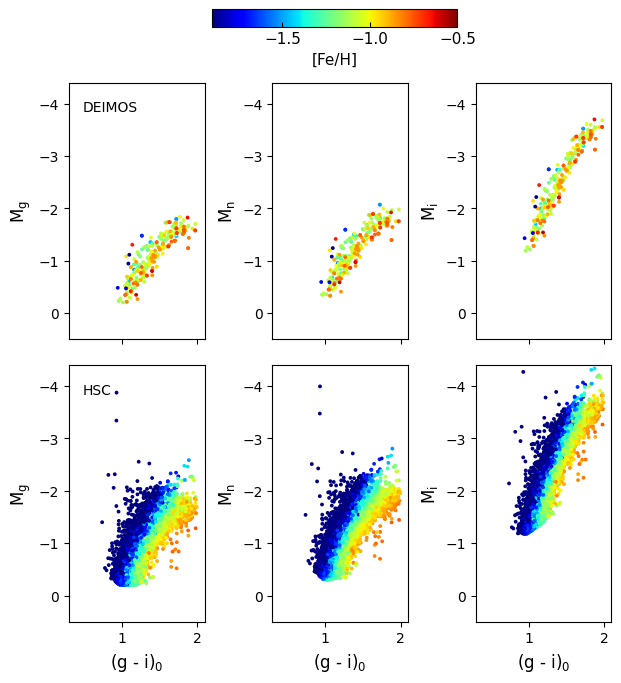

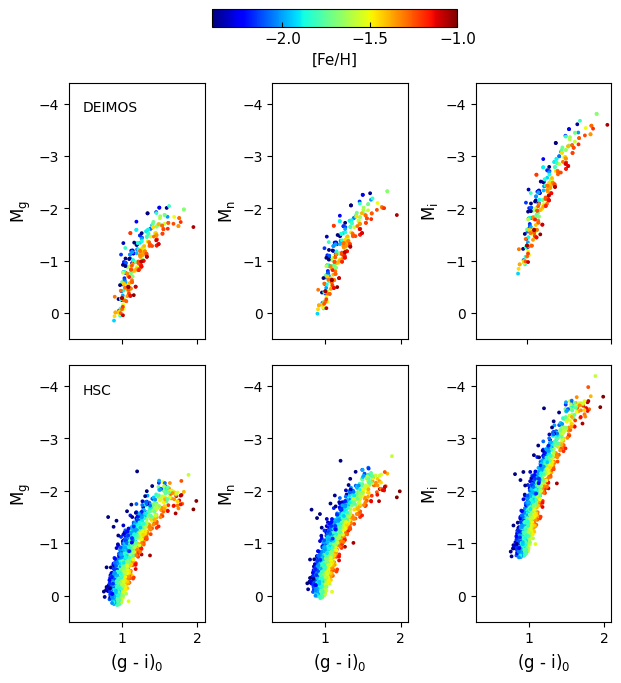

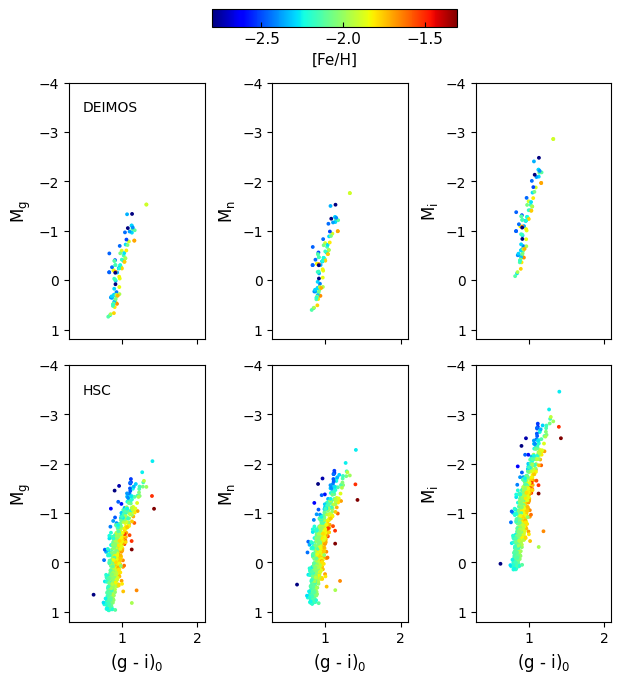

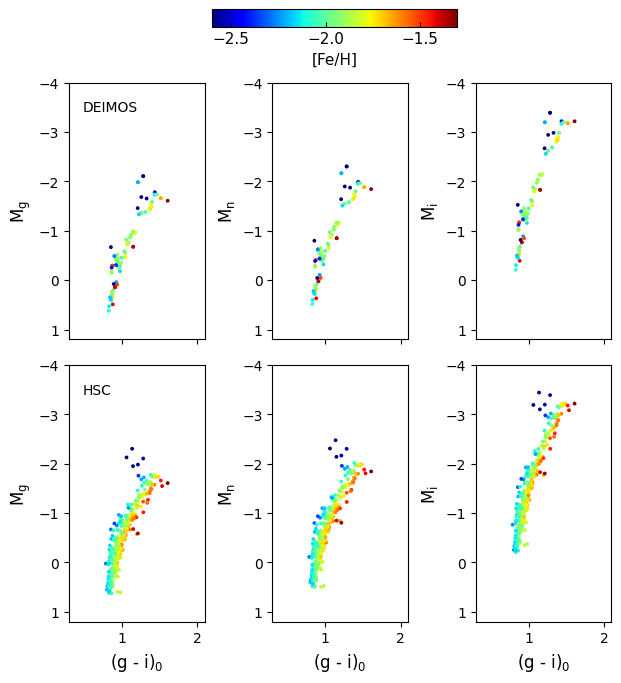

In [77]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.8 ; vmax = -1.3
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.6 ; vmax = -1.3
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Draco.png', bbox_inches='tight')

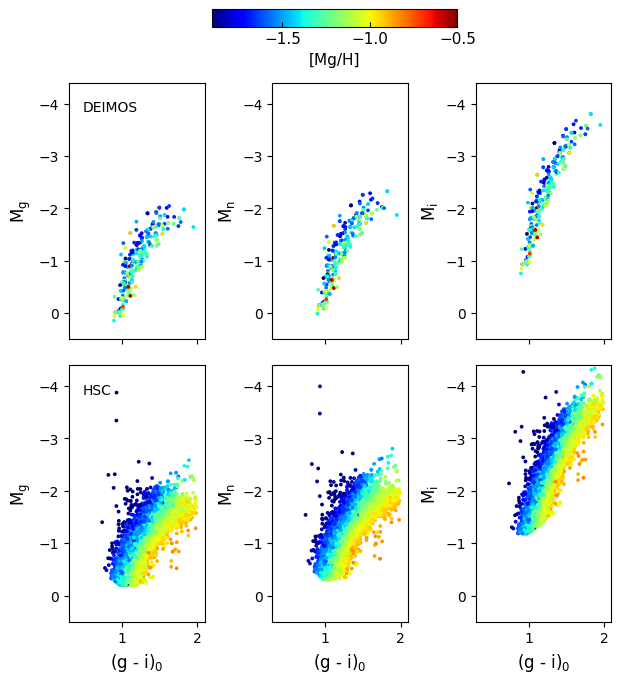

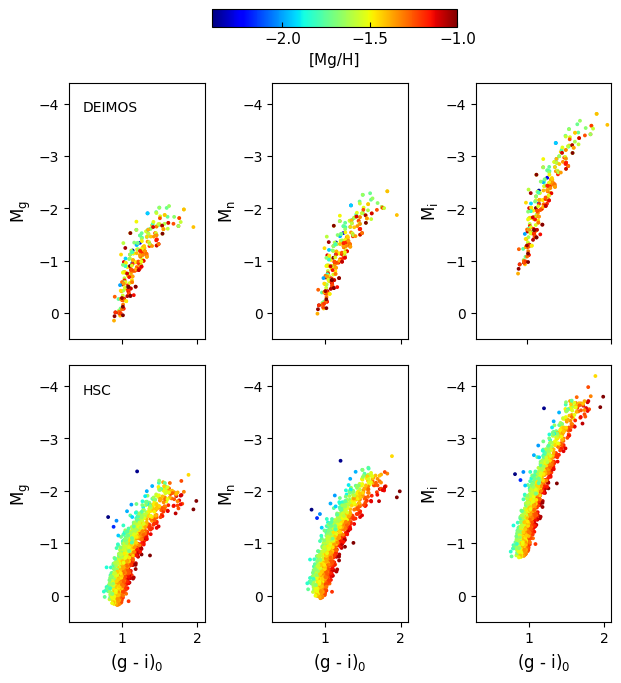

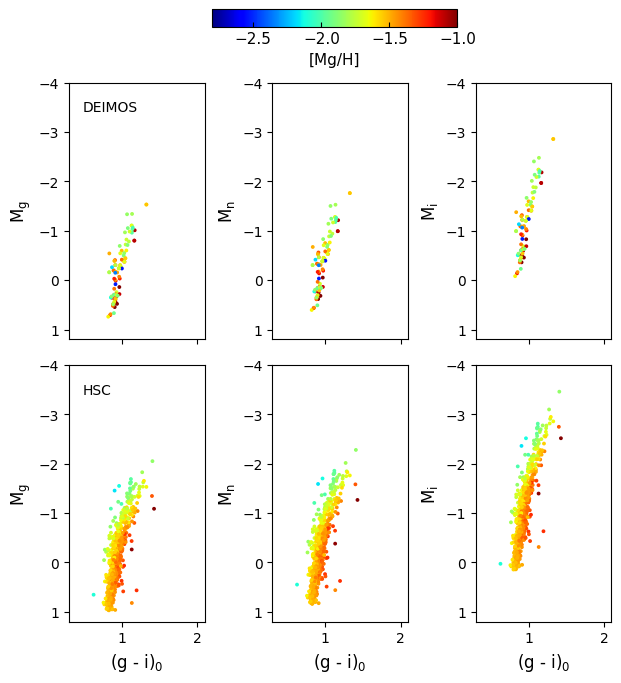

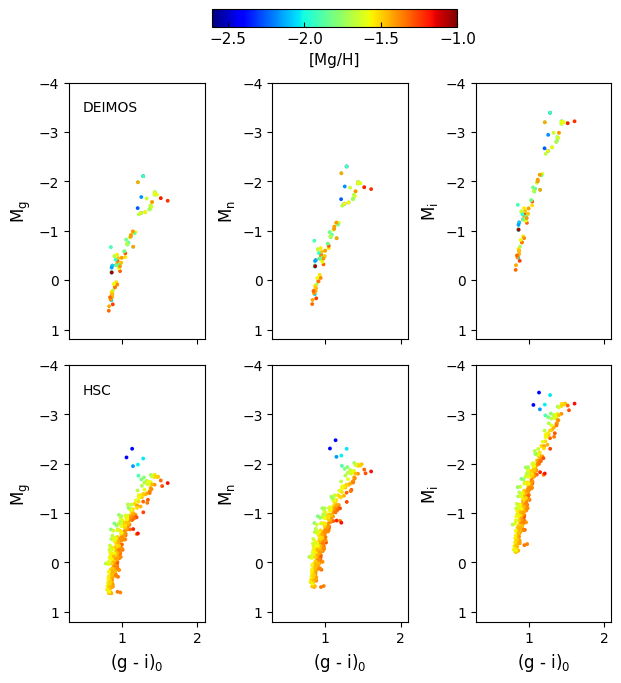

In [78]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.8 ; vmax = -1
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.6 ; vmax = -1
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Draco.png', bbox_inches='tight')

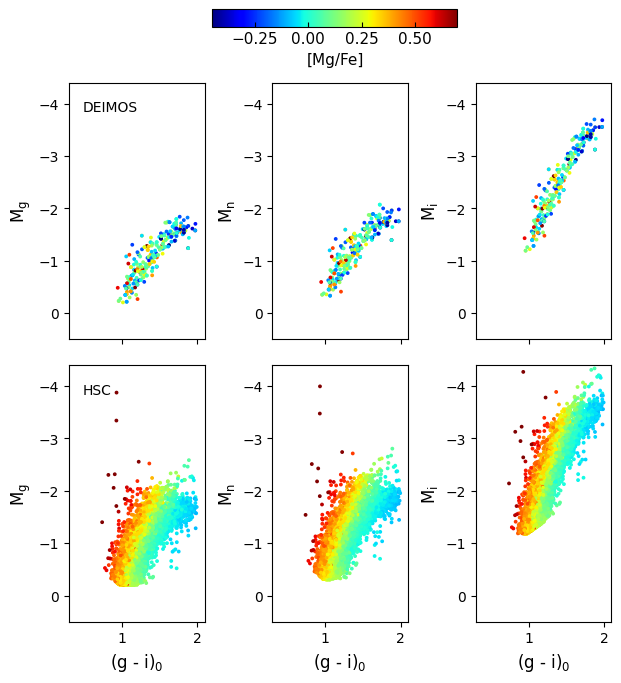

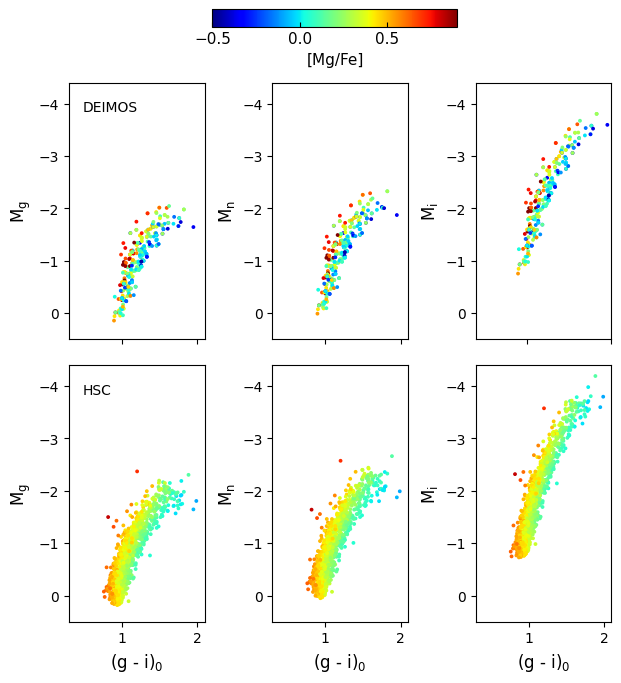

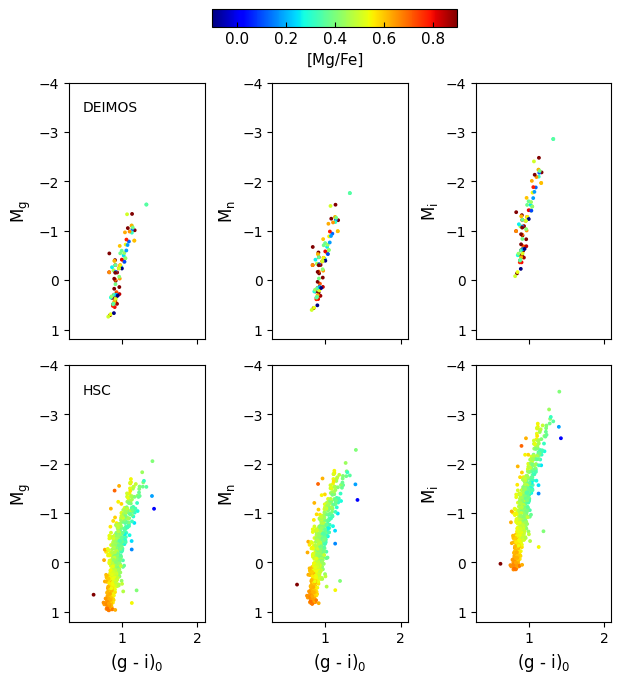

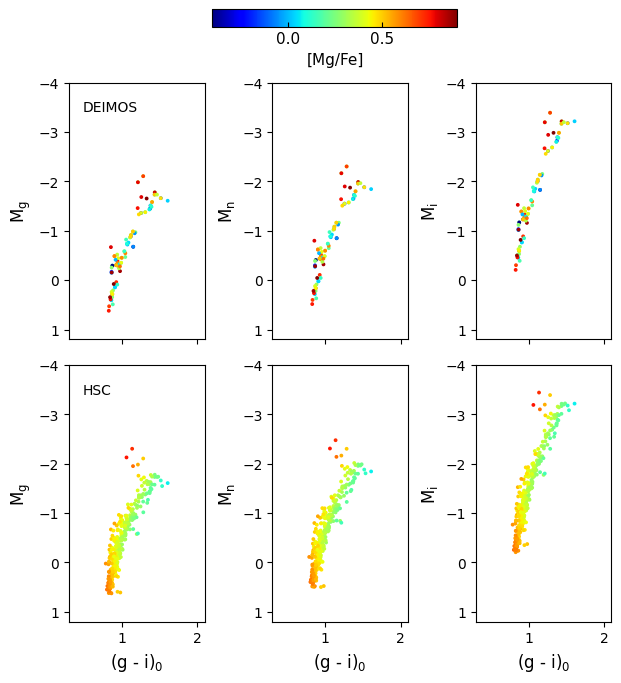

In [79]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -0.45 ; vmax = 0.7
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -0.5 ; vmax =0.9
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -0.1 ; vmax = 0.9
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -0.4 ; vmax = 0.9
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Draco.png', bbox_inches='tight')

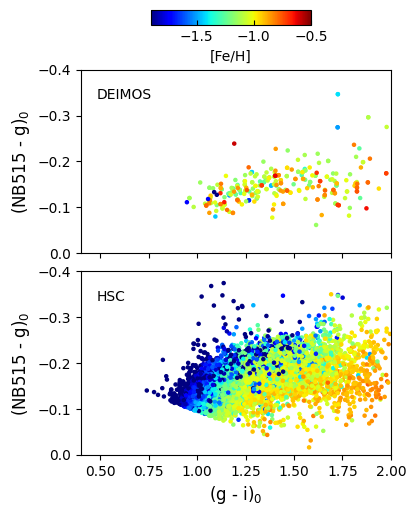

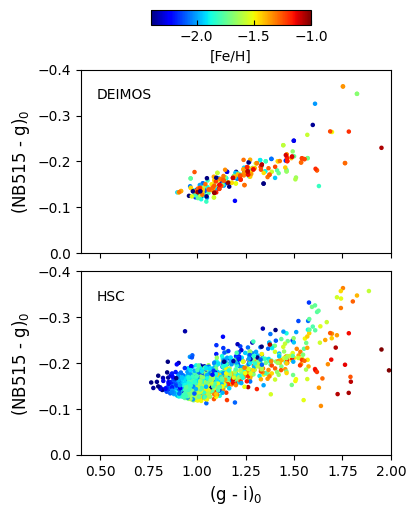

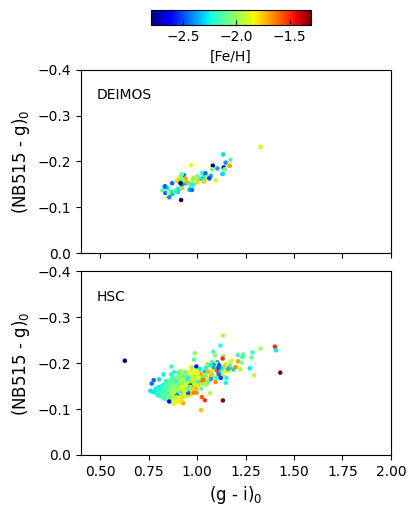

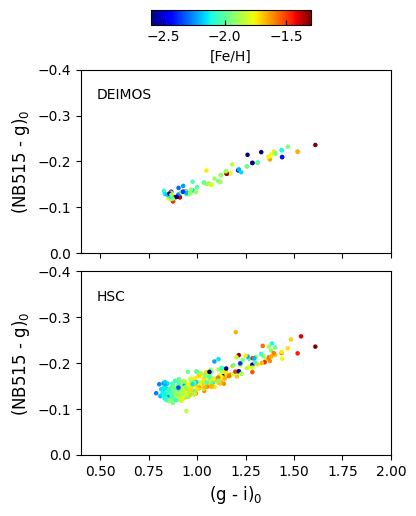

In [80]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Fornax.png', bbox_inches='tight')

# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.8 ; vmax = -1.3
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.6 ; vmax = -1.3
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Draco.png', bbox_inches='tight')

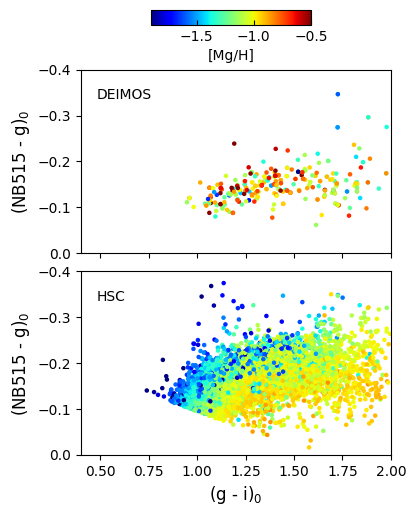

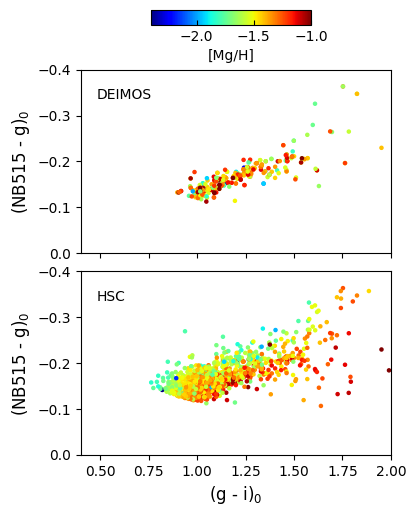

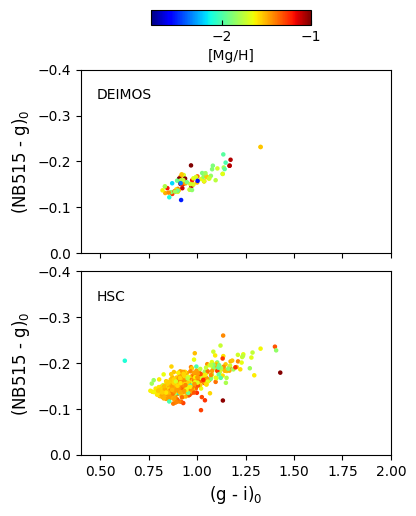

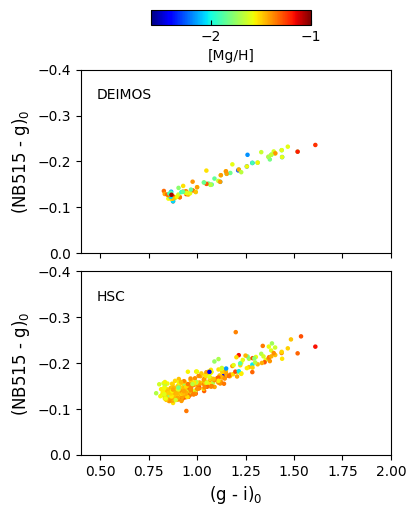

In [82]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Fornax.png', bbox_inches='tight')


# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.8 ; vmax = -1
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.6 ; vmax = -1
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Draco.png', bbox_inches='tight')

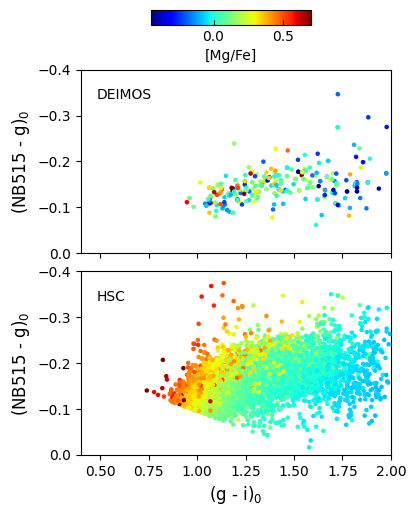

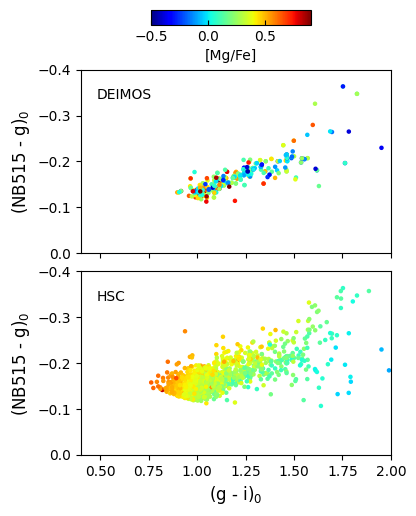

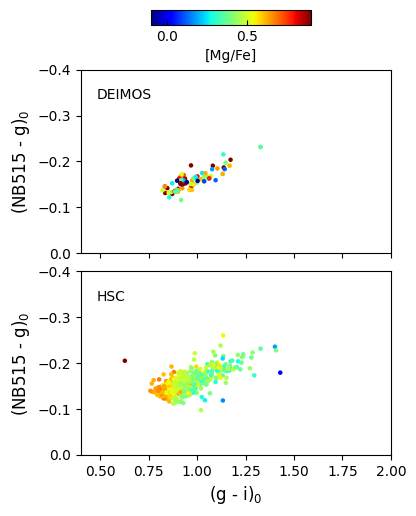

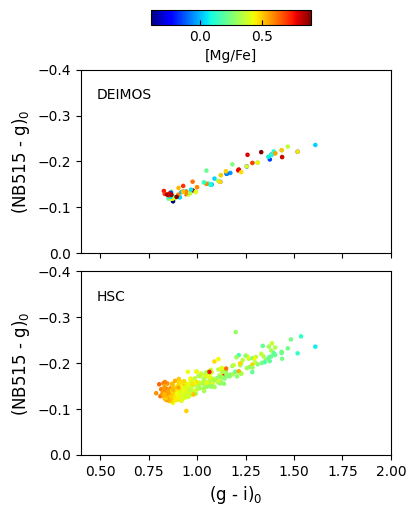

In [83]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.45 ; vmax = 0.7
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Fornax.png', bbox_inches='tight')


# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.5 ; vmax = 0.9
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.1 ; vmax = 0.9
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.4 ; vmax = 0.9
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Draco.png', bbox_inches='tight')